# Citation Intent Classification - SciBERT_UNCASED

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A survey of methodologies for Citation Intent Classification
#### Brief description of the task
The aim of this project is to walk through the building of a Machine Learning model capable of classifying citation intents in scientific papers.

I will make use of a Pre-trained language model (PLM) to build a meaningful comparison between some of the different techniques that could be used to produce the final outcome, in order to investigate which works better for the task.

The techniques I aim to compare are:
- The fine-tuning of a PLM;
- The construction of an ensemble multi-class classifier based on binary classifiers.

#### Requirements

Download additional libraries and modules.

In [ ]:
!pip install transformers datasets scikit-learn accelerate ray[tune]==2.9.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


Below you will find all the necessary imports for the project, together with the version of the main libraries.

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno
import seaborn as sns
import sklearn
import tensorflow as tf
import datasets
from datasets import load_dataset
import random
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

print(f"Python Version: {sys.version}\n\nMain libraries of the project:\n")
print(f"- NumPy Version: {np.__version__}")
print(f"- Pandas Version: {pd.__version__}")
print(f"- Matplotlib Version: {mpl.__version__}")
print(f"- Seaborn Version: {sns.__version__}")
print(f"- Scikit-learn Version: {sklearn.__version__}")
print(f"- TensorFlow Version: {tf.__version__}")
print(f"- PyTorch Version: {torch.__version__}")
print(f"- Datasets Version: {datasets.__version__}")
print(f"- Transformers Version: {transformers.__version__}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Main libraries of the project:

- NumPy Version: 1.23.5
- Pandas Version: 1.5.3
- Matplotlib Version: 3.7.1
- Seaborn Version: 0.13.1
- Scikit-learn Version: 1.2.2
- TensorFlow Version: 2.15.0
- PyTorch Version: 2.1.0+cu121
- Datasets Version: 2.16.1
- Transformers Version: 4.35.2


Retrieve GPU device for PyTorch based operations

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset loading and inspection

I download the SciCite dataset directly from the datasets library provided by Huggingface. The dataset will be stored inside a dict-like object yet splitted, consistently with the benchmark dataset, into train, validation and test sets.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1859 [00:00<?, ? examples/s]

Here I print some information about the dataset we are using. Mainly, we get a brief description of it, as well as the link to access the original dataset.

In [ ]:
print(dataset['train'].description, '\n\n')
print(dataset['train'].homepage)


This is a dataset for classifying citation intents in academic papers.
The main citation intent label for each Json object is specified with the label
key while the citation context is specified in with a context key. Example:
{
 'string': 'In chacma baboons, male-infant relationships can be linked to both
    formation of friendships and paternity success [30,31].'
 'sectionName': 'Introduction',
 'label': 'background',
 'citingPaperId': '7a6b2d4b405439',
 'citedPaperId': '9d1abadc55b5e0',
 ...
 }
You may obtain the full information about the paper using the provided paper ids
with the Semantic Scholar API (https://api.semanticscholar.org/).
The labels are:
Method, Background, Result
 


https://github.com/allenai/scicite


Let's start inspecting our dataset.

At first, we print the shape of each one of the three splits.

In [ ]:
print(dataset.shape)

{'train': (8194, 14), 'validation': (916, 14), 'test': (1859, 14)}


Now, let's look at the specific columns of each one the splits.

For simplicty, I will work around the train split for inspection purposes, but first asserting that all the splits have the same columns.

In [ ]:
assert(dataset['train'].column_names==dataset['validation'].column_names==dataset['test'].column_names)
print(dataset['train'].column_names)

['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']


Let's now inspect the types of data contained in these columns.

In [ ]:
dataset['train'].features

{'string': Value(dtype='string', id=None),
 'sectionName': Value(dtype='string', id=None),
 'label': ClassLabel(names=['method', 'background', 'result'], id=None),
 'citingPaperId': Value(dtype='string', id=None),
 'citedPaperId': Value(dtype='string', id=None),
 'excerpt_index': Value(dtype='int32', id=None),
 'isKeyCitation': Value(dtype='bool', id=None),
 'label2': ClassLabel(names=['supportive', 'not_supportive', 'cant_determine', 'none'], id=None),
 'citeEnd': Value(dtype='int64', id=None),
 'citeStart': Value(dtype='int64', id=None),
 'source': ClassLabel(names=['properNoun', 'andPhrase', 'acronym', 'etAlPhrase', 'explicit', 'acronymParen', 'nan'], id=None),
 'label_confidence': Value(dtype='float32', id=None),
 'label2_confidence': Value(dtype='float32', id=None),
 'id': Value(dtype='string', id=None)}

The dataset has been thought to represent a real distribution of citation intents in the average research paper. Thus, it presents an higly imbalanced distribution of labels. </br>To better see this, let's visualize the distribution for each of the splits.

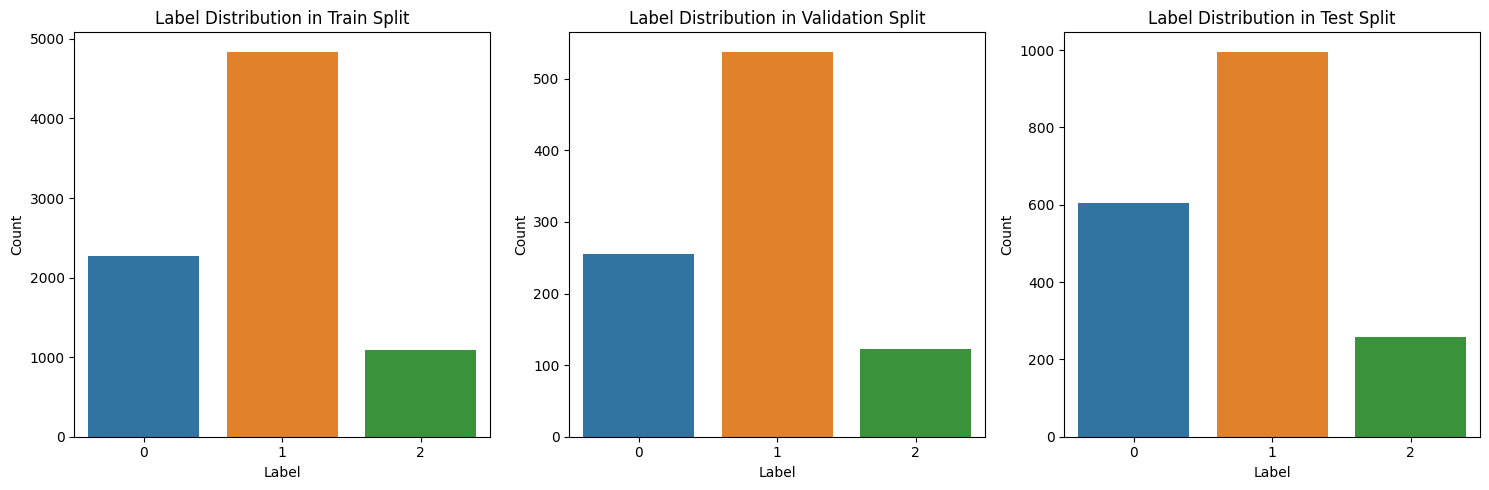

In [ ]:
splits = ['train', 'validation', 'test']

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, split in enumerate(splits):
    labels = [example['label'] for example in dataset[split]]
    # Here I count the occurrence of each label thanks to counter, imported from collections
    label_counts = Counter(labels)

    df = pd.DataFrame({'label': list(label_counts.keys()), 'count': list(label_counts.values())})
    sns.barplot(x='label', y='count', data=df, ax=axs[i])

    axs[i].set_title(f'Label Distribution in {split.capitalize()} Split')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Below is to adjust padding
plt.tight_layout()
plt.show()

As stated above, the distribution of labels is consistent within the splits.

Now, let's inspect the missing values from the dataset.

According to how the dataset has been created, <b>NaN</b> values are not present in the huggingface version. Thus, in order to have a grasp of which columns present missing values, and how many of them we have to deal with, we should made a simple conversion from "", or " ", to np.nan.</br>Then, we plot a mtrix like representation of missing values for each of the splits.

Missing values in Train: 587
Missing values in Train Split:
Missing values in Validation: 71
Missing values in Validation Split:
Missing values in Test: 66
Missing values in Test Split:


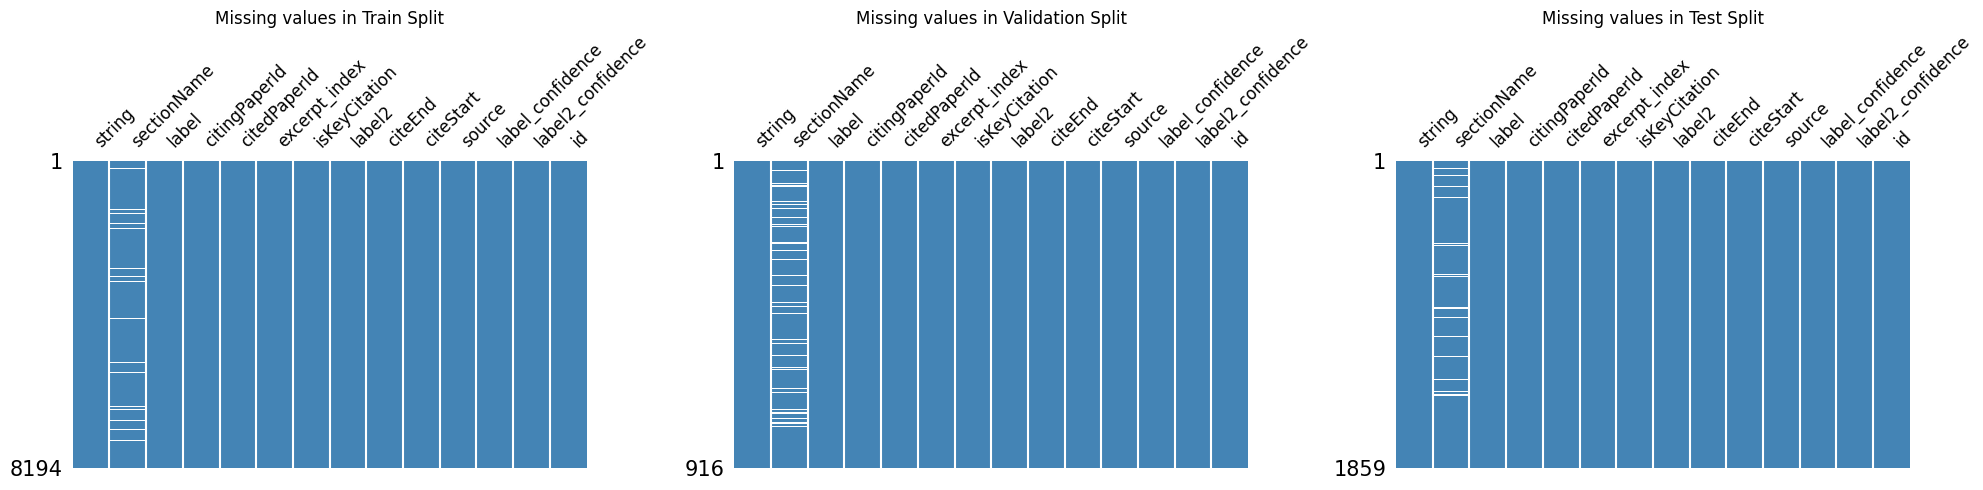

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    df = pd.DataFrame(dataset[split])
    # Conversion of empty cells into np.nan
    df.replace({"": np.nan, " ": np.nan}, inplace=True)
    # Find missing values
    missing_values = df.isna().sum().sum()
    print(f"Missing values in {split.capitalize()}: {missing_values}")
    # Visualizing the missing values with missingno library
    print(f"Missing values in {split.capitalize()} Split:")
    msno.matrix(df, ax=axs[i], sparkline=False, fontsize=12, color=(0.27, 0.52, 0.71))
    axs[i].set_title(f'Missing values in {split.capitalize()} Split')

plt.tight_layout()
plt.show()

From this dataset, we are mainly interested in seeing how to deal with string, sectionName, and label columns. All the other information can be discarded because are not useful for the task.

## 2. Brief discussion: PLMs and SOTA

The Citation Intent Classification task has been studied intensively, and the current state of the art is a Macro-F1 score of 88.93 obtained with an XLNet based model ([SOTA page](https://paperswithcode.com/sota/citation-intent-classification-on-scicite)). Other methodologies, like embedding based analyses, together with LSTM based approaches, show a much lower performance.

As you can imagine, the task can be tackled from very different perspectives, we could use prompt-tuning, fine-tuning, zero-shot, few-shot, sentence-transformer based similarity, and so on... But, for the aim of this project, I'd like to go deeper on the scores we can obtain by using an ensemble based approach, and see whether or not it will outperform the scores obtained with task specific fine-tuning. Additionally, I'd like to investigate the impact that a mix of feature and prompt engineering, correctly applied to these PLMs could have.

In order to move our first steps into the task, we must first decide which model we would like to use. To make such decision, I have a list of candidate PLMs.

The models I will take into consideration are the following:
- <b>SciBERT</b>: A BERT based model trained on a corpus of scientific texts. Its main advantages is its good understanding of the scientific domain and the SciVocab, a newly designed vocabulary containing a great number of terms from the scientific literature - [Reference Paper](https://arxiv.org/abs/1903.10676);
- <b>XLNet</b>: A model presenting an evolution of the way in which LMs are trained for Language Understanding tasks. As said before, it is also the current base-model of SOTA results for this task - [Reference Paper](https://arxiv.org/abs/1906.08237);
- <b>Galactica</b>: A big open source science based language model from META. It is a controversial model for the results it has obtained in text generation tasks, but it is now back on track - [Reference Paper](https://arxiv.org/abs/2211.09085).

Each of these models could be particularly suited for the task.

## 3. SciBERT_uncased Fine-Tuning
In this section, I will tackle the problem with the raw fine-tuning of the SciBERT model on the SciCite dataset.

Fine tuning is an approach that involves changing the weights of the PLM to adapt it to a new task. Additionally, the process involves the use of a classification head in this specific case. Such head is useful to classify, by means of the logits of the model, its answers into either one of the three possible classes.

For this part, I will solely rely on Huggingface for fine tuning and Ray Tune for hyperparameter optimization.

Below, you can see and inspect SciBERT configuration.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ckp = "allenai/scibert_scivocab_uncased"
model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3)
model.to(device)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
layer_count=0
for layer in model.bert.encoder.layer:
    layer_count+=1
    print(layer)

print(layer_count)

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (qu

#### 3.a) Tokenization and Model download

The tokenization part is mostly carried out by the AutoTokenizer object of  Huggingface. What we need to do is simply load the tokenizer we want to use, and then define a mapping function to the dataset.

For what concerns the model download, the same is true. We can easily rely on huggingface to download the model we want to use, and add a mapping from labels to numerical values of them.

#### 3.b) Ray Tune for HP optimization

To optimize the search in the HP space, we will make use of ray tune library. This library gives us the possibility to define in high details the way in which we want to perform such search.

<b><u>"Unfortunately", seen the dimension of these PLMs, I will need to define each of the steps I am describing inside a single function, otherwise Ray Tune wouldn't be able to correctly handle GPU RAM.</b></u>

For what concerns the task specific Fine-Tuning, I would like to make use of some prompt and feature engineering on the sentences that the model will need to classify. Additionally, I will implement a Population Based Search for HP optimization.

The main HP I will deal with are the following:
- Learning Rate;
- Weighted loss or non-weighted loss (since the dataset is higly imbalanced, a weighted loss could, or not, help);
- Weight decay for the optimizer;
- Batch size.

Additionally, these models are highly sensible to weights initialization and data order, which may result in drastically different performances, as stated in [Fine-Tuning Pretrained Language Models:
Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/pdf/2002.06305v1.pdf). Thus, searching also through the seeds could be a good idea but, for memory and efficiency requirements, I will manually set a pre-defined seed.

#### 3.c) Training loop

Inside the main function, that you will see below, I have implemented a particular training loop.

This is not the standard training suggested for PLMs fine tuning (which is way less flexible...), I have implemented an early stopping condition to deal with the fact that such PLMs heavily tends to overfit. Moreover, since the problem of overfitting is real, I will save the model with the best generalization performance in terms of validation loss at each step, to finally retrieve the best performing overall.

Additionally, seen that PLMs need really low learning rate values in their fine tuning, they risk many times to get stuck. Thus, instead of opting for a linear decrease of the learning rate through epochs, I found way better results with a static reduction of the learning rate when the model gets stuck in a plateau.

Since the number of epochs needed for PLMs is relatively low (around 5 epochs at most, or they will for sure overfit...), I have decided to add a fine-grained evaluation of generalization performances. This means that the model will look into validation data more than once during each epoch, and these data are used to implement LR reduction and Early Stopping.

Finally, to speed up the fine tuning process, I have used mixed precision training thanks to Autocast and GradScaler. The former is useful to perform forward and backward passes at half precision (float16 instead of float32), thus reducing memory requirements and speeding up the process, while the latter serves to purpose of mitigating numerical instability issues due to the half precision. With this strategy, we are in the end able to obtain more or less the same results but with a significantly lower use of resources and with a training that requires less than a half of the time that a normal loop would need.

#### 3.d) Implementation

Below I implement and describe through comments all the steps I have discussed above.

In [ ]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from ray import tune, train
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import tempfile
from ray.train import Checkpoint


def train_model(config):
    dataset = load_dataset("allenai/scicite", trust_remote_code=True)

    # Use config from ray Tune
    ckp = config["model_ckp"]
    loss_balance = config["loss_balance"]
    seed = config["seed"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    ray_checkpoint_interval = config['ray_checkpoint_interval']
    tokens_max_length = config["tokens_max_length"]

    # Here I define the mapping from numerical to string labels, and viceversa
    # This is useful for Huggingface automodel
    id2label = {0: "method", 1: "background", 2: "result"}
    label2id = {"method": 0, "background": 1, "result": 2}

    # Download the model from the checkpoint of SciBERT, and move it on GPU
    model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

    num_layers_to_freeze = 3
    for layer in model.bert.encoder.layer[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False

    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    # Load SciBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckp)

    # The function below defines the tokenization process
    def tokenize_function(examples):
        augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
        tokenized = tokenizer(augmented, max_length=tokens_max_length, padding='max_length', truncation=True)
        tokenized['augmented'] = augmented
        return tokenized

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Define train and validation sets according to the standard splits
    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=128)

    # It is good norm to not applying weight decay to the following two layers if present
    # I will check if they are in the model and in case set their weight decay to 0
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    # Define the optimizer and the scheduler
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.75, min_lr=8e-7, cooldown=2, verbose=True)

    batch_counter = 0
    # Accumulation steps are only useful if the GPU is not sufficiently big,
    # in this case I leave it to 1, so it is like if it is not here
    accumulation_steps = 1
    validation_interval = ray_checkpoint_interval
    step_counter = 0
    evaluation_counter = 0

    # Set extreme values to have checkpointing
    best_val_loss = float('inf')
    best_val_f1 = float('-inf')

    scaler = GradScaler()

    no_improvement = 0
    early_stopping_patience = 8 # Number of evaluations without performance improvement before stopping

    start_epoch = 0
    last_batch_index = 0

    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        print("GETTING BACK CHECKPOINT AFTER PAUSED TRAINING")
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        step_counter = checkpoint_dict["step"]
        best_val_loss = checkpoint_dict["best_val_loss"]
        evaluation_counter = checkpoint_dict["performed_evaluation"]
        scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

        # Give a cooldown step
        no_improvement = checkpoint_dict["no_improvement_steps"]
        if no_improvement >= 1:
            no_improvement-=1

        start_epoch = checkpoint_dict["last_epoch_index"]
        last_batch_index = checkpoint_dict["last_batch_index"]
        print(f"Resuming training from Epoch {start_epoch}, Batch Index: {last_batch_index}")
        metrics = checkpoint_dict["metrics"]

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        optimizer.zero_grad()

        for batch_index, batch in enumerate(train_dataloader):
            if epoch == start_epoch and batch_index < last_batch_index:
                continue  # Skip batches up to checkpoint

            batch = {k: v.to(device) for k, v in batch.items()}
            # Mixed precision below
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            # This below should ensure that the same amount of data has been seen by the model
            # even if it has the smallest batch size (16) between the searched ones.
            # This is useful to have a meaningful comparison of val_loss at the evaluation time,
            # because both bs=32 and bs=16 models should have seen the same amount of data.
            if batch_size==16:
                step_counter += 0.5
            else:
                step_counter += 1

            # Evaluation on Validation data + Ray Checkpoint creation
            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches
                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement = 0
                else:
                    no_improvement += 1

                evaluation_counter += 1

                if no_improvement >= early_stopping_patience:
                    print("No improvement in validation loss for {} evaluations, stopping.".format(early_stopping_patience))
                    train.report(metrics)
                    break

                scheduler.step(val_loss)
                intermediate_train_loss = train_loss/num_train_batches

                metrics = {"training_iteration":step_counter, "performed_evaluation":evaluation_counter, "best_val_loss": best_val_loss, "train_loss":intermediate_train_loss, "current_val_loss":val_loss, "current_val_f1":val_f1}

                # Checkpointing with Ray Tune/Train
                with tempfile.TemporaryDirectory() as tmpdir:
                    torch.save(
                        {
                            "performed_evaluation": evaluation_counter,
                            "step": step_counter,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "best_val_loss": best_val_loss,
                            "no_improvement_steps": no_improvement,
                            "scheduler_state_dict": scheduler.state_dict(),
                            "last_batch_index": batch_index,
                            "last_epoch_index": epoch,
                            "metrics": metrics
                        },
                        os.path.join(tmpdir, "checkpoint.pt"),
                    )
                    train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir)) # tmpdir
                    print(f"Checkpoint stored at Epoch:{epoch}, Batch:{batch_index} - batch size:{batch_size}")

        if no_improvement >= early_stopping_patience:
            break

        train.report(metrics)
        print(f"EPOCH {epoch} finished")


Below I define the configuration, as well as the population based training. Finally, I start the training process, of which you will be able to see the results under the cell.

In [ ]:
seeds = [1482]
"""
For simplicity, here I will consider a single seed, without performing any kind of search.
Normally, the seed do not need to be searched, but, according to https://arxiv.org/pdf/2002.06305v1.pdf
in a LLM, a different weight initialization, and data order, can higly impact the performances of the
fine tuned model.
"""
# After evaluation_interval batches (depending on batch_size, if 32 is 30, if 16 is 60) -> I consider step_counter as time_attr
evaluation_interval = 30

# Define configuration space
config = {
    "num_epochs": 5,
    "batch_size": tune.grid_search([16, 32]),
    "seed": tune.grid_search(seeds),
    "lr": tune.uniform(1e-5, 2e-5), # These are the recommended learning rates for similar tasks
    "weight_decay": tune.uniform(0.02, 0.01), # Weight decay may highly influence the final results
    "model_ckp": ckp,
    "loss_balance": False, #tune.grid_search([True, False]),
    "tokens_max_length": tune.grid_search([256, 312]),
    "ray_checkpoint_interval": evaluation_interval
}

For the population based training, I have defined a perturbation interval every 30 steps. This means that, after 30 evaluations on validation data for each possible model, the worst (also called explorers) will be randomly mutated according to the parameters defined below. Thus, their learning rate, or weight decay, could be changed in the range defined. Additionally, these modified explorers will be re-trained from zero up to 2x number of perturbation interval (so for 60 evaluations), and the process is repeated.

The best performing models, called exploiters, are then modified according to the best performing explorers in a random way. Finally, the worst performing HP are discarded and the ones that gave best results replace them in following iterations.

This process of "evolution" goes on until all the models have completed their training.

Usually, with Population Based Training (PBT), models converge faster and a broader HP search space is explored. Unfortunately, since I am running this on single GPU on Colab platform, the process is pretty slow because training cannot be parallelized.

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=evaluation_interval*8,
    metric="best_val_loss",
    mode="min",
    #burn_in_period=120.0, # Number of training steps before starting with Exploitation/Exploration process
    quantile_fraction=0.5,
    resample_probability=0.3,
    perturbation_factors=(1.15,0.85),
    hyperparam_mutations={
        "lr": tune.uniform(9e-6, 3e-5),
        "weight_decay": tune.uniform(0.001, 0.03),
    },
    synch=True
)

In [ ]:
import time

start_time = time.time()

if ray.is_initialized():
    ray.shutdown()
ray.init()

# This tune.with_resources is basically the same of resources_per_trial
# So this is allocating 3 CPUs and 1/4 GPU for trial, making it possible to
# train more model in parallel (Slows a bit the performances but it's ok)
train_model_with_resources = tune.with_resources(train_model, {"cpu": 3, "gpu":0.25})

tuner = tune.Tuner(
    train_model_with_resources, #train_model,
    run_config=train.RunConfig(
        name="SciBERT_PBT_Uncased",
        stop={"training_iteration": 800}, # a bit more than 3 epochs
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="best_val_loss",
            checkpoint_score_order="min",
            num_to_keep=6,
        ),
        storage_path="/content/tmp/ray_results", #"/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Ray_PBT_Checkpoints", # "/tmp/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2,
    ),
    param_space=config,
)

results_grid = tuner.fit()
end_time = time.time()

2024-01-21 11:12:21,395	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-21 11:12:22,876	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     SciBERT_PBT_Uncased     |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        PopulationBasedTraining |
| Number of trials                 8                       |
+----------------------------------------------------------+

View detailed results here: /content/tmp/ray_results/SciBERT_PBT_Uncased
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/SciBERT_PBT_Uncased`

Trial status: 8 PENDING
Current time: 2024-01-21 11:12:23. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length 

(train_model pid=2302) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2302) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2300) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
vocab.txt: 100%|██████████| 228k/228k [00:00<00:00, 34.0MB/s]
Map:  98%|█████████▊| 8000/8194 [00:02<00:00, 3658.39 examples/s]
(train_model pid=2301) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight'] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:12:53. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256 |
| train_model_f34bc_00001   RUNNING    1.60415e-05        0.0121374             32     1482                   256 |
| train_model_f34bc_00002   RUNNING    1.52899e-05        0.019412              16     1482                   312 |
| train_model_f34bc_00003   RUNNING    1.83255e-05        0.0192756             32     1482                   312 |
| train_mod

(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000000)
Map: 100%|██████████| 8194/8194 [00:02<00:00, 3494.75 examples/s] [repeated 3x across cluster]


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:13:23. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256                                      

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:29 - batch size:32
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000000)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:13:53. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256       30            60.5005         

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000001) [repeated 3x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:59 - batch size:32 [repeated 3x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000001)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:14:23. Total running time: 2min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011     

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000002) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:89 - batch size:32 [repeated 2x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000002)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000002)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:14:53. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011    

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000003) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:119 - batch size:32 [repeated 2x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000003)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:15:23. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      120            166.357          

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:299 - batch size:16 [repeated 3x across cluster]


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000004) [repeated 3x across cluster]


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000005)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:15:56. Total running time: 3min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      150            186.042         

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000004)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:299 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000005)
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:359 - batch size:16 [repeated 2x across cluster]
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:16:26. Total running time: 4min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:209 - batch size:32

Trial train_model_f34bc_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01975 |
+---------------------------------------------------------------+


(train_model pid=2301) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2301) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000006) [repeated 2x across cluster]



Trial status: 4 RUNNING | 1 PAUSED | 3 PENDING
Current time: 2024-01-21 11:16:56. Total running time: 4min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      210            255.

Map: 100%|██████████| 916/916 [00:00<00:00, 5229.43 examples/s]
(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01702 |
+---------------------------------------------------------------+


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01718 |
+---------------------------------------------------------------+


(train_model pid=2300) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=2300) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:  54%|█████▍    | 1000/1859 [00:00<00:00, 6628.93 examples/s]



Trial train_model_f34bc_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01559 |
+---------------------------------------------------------------+


Map: 100%|██████████| 1859/1859 [00:00<00:00, 6574.62 examples/s]
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)
Map: 100%|██████████| 1859/1859 [00:01<00:00, 992.49 examples/s] 
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:59 - batch size:16 [repeated 2x across cluster]


(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 4686.89 examples/s]
(train_model pid=2302) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/1859 [00:00<?, ? examples/s]
(train_model pid=2302) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
Map: 100%|██████████| 1859/1859 [00:00<00:00, 5377.84 examples/s]



Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:17:26. Total running time: 5min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256       30            29.1147          

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000001)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:17:56. Total running time: 5min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256       60            49.0948          

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:59 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000002) [repeated 3x across cluster]
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:119 - batch size:16 [repeated 3x across cluster]
Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:18:26. Total running time: 6min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.949

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000002)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:119 - batch size:32 [repeated 3x across cluster]


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000003) [repeated 2x across cluster]


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:18:56. Total running time: 6min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      120           121.572           

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000002)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:89 - batch size:32
(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000004)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:19:26. Total running time: 7min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      150            153.051           

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000004)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:119 - batch size:32
(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000005)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:19:56. Total running time: 7min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      180            177.821          

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000004)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000006) [repeated 2x across cluster]


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:419 - batch size:16 [repeated 2x across cluster]
Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:20:26. Total running time: 8min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.949

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000007) [repeated 2x across cluster]
(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000007)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 11:20:56. Total running time: 8min 33s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00006   RUNNING    1.76424e-05        0.0171768             16     1482                   312      180            208.738           

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:419 - batch size:16 [repeated 2x across cluster]
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 11:21:26. Total running time: 9min 3s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00006   RUNNING    1.7642

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000007) [repeated 2x across cluster]
2024-01-21 11:21:27,513	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial f34bc_00000 (score = -0.359101) into trial f34bc_00007 (score = -0.394492)

2024-01-21 11:21:27,514	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialf34bc_00007:
lr : 1.983824614281347e-05 --- (* 0.85) --> 1.686250922139145e-05
weight_decay : 0.016101105114407037 --- (resample) --> 0.010604106903788046

2024-01-21 11:21:27,518	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial f34bc_00006 (score = -0.354035) into trial f34bc_00005 (score = -0.392237)

2024-01-21 11:21:27,519	INFO pbt.py:905 -- 

[PopulationBasedTraining


Trial train_model_f34bc_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                           0.0161 |
+---------------------------------------------------------------+


(train_model pid=2303) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.02788 |
+---------------------------------------------------------------+


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=5091) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=2303) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:209 - batch size:32

Trial train_model_f34bc_00002 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00002 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01941 |
+

(train_model pid=5158) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=2303) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=5091) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=5091) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_f34bc_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                           0.0165 |
+---------------------------------------------------------------+
(train_model pid=2303) EPOCH 0 finished
(train_model pid=5091) GETTING BACK CHECKPO

(train_model pid=5158) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=5235) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=5091) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=5158) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=5091) EPOCH 0 finished
(train_model pid=5158) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5235) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']


(train_model pid=5235) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


2024-01-21 11:21:51,877	WARNING util.py:202 -- The `on_step_begin` operation took 2.051 s, which may be a performance bottleneck.


(train_model pid=5158) Resuming training from Epoch 0, Batch Index: 479

Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:21:56. Total running time: 9min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.016101

(train_model pid=5235) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5158) EPOCH 0 finished
(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:22:26. Total running time: 10min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_0

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:145 - batch size:16 [repeated 3x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


2024-01-21 11:22:53,601	WARNING util.py:202 -- The `on_step_begin` operation took 0.686 s, which may be a performance bottleneck.


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:22:56. Total running time: 10min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      330            350.

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000009)
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:23:26. Total running time: 11min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:145 - batch size:16 [repeated 2x across cluster]


2024-01-21 11:23:34,827	WARNING util.py:202 -- The `on_step_begin` operation took 0.769 s, which may be a performance bottleneck.
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=2303) Epoch 00014: reducing learning rate of group 0 to 1.4879e-05.
(train_model pid=2303) Epoch 00014: reducing learning rate of group 1 to 1.4879e-05.


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:23:56. Total running time: 11min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000011)
(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:205 - batch size:16 [repeated 2x across cluster]


2024-01-21 11:24:08,412	WARNING util.py:202 -- The `on_step_begin` operation took 2.450 s, which may be a performance bottleneck.
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000012) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 2x across cluster]
(train_model pid=5091) Epoch 00014: reducing learning rate of group 0 to 1.3232e-05.
(train_model pid=5091) Epoch 00014: reducing learning rate of group 1 to 1.3232e-05.
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:24:26. Total running time: 12min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=5235) Epoch 00014: reducing learning rate of group 0 to 1.1467e-05.
(train_model pid=5235) Epoch 00014: reducing learning rate of group 1 to 1.1467e-05.
(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000012)
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:325 - batch size:16 [repeated 2x across cluster]
(train_model pid=5158) Epoch 00014: reducing learning rate of group 0 to 1.1467e-05.
(train_model pid=5158) Epoch 00014: reducing learning rate of group 1 to 1.1467e-05.

Trial train_model_f34bc_00000 completed after 450.0 iterations at 2024-01-21 11:24:49. Total running time: 12min 26s
+--------------------------------------------------+
| Trial train_model_f34bc_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          7.7644 |
| time_total_s                             479.165 |
| training_iteration                           450 |
| best_val_loss                             0.3591 |
| current_val_f1                           0.82643 |
| current_val_loss                         0.41135 |
| performed_evaluation                          15 |
| train_loss         

(train_model pid=2303) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=2303) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:325 - batch size:16

Trial status: 1 TERMINATED | 4 RUNNING | 1 PENDING | 2 PAUSED
Current time: 2024-01-21 11:24:56. Total running time: 12min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00001   RUNNING  

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
Trial status: 1 TERMINATED | 4 RUNNING | 1 PENDING | 2 PAUSED
Current time: 2024-01-21 11:25:27. Total running time: 13min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00001   RUNNING    

(train_model pid=5091) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=5091) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=5091) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_f34bc_00003 completed after 450.0 iterations at 2024-01-21 11:25:33. Total running time: 13min 10s
+--------------------------------------------------+
| Trial train_model_f34bc_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         5.65012 |
| time_total_s                             517.853 |
| training_iteration                           450 |
| best_val_loss                            0.36399 |
| current_val_f1                           0.84416 |
| current_val_loss                         0.38824 |
| performed_evaluation                          15 |
| train_loss                               0.25144 |
+--------------------------------------------------+

Trial train_model_f34bc_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00006 config                          |
+-

(train_model pid=5235) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_f34bc_00002 completed after 450.0 iterations at 2024-01-21 11:25:40. Total running time: 13min 17s
+--------------------------------------------------+
| Trial train_model_f34bc_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.73471 |
| time_total_s                             528.223 |
| training_iteration                           450 |
| best_val_loss                            0.36399 |
| current_val_f1                           0.84416 |
| current_val_loss                         0.38824 |
| performed_evaluation                          15 |
| train_loss                               0.25144 |
+--------------------------------------------------+
(train_model pid=5158) No improvement in validation loss for 8 evaluations, stopping.

Trial train_model_f34bc_000

2024-01-21 11:25:40,408	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_f34bc_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.restore() (pid=5158, ip=172.28.0.12, actor_id=6b91bb3608a343779c2ac52501000000, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 556, in restore
    raise ValueError(
ValueError: Co


Trial train_model_f34bc_00007 errored after 240 iterations at 2024-01-21 11:25:40. Total running time: 13min 17s
Error file: /root/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/error.txt
+------------------------------------------------------------+
| Trial train_model_f34bc_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  17.56808 |
| time_total_s                                     249.98472 |
| training_iteration                                     240 |
| best_val_loss                                      0.39449 |
| current_val_f1                                      0.8265 |
| current_val_loss                                   0.40714 |
| performed_evaluation                                     8 |
| train_los

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000009) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=5235) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=5235) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=5091) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=5235) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=5091) EPOCH 0 finished
(train_model pid=5235) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:145 - batch size:16

Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:25:57. Total running time: 13min 34s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING      1.94977e-

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5235) EPOCH 0 finished
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000011) [repeated 2x across cluster]


Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:26:27. Total running time: 14min 4s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING      1.94977e-05        0.0197524             16     1482                   256      360       

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:85 - batch size:16 [repeated 2x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=2303) Epoch 00014: reducing learning rate of group 0 to 1.4623e-05.
(train_model pid=2303) Epoch 00014: reducing learning rate of group 1 to 1.4623e-05.
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:145 - batch size:16
Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:26:57. Total running time: 14min 34s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+---------------------------------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:27:27. Total running time: 15min 4s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000011) [repeated 2x across cluster]


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 2x across cluster]

Trial train_model_f34bc_00004 completed after 450.0 iterations at 2024-01-21 11:27:57. Total running time: 15min 34s
+--------------------------------------------------+
| Trial train_model_f34bc_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         6.28395 |
| time_total_s                             424.153 |
| training_iteration                           450 |
| best_val_loss                            0.35612 |
| current_val_f1                           0.84205 |
| current_val_loss                         0.40477 |
| performed_evaluation                          15 |
| train_loss                               0.24403 |
+--------------------------------------------------+
(train_model pid=2303) No improvement in validation loss for 8 evaluations, stopping.

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=5235) Epoch 00014: reducing learning rate of group 1 to 1.3232e-05. [repeated 2x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
Trial status: 5 TERMINATED | 2 RUNNING | 1 ERROR
Current time: 2024-01-21 11:28:27. Total running time: 16min 4s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00005   RUNNING      1.90507e-05 

2024-01-21 11:28:35,846	ERROR tune.py:1038 -- Trials did not complete: [train_model_f34bc_00007]


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_f34bc_00006 completed after 450.0 iterations at 2024-01-21 11:28:35. Total running time: 16min 12s
+--------------------------------------------------+
| Trial train_model_f34bc_00006 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.76196 |
| time_total_s                             436.863 |
| training_iteration                           450 |
| best_val_loss                            0.35404 |
| current_val_f1                           0.83427 |
| current_val_loss                         0.40371 |
| performed_evaluation                          15 |
| train_loss                               0.24626 |
+--------------------------------------------------+

Trial status: 7 TERMINATED | 1 ERROR
Current time: 2024-01-21 11:28:35. Total running time: 16min 12s
Logical res

Extract best model, and print out search results.

In [ ]:
from ray.train import Result

# Function to convert elapsed time in seconds to minutes and seconds
def convert_seconds_to_minutes_seconds(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return minutes, remaining_seconds

elapsed_time = end_time - start_time  # Calculate the elapsed time
minutes, seconds = convert_seconds_to_minutes_seconds(elapsed_time)
print(f"Time taken: {minutes} minutes and {seconds} seconds")


num_results = len(results_grid)
print("Number of results:", num_results)
# Check if there have been errors
if results_grid.errors:
    print("At least one of the trials failed!")
else:
    print("No errors!")

# Iterate over results
for i, result in enumerate(results_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a validation loss of:",
        result.metrics["current_val_loss"],
        " and the best validation loss through the training has been:",
        result.metrics["best_val_loss"]
    )


# Get the result with the maximum test set `mean_accuracy`
best_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="min"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="max"
)

Time taken: 16.0 minutes and 16.64460325241089 seconds
Number of results: 8
At least one of the trials failed!
Trial #0 finished successfully with a validation loss of: 0.4113522954285145  and the best validation loss through the training has been: 0.35910115763545036
Trial #1 finished successfully with a validation loss of: 0.40371448546648026  and the best validation loss through the training has been: 0.3540354371070862
Trial #2 finished successfully with a validation loss of: 0.38823990523815155  and the best validation loss through the training has been: 0.36398913338780403
Trial #3 finished successfully with a validation loss of: 0.38823990523815155  and the best validation loss through the training has been: 0.36398913338780403
Trial #4 finished successfully with a validation loss of: 0.40476758778095245  and the best validation loss through the training has been: 0.35611891001462936
Trial #5 finished successfully with a validation loss of: 0.40371448546648026  and the best vali

Retrieve final HP configuration of the best model.

In [ ]:
print("Best model - final configuration after HP perturbations:\n")
tokenizer_length = best_result.config['tokens_max_length']
best_result.config

Best model - final configuration after HP perturbations:



{'num_epochs': 5,
 'batch_size': 16,
 'seed': 1482,
 'lr': 2.0288708364037887e-05,
 'weight_decay': 0.02788212025776536,
 'model_ckp': 'allenai/scibert_scivocab_uncased',
 'loss_balance': False,
 'tokens_max_length': 312,
 'ray_checkpoint_interval': 30}

Plot experiments results to see convergence.

<Figure size 30000x15000 with 0 Axes>

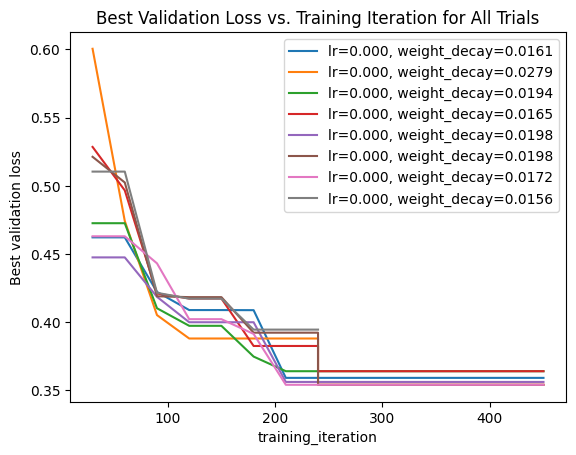

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 150))

ax = None
for result in results_grid:
    label = f"lr={result.config['lr']:.3f}, weight_decay={result.config['weight_decay']:.4f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "best_val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "best_val_loss", ax=ax, label=label)

ax.set_title("Best Validation Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Best validation loss")
plt.show()  # Display the plot


As you might have noticed, the PBT is not exactly correct: it doesn't re-use models but re-starts training for all models without considering to continue any of them. This is due to the difficulty in providing a working trainable object with this particular train loop.

The positive thing about it is that it ensures HP perturbations and that it maintains only the best performing HP.

#### 3.e) Performance assessment and evaluation

Below, I will assess the performances of the best model obtained above on the test set.

In [ ]:
# Load the best fine tuned model and move it to GPU
id2label = {0: "method", 1: "background", 2: "result"}
label2id = {"method": 0, "background": 1, "result": 2}

best_model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model_state_dict = checkpoint['model_state_dict']  # Extract only the model's state dictionary
    best_model.load_state_dict(model_state_dict)

best_model = best_model.to(device)

full_model_path = "/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Uncased/SciBERT_uncased_ft.pt"
torch.save(best_model.state_dict(), full_model_path)

print(f"Model saved to {full_model_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Uncased/SciBERT_uncased_ft.pt


Tokenize.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=tokenizer_length, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])#, 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
# Test dataset and dataloader
test_dataset = tokenized_datasets["test"]
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In [ ]:
###############################################################################
########################### Performance assessment ############################
###############################################################################
from tqdm.auto import tqdm

predictions_list = []
labels_list = []

best_model.eval() # Set the model to evaluation mode
test_loss = 0.0
num_test_batches = 0

test_progress_bar = tqdm(eval_dataloader, desc="Evaluating on Test Set")

with torch.no_grad():  # Disable gradient computation
    for batch in test_progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)
        loss = outputs.loss

        test_loss += loss.item()
        num_test_batches += 1

        # Store predictions and labels
        preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
        predictions_list.extend(preds)
        labels_list.extend(batch["labels"].cpu().numpy())

        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")

# Calculate F1 score and accuracy using the stored predictions and labels
test_f1 = f1_score(labels_list, predictions_list, average="macro")
test_f1_none = f1_score(labels_list, predictions_list, average=None)
test_acc = accuracy_score(labels_list, predictions_list)

print(f"Test F1: {test_f1:.4f}, Test_f1_None: {test_f1_none} Test Acc: {test_acc:.4f}")
#was 86.50 macro-f1

Evaluating on Test Set:   0%|          | 0/15 [00:00<?, ?it/s]

Test Loss: 0.3218
Test F1: 0.8706, Test_f1_None: [0.8976249  0.89613035 0.81801126] Test Acc: 0.8854


## 4. Ensemble model

#### 4.a) Introduction to the methodology

In order to develop an ensemble model we first need to produce some base models capable of carrying out a part of the entire classification task. To this aim, I will build three different binary classifiers, each of which trained in recognizing whether a specific sentence can or cannot be classified as being part of a specific class.

In the end, I will obtain three binary classifiers:
- Background based model: aimed at correctly classifying whether a sentence is of type background or not;
- Method based model: aimed at correctly classifying whether a sentence is of type method or not;
- Result based model: aimed at correctly classifying whether a sentence is of type result or not.

Once I have the final predictions made by the models, I will use them as input to an ensemble classifier, for which I will inspect different possibilities.

#### 4.b) Base functions

Here, I define the basic functions useful to map labels to their binary counterpart.

In [ ]:
def background_transform_labels(example):
    if example['label'] == 1:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 2]:
        example['label'] = 0  # 'no'
    return example

def method_transform_labels(example):
    if example['label'] == 0:
        example['label'] = 1  # 'yes'
    elif example['label'] in [1, 2]:
        example['label'] = 0  # 'no'
    return example

def result_transform_labels(example):
    if example['label'] == 2:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 1]:
        example['label'] = 0  # 'no'
    return example

Now, we need a training loop for these binary classifiers we aim at building. For these base models, I will not make use of Hyperparameter search strategies. The loop below is based on the same theoretical information given above (scaled, fine-grained eveluation...).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, class_weights_tensor, train_dataloader, val_dataloader, model_path):
    loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Replace StepLR with ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.2, cooldown=8, verbose=True)

    num_epochs = 5
    batch_counter = 0
    accumulation_steps = 1
    validation_interval = 10
    step_counter = 0

    best_val_loss = float('inf')
    best_model_path = model_path # 'background_model_loss.pt'
    best_val_f1 = float('-inf')
    #best_model_f1_path = 'background_model_f1.pt'

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    no_improvement = 0
    early_stopping_patience = 50  # Number of evaluations with no improvement after which training will be stopped

    for epoch in range(num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        optimizer.zero_grad()

        for batch in epoch_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Use autocast for mixed precision
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Use scaler for backward
            scaler.scale(loss).backward()

            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            epoch_progress_bar.set_postfix({"train_loss": train_loss / num_train_batches})

            step_counter += 1

            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision
                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches

                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")
                val_acc = accuracy_score(val_labels_list, val_predictions_list)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    #torch.save(model_background.state_dict(), best_model_f1_path)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= early_stopping_patience:
                        print("No improvement in validation loss for {} steps, stopping.".format(early_stopping_patience))
                        break

                scheduler.step(val_loss)

                print(f"Step {step_counter}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")
                print(f"Best Val Macro-F1: {best_val_f1:.4f}")

                model.train()

        if no_improvement >= early_stopping_patience:
            break

        train_loss /= num_train_batches

        train_f1 = f1_score(train_labels_list, train_predictions_list, average="macro")
        train_acc = accuracy_score(train_labels_list, train_predictions_list)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}")

Finally, I write a function to compute class weights.

In [ ]:
def compute_weight_tensor(tokenized_datasets):
    label_counts = Counter(tokenized_datasets['train']['label'])
    # Calculate weights
    class_weights = {k: 1.0 / v for k, v in label_counts.items()}
    # Normalize weights such that the sum of weights equals the number of classes
    total_weights = sum(class_weights.values())
    class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}
    # Transform the dict to a tensor and give it to device
    class_weights_tensor = torch.tensor([class_weights[i] for i in [0, 1]], dtype=torch.float).to(device)
    return class_weights_tensor

Now, we can go inside the specificity of each particular binary classifiers, each of which will make use of different weight for loss balance, and will work on different dataloaders.

#### 4.c) Base models

The operations for each model will be basically the same but with different objects and computations. Thus, I will explain them in detail only for their first appeareance.

First of all, let's download the dataset again and set the GPU device.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

if torch.cuda.is_available():
    print('cuda')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for allenai/scicite contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/scicite
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


cuda


Let's map the labels to the binary case thanks to the functions defined in the previous section.

In [ ]:
background_datasets = dataset.map(background_transform_labels)
method_datasets = dataset.map(method_transform_labels)
result_datasets = dataset.map(result_transform_labels)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Now, let's compute all the weights to balance the loss function.

In [ ]:
background_weight_tensor = compute_weight_tensor(background_datasets)
method_weight_tensor = compute_weight_tensor(method_datasets)
result_weight_tensor = compute_weight_tensor(result_datasets)

Now, we can define the various dataloaders. But, before, we write a function to carry on the tokenization part.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_dataloader(dataset, batch_size, seed=None):
    if seed is not None:
        set_seed(seed)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader

batch_size = 32
random_seed = 1482

background_train_dataloader, background_val_dataloader = prepare_dataloader(background_datasets, batch_size, seed=random_seed)
method_train_dataloader, method_val_dataloader = prepare_dataloader(method_datasets, batch_size, seed=random_seed)
result_train_dataloader, result_val_dataloader = prepare_dataloader(result_datasets, batch_size, seed=random_seed)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

It is important to notice that I will not use at all the test set with the base models. The first time the test set will be used is with the ensemble classifier.

##### <b>Background model</b>

Now, it is time to define the base models I will use for the ensemble classifier. Let's start with the Background model.

The steps will be the same for each model, so I will not repeat what I do.

The main part consists of a mapping between integer and literal labels. Such map must be fed to the PLM I will use, during the loading.

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_background = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_background = model_background.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we can procede with the training. In order to do that, I will use the above defined training loop function.

In [ ]:
train_model(model_background, background_weight_tensor, background_train_dataloader, background_val_dataloader, "background_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.4828, Val F1: 0.7837, Val Acc: 0.7959
Best Val Loss: 0.4828
Best Val Macro-F1: 0.7837
Step 20, Val Loss: 0.4322, Val F1: 0.8008, Val Acc: 0.8111
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 30, Val Loss: 0.4853, Val F1: 0.7876, Val Acc: 0.7893
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 40, Val Loss: 0.4440, Val F1: 0.7930, Val Acc: 0.8133
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 50, Val Loss: 0.3693, Val F1: 0.8327, Val Acc: 0.8395
Best Val Loss: 0.3693
Best Val Macro-F1: 0.8327
Step 60, Val Loss: 0.3585, Val F1: 0.8347, Val Acc: 0.8417
Best Val Loss: 0.3585
Best Val Macro-F1: 0.8347
Step 70, Val Loss: 0.3600, Val F1: 0.8344, Val Acc: 0.8439
Best Val Loss: 0.3585
Best Val Macro-F1: 0.8347
Step 80, Val Loss: 0.3579, Val F1: 0.8449, Val Acc: 0.8515
Best Val Loss: 0.3579
Best Val Macro-F1: 0.8449
Step 90, Val Loss: 0.3819, Val F1: 0.8312, Val Acc: 0.8428
Best Val Loss: 0.3579
Best Val Macro-F1: 0.8449
Step 100, Val Loss: 0.3461, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.3407, Val F1: 0.8560, Val Acc: 0.8624
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 270, Val Loss: 0.3435, Val F1: 0.8573, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 280, Val Loss: 0.3427, Val F1: 0.8607, Val Acc: 0.8646
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 290, Val Loss: 0.3424, Val F1: 0.8583, Val Acc: 0.8624
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 300, Val Loss: 0.3428, Val F1: 0.8549, Val Acc: 0.8592
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 310, Val Loss: 0.3441, Val F1: 0.8584, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 320, Val Loss: 0.3461, Val F1: 0.8612, Val Acc: 0.8668
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 330, Val Loss: 0.3479, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 340, Val Loss: 0.3521, Val F1: 0.8552, Val Acc: 0.8592
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 350, Val Loss: 0.3426, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.3463, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Epoch 00053: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00053: reducing learning rate of group 1 to 1.6000e-07.
Step 530, Val Loss: 0.3458, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 540, Val Loss: 0.3455, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 550, Val Loss: 0.3455, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 560, Val Loss: 0.3456, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 570, Val Loss: 0.3458, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 580, Val Loss: 0.3459, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 590, Val Loss: 0.3459, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 600, Va

##### <b>Method model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_method = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_method = model_method.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_method, method_weight_tensor, method_train_dataloader, method_val_dataloader, "method_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3677, Val F1: 0.8116, Val Acc: 0.8657
Best Val Loss: 0.3677
Best Val Macro-F1: 0.8116
Step 20, Val Loss: 0.3225, Val F1: 0.8416, Val Acc: 0.8723
Best Val Loss: 0.3225
Best Val Macro-F1: 0.8416
Step 30, Val Loss: 0.3212, Val F1: 0.8491, Val Acc: 0.8799
Best Val Loss: 0.3212
Best Val Macro-F1: 0.8491
Step 40, Val Loss: 0.3123, Val F1: 0.8484, Val Acc: 0.8832
Best Val Loss: 0.3123
Best Val Macro-F1: 0.8491
Step 50, Val Loss: 0.3037, Val F1: 0.8600, Val Acc: 0.8865
Best Val Loss: 0.3037
Best Val Macro-F1: 0.8600
Step 60, Val Loss: 0.2887, Val F1: 0.8657, Val Acc: 0.8963
Best Val Loss: 0.2887
Best Val Macro-F1: 0.8657
Step 70, Val Loss: 0.2826, Val F1: 0.8682, Val Acc: 0.8985
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 80, Val Loss: 0.3015, Val F1: 0.8604, Val Acc: 0.8865
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 90, Val Loss: 0.2923, Val F1: 0.8642, Val Acc: 0.8963
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 100, Val Loss: 0.2811, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.2537, Val F1: 0.8703, Val Acc: 0.8985
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 270, Val Loss: 0.2542, Val F1: 0.8715, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 280, Val Loss: 0.2555, Val F1: 0.8712, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 290, Val Loss: 0.2567, Val F1: 0.8699, Val Acc: 0.8985
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 300, Val Loss: 0.2573, Val F1: 0.8661, Val Acc: 0.8941
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 310, Val Loss: 0.2587, Val F1: 0.8705, Val Acc: 0.8963
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 320, Val Loss: 0.2614, Val F1: 0.8729, Val Acc: 0.8974
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 330, Val Loss: 0.2569, Val F1: 0.8701, Val Acc: 0.8963
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 340, Val Loss: 0.2565, Val F1: 0.8725, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 350, Val Loss: 0.2570, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.2570, Val F1: 0.8787, Val Acc: 0.9039
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 530, Val Loss: 0.2567, Val F1: 0.8771, Val Acc: 0.9028
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 540, Val Loss: 0.2578, Val F1: 0.8722, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Epoch 00055: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00055: reducing learning rate of group 1 to 1.6000e-07.
Step 550, Val Loss: 0.2589, Val F1: 0.8736, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 560, Val Loss: 0.2590, Val F1: 0.8736, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 570, Val Loss: 0.2590, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 580, Val Loss: 0.2589, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 590, Val Loss: 0.2586, Val F1: 0.8743, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 600, Va

##### <b>Result model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_result = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_result = model_result.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_result, result_weight_tensor, result_train_dataloader, result_val_dataloader, "result_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3016, Val F1: 0.4806, Val Acc: 0.8679
Best Val Loss: 0.3016
Best Val Macro-F1: 0.4806
Step 20, Val Loss: 0.1977, Val F1: 0.8352, Val Acc: 0.9192
Best Val Loss: 0.1977
Best Val Macro-F1: 0.8352
Step 30, Val Loss: 0.1889, Val F1: 0.8534, Val Acc: 0.9323
Best Val Loss: 0.1889
Best Val Macro-F1: 0.8534
Step 40, Val Loss: 0.1905, Val F1: 0.8505, Val Acc: 0.9258
Best Val Loss: 0.1889
Best Val Macro-F1: 0.8534
Step 50, Val Loss: 0.1698, Val F1: 0.8518, Val Acc: 0.9301
Best Val Loss: 0.1698
Best Val Macro-F1: 0.8534
Step 60, Val Loss: 0.1708, Val F1: 0.8418, Val Acc: 0.9247
Best Val Loss: 0.1698
Best Val Macro-F1: 0.8534
Step 70, Val Loss: 0.1659, Val F1: 0.8411, Val Acc: 0.9236
Best Val Loss: 0.1659
Best Val Macro-F1: 0.8534
Step 80, Val Loss: 0.1658, Val F1: 0.8602, Val Acc: 0.9432
Best Val Loss: 0.1658
Best Val Macro-F1: 0.8602
Step 90, Val Loss: 0.1725, Val F1: 0.8557, Val Acc: 0.9290
Best Val Loss: 0.1658
Best Val Macro-F1: 0.8602
Step 100, Val Loss: 0.1629, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.1401, Val F1: 0.8850, Val Acc: 0.9454
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 270, Val Loss: 0.1460, Val F1: 0.8790, Val Acc: 0.9443
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 280, Val Loss: 0.1560, Val F1: 0.8796, Val Acc: 0.9432
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 290, Val Loss: 0.1425, Val F1: 0.8838, Val Acc: 0.9465
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Epoch 00030: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00030: reducing learning rate of group 1 to 4.0000e-06.
Step 300, Val Loss: 0.1381, Val F1: 0.8826, Val Acc: 0.9454
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 310, Val Loss: 0.1357, Val F1: 0.8897, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 320, Val Loss: 0.1361, Val F1: 0.8897, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 330, Val Loss: 0.1340, Val F1: 0.8938, Val Acc: 0.9520
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.1446, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 530, Val Loss: 0.1451, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 540, Val Loss: 0.1456, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 550, Val Loss: 0.1466, Val F1: 0.8960, Val Acc: 0.9520
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 560, Val Loss: 0.1479, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 570, Val Loss: 0.1487, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 580, Val Loss: 0.1492, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 590, Val Loss: 0.1485, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Epoch 00060: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00060: reducing learning rate of group 1 to 1.6000e-07.
Step 600, Va

##### <b>Best models</b>

Now, I retrieve and load back all the best models.

In [ ]:
ckp = "allenai/scibert_scivocab_uncased"

# Paths of models checkpoints
background_model_path = "background_model.pt"
method_model_path = "method_model.pt"
result_model_path = "result_model.pt"

# Usual mapping
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

# Load the best fine-tuned models and move them to GPU
background_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
background_model_best.load_state_dict(torch.load(background_model_path))
background_model_best = background_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+background_model_path
torch.save(background_model_best.state_dict(), model_path)

method_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
method_model_best.load_state_dict(torch.load(method_model_path))
method_model_best = method_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+method_model_path
torch.save(method_model_best.state_dict(), model_path)

result_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
result_model_best.load_state_dict(torch.load(result_model_path))
result_model_best = result_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+result_model_path
torch.save(result_model_best.state_dict(), model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4.d) Ensemble models

In this section, I will play around with some different possibilities for the ensemble classifier. Each of which will be explained in its core parts.

I will start with main ML algorithms, to then move into something more elaborated.

The first step, common to all the methodologies, is the use of the three base models, which won't be re-trained according to the final output, but I decide to use their predictions according to what their original training has produced.

To do so, I define a function to extract the binary predictions.

In [ ]:
from tqdm import tqdm

def generate_predictions(dataloader, model1, model2, model3, device):
    model1 = model1.to(device).eval()
    model2 = model2.to(device).eval()
    model3 = model3.to(device).eval()

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"):
            input_data = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            out1 = torch.softmax(model1(**input_data).logits, dim=-1)
            out2 = torch.softmax(model2(**input_data).logits, dim=-1)
            out3 = torch.softmax(model3(**input_data).logits, dim=-1)

            # The probabilities predicted for each class, for each model, are stacked
            out = torch.stack([out1, out2, out3], dim=-1)

            all_outputs.append(out)
            all_labels.append(labels)

    # Concatenate all outputs and labels along the batch dimension
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

Now, let's make use of this function to retrieve the base predictions.

In order to do this, we must first define the new dataloaders and class weights.

In [ ]:
# To be sure we have back the original, I load again the dataset
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

In [ ]:
label_counts = Counter(dataset['train']['label'])
class_weights = {k: 1.0 / v for k, v in label_counts.items()}

total_weights = sum(class_weights.values())
class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
class_weights_tensor

tensor([0.8449, 0.3955, 1.7596], device='cuda:0')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']) #'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In the following snippet, I extract the predictions done by base models. These will be used as input for the ML models I will try on the task.

In [ ]:
base_model_outputs_train = generate_predictions(train_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_val = generate_predictions(val_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_test = generate_predictions(eval_dataloader, background_model_best, method_model_best, result_model_best, device)

Generating predictions: 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Let's now set up a train, validation, test split with our data.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the numpy arrays from the datasets
X_train = base_model_outputs_train[0].view(len(base_model_outputs_train[0]), -1).cpu().numpy()
y_train = base_model_outputs_train[1].cpu().numpy()

X_val = base_model_outputs_val[0].view(len(base_model_outputs_val[0]), -1).cpu().numpy()
y_val = base_model_outputs_val[1].cpu().numpy()

X_test = base_model_outputs_test[0].view(len(base_model_outputs_test[0]), -1).cpu().numpy()
y_test = base_model_outputs_test[1].cpu().numpy()

Before moving on, we need to create Dataset and Dataloader objects in order to handle data. These, will be used as input/output providers for our deep learning experiments.

In [ ]:
from torch.utils.data import Dataset

class MetaClassifierDataset(Dataset):
    def __init__(self, outputs, labels):
        self.outputs = outputs.view(len(outputs), -1)  # Flatten the inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.outputs[idx], self.labels[idx]

train_dataset = MetaClassifierDataset(base_model_outputs_train[0], base_model_outputs_train[1])
val_dataset = MetaClassifierDataset(base_model_outputs_val[0], base_model_outputs_val[1])
test_dataset = MetaClassifierDataset(base_model_outputs_test[0], base_model_outputs_test[1])

# I do not build Dataloaders here because I will do it when necessary

#train_dataloader_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
#eval_dataloader_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### <b>Confidence based selection</b>

Before getting into ML algorithms, I'd like to try a confidence based selection of the most probable class. To do so, I will make use of the same generate predictions functions, together with a function useful to extract the prediction with higher probability among the others.

Now, let's inspect a single prediction.

In [ ]:
X_test[0]

array([0.7029708 , 0.4767115 , 0.995869  , 0.29702917, 0.5232885 ,
       0.00413101], dtype=float32)

For what we can see, the prediction is a 6-elements array, and it has the following structure:

    [background_negative, method_negative, result_negative, background_positive, method_positive, result_positive]

Thus, in order to get the positive predictions, we have to take into consideration the last three elements of the array.

<b><u>Highest score voting</u></b>

What I will do below, is to extract the final result by simply looking at the highest among the three positive predictions. In this way, we will see whether the 3 base BERT work well, and we have a base for a comparison with more advanced algorithms.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def classify_prediction(predictions):
    """
    Takes in the stacked predictions and returns the label of the highest positive predicted value.

    Parameters:
    - predictions (list or numpy array): Stacked predictions of shape
    [background_positive, method_positive, result_positive]

    Returns:
    - int: 0 (for 'method'), 1 (for 'background'), or 2 (for 'result')
    """

    background_positive = predictions[3]
    method_positive = predictions[4]
    result_positive = predictions[5]

    max_index = np.argmax([method_positive, background_positive, result_positive])

    # Use argmax to get the index of the highest positive predicted value
    # the index is consistent with the integer labels, as explained above
    return max_index

# For each sample in X_test, I classify it using the classify_prediction function
predicted_labels = [classify_prediction(X_test[i]) for i in range(X_test.shape[0])]

# Compare predictions and true labels
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')

# Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8854
Macro F1-Score: 0.8735
              precision    recall  f1-score   support

      method       0.94      0.84      0.89       604
  background       0.88      0.91      0.90       996
      result       0.79      0.89      0.84       259

    accuracy                           0.89      1859
   macro avg       0.87      0.88      0.87      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, this simple strategy gives yet very good results, producing a macro-F1 score of 87.35%, surpassing most of the models in the [benchmark](https://paperswithcode.com/sota/citation-intent-classification-on-scicite) table, and getting the second best result.

Let's now see if we can further improve this score.

##### <b>Random Forest</b>

The first algorithm I will try is Random Forest. To do so, I will make use of a grid search for HP optimization. The HP for which I want to explore different configurations are:
- n_estimators: number of individual decision trees to be included in the random forest ensemble;
- max_depth: determines the maximum depth of each decision tree in the ensemble;
- min_samples_split: specifies the minimum number of samples required to split an internal node of a decision tree;
- min_samples_leaf: determines the minimum number of samples required to be in a leaf node of a decision tree;
- bootstrap: whether to train or not each tree on the entire dataset (it happens with bootstrap=False);
- criterion: the criterion used for node splitting, can be gini imppurity, or entropy;
- class_weight: to see whether adding weights for class imbalance helps or not.

These HP may determine whether the model overfits, underfits, or is sufficiently well adapted to data. Additionally, we should be able to see whether the model has some particular combination that allows it to better adapt to the task at hand.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# Define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1482)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit="f1_macro", verbose=3)

# Fit the grid search to the training data
grid_rf.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.888) total time=   0.1s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.887) total time=   0.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.892) total time=   0.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.881) total time=   0.1s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.861) total time=   0.1s
[CV 1/5] END bootstrap=True, cla

And now, let's check the best performing model on our test set.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

predicted_labels = grid_rf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8817
Macro F1-Score: 0.8685
              precision    recall  f1-score   support

      method       0.92      0.85      0.89       604
  background       0.90      0.89      0.89       996
      result       0.76      0.90      0.82       259

    accuracy                           0.88      1859
   macro avg       0.86      0.88      0.87      1859
weighted avg       0.89      0.88      0.88      1859



As we can see, the Random Forest algorith do not surpass our highest vote system.

##### <b>XGBoost</b>

Now, I will try XGBoost technique, which implements machine learning algorithms under the Gradient Boosting framework. This means it works by combining the results of several weak learners (typically decision trees) into a single strong learner in an iterative fashion.

I will search in the HP space for:
- learning_rate: Also known as the step size. It determines the step size at each iteration while moving toward a minimum loss function. By default, XGBoost sets it to 0.3. Lower values make the optimization more robust, but require more boosting rounds;
- max_depth: The maximum depth of a tree;
- n_estimators: It defines the number of boosting rounds or trees to build.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1482)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 5, 10],
    'n_estimators': [10, 50, 100],
    'gamma': [0, 0.05, 0.1]
}

# Define scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the grid search object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid search object to the data
grid_xgb.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.910) total time=   0.0s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.903) total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.895) total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.898) total time=   0.0s
[CV 5/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.878) total time=   0.0s
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.902) total time=   0.1s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.903) total time=   0.1s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.896) total time=   0.1s
[CV 4/5] END gamma

In [ ]:
# The best model is:
model = grid_xgb.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8908
Macro F1-Score: 0.8777
              precision    recall  f1-score   support

      method       0.94      0.86      0.89       604
  background       0.89      0.92      0.90       996
      result       0.80      0.87      0.83       259

    accuracy                           0.89      1859
   macro avg       0.88      0.88      0.88      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, with XGBoost we have been able to improve base performances to 87.77%.

##### <b>K-Nearest Neighbors</b>

This step involves using KNN algorithm. With this, I operate a grid search only on the number of neighbors.


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Create a K-NN classifier
knn = KNeighborsClassifier() # This time we cannot set a seed, since the KNN is deterministic

# Define the parameter values that should be searched
k_range = list(range(1, 101))

# Create a parameter grid, which maps the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# I define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid with data
grid_knn.fit(X_train_val, y_train_val)

# View the complete results
print(grid_knn.cv_results_)

# Examine the best model
print("Best score: ", grid_knn.best_score_)
print("Best parameters: ", grid_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ...........n_neighbors=1; f1_macro: (test=0.863) total time=   0.1s
[CV 2/5] END ...........n_neighbors=1; f1_macro: (test=0.858) total time=   0.1s
[CV 3/5] END ...........n_neighbors=1; f1_macro: (test=0.863) total time=   0.1s
[CV 4/5] END ...........n_neighbors=1; f1_macro: (test=0.855) total time=   0.1s
[CV 5/5] END ...........n_neighbors=1; f1_macro: (test=0.827) total time=   0.1s
[CV 1/5] END ...........n_neighbors=2; f1_macro: (test=0.851) total time=   0.1s
[CV 2/5] END ...........n_neighbors=2; f1_macro: (test=0.853) total time=   0.1s
[CV 3/5] END ...........n_neighbors=2; f1_macro: (test=0.856) total time=   0.1s
[CV 4/5] END ...........n_neighbors=2; f1_macro: (test=0.845) total time=   0.1s
[CV 5/5] END ...........n_neighbors=2; f1_macro: (test=0.825) total time=   0.1s
[CV 1/5] END ...........n_neighbors=3; f1_macro: (test=0.882) total time=   0.1s
[CV 2/5] END ...........n_neighbors=3; f1_macr

In [ ]:
# The best model is:
model = grid_knn.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8860
Macro F1-Score: 0.8733
              precision    recall  f1-score   support

      method       0.94      0.85      0.89       604
  background       0.90      0.90      0.90       996
      result       0.76      0.91      0.83       259

    accuracy                           0.89      1859
   macro avg       0.87      0.89      0.87      1859
weighted avg       0.89      0.89      0.89      1859



##### <b>Support Vector Machine</b>

It is now time to try with our last ML algorithm, SVM.
For this, I will operate again a grid search, and this time the HP I will consider are the following:
-

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))


# Define the parameter ranges
param_grid = {
    'C': [0.01, 0.1],
    'gamma': [1, 'scale', 'auto'],
    'kernel': ['rbf', 'sigmoid'], # I exclude linear kernel because hardly could provide good results, I also exclude poly kernel in order to avoid to deal with degree HP
    'class_weight': [None, 'balanced']
}

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
grid_svm = GridSearchCV(SVC(probability=True, random_state=1482), param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit on the data
grid_svm.fit(X_train_val, y_train_val)

# Print the best parameters
print(grid_svm.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.906) total time=   3.1s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.904) total time=   3.1s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.889) total time=   3.1s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.890) total time=   3.1s
[CV 5/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.865) total time=   3.0s
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.908) total time=  10.3s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.902) total time=  10.3s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.895) total time=  10.3s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.894) total time=  1

In [ ]:
# The best model is:
model = grid_svm.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8833
Macro F1-Score: 0.8712
              precision    recall  f1-score   support

      method       0.92      0.87      0.89       604
  background       0.91      0.88      0.89       996
      result       0.73      0.94      0.83       259

    accuracy                           0.88      1859
   macro avg       0.86      0.90      0.87      1859
weighted avg       0.89      0.88      0.88      1859



As you can see, SVM do not reach our top model, so we can procede and analyze DL based strategies.

#### <b>Meta Classifiers</b>

In this section, I will work on different NN architectures. In this case, HP search is manually performed through different tests. This is because I would like to have more control over training loop and get to see if and how something doesn't work. This is not so easy to do with Ray Tune Report. In particular, beside model definition, I will play around learning rate, weight decay and batch size.

The first step implies the definition of 3 main functions: one to plot the training history, one to train the models, and one to evaluate them.

In [ ]:
def set_seed(seed_value=1482):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [ ]:
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()

In [ ]:
from torch.optim import lr_scheduler

def train_metaclassifier(meta_classifier, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path):
    set_seed()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []

    early_stopping_counter = 0
    early_stopping_patience = 30
    best_val_loss = float('inf')

    # I will only optimize the parameters of the MetaClassifier, not the other models
    optimizer = AdamW(meta_classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize ReduceLROnPlateau scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, cooldown=5, verbose=True)
    loss_fn = torch.nn.CrossEntropyLoss()#weight=class_weights_tensor

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
        meta_classifier.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch_idx, batch in enumerate(progress_bar):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Autocast for mixed precision
            with autocast():
                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

            # Scales the loss, and calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales the gradients of optimizer's assigned params in-place and calls
            # optimizer.step() if no infs/NaNs are found in the gradients.
            # Otherwise, optimizer.step() is skipped to avoid stepping on infs/NaNs
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # Resets gradients
            optimizer.zero_grad()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs))})

        avg_train_loss = train_loss/len(train_dataloader)
        train_f1 = f1_score(train_labels, np.argmax(train_preds, axis=1), average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)
        print(f"\nTraining Loss at end of epoch {epoch}: {avg_train_loss}")
        print(f"Training F1 Score at end of epoch {epoch}: {train_f1}")

        # Evaluate on validation data after each epoch
        meta_classifier.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss/len(val_dataloader)
        val_f1_macro = f1_score(val_labels, np.argmax(val_preds, axis=1), average='macro')

        # Early stopping condition check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save the model
            torch.save(meta_classifier.state_dict(), model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")
        else:
            early_stopping_counter += 1

        # Break training loop
        if early_stopping_counter > early_stopping_patience:
            print(f"No improvement in Validation Loss for {early_stopping_patience} epochs. Training stops.")
            break

        val_f1_weighted = f1_score(val_labels, np.argmax(val_preds, axis=1), average=None)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_macro)
        print(f"\nValidation Loss at end of epoch {epoch}: {avg_val_loss}")
        print(f"Validation Macro F1 Score at end of epoch {epoch}: {val_f1_macro}")
        print(f"Validation Weighted F1 Score at end of epoch {epoch}: {val_f1_weighted}")
        scheduler.step(avg_val_loss)

    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

In [ ]:
def evaluate_metaclassifier(meta_classifier, test_dataset):
    eval_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss()
    meta_classifier.eval()  # Set the model to evaluation mode
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = meta_classifier(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss/len(eval_dataloader)
    test_f1_macro = f1_score(test_labels, np.argmax(test_preds, axis=1), average='macro')
    test_f1_weighted = f1_score(test_labels, np.argmax(test_preds, axis=1), average=None)
    test_accuracy = accuracy_score(test_labels, np.argmax(test_preds, axis=1))

    print(f"\nTest Loss: {avg_test_loss}")
    print(f"Test Macro F1 Score: {test_f1_macro}")
    print(f"Test Weighted F1 Score: {test_f1_weighted}")
    print(f"Test Accuracy: {test_accuracy}")

##### <b>Feed Forward NN</b>

The first thing I'd like to try is a simple feed forward NN. In it, I integrate both Batch Normalization and Dropout layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()

        self.fc1 = nn.Linear(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.selu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.selu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = F.softmax(x, dim=1)

        return x


Epoch 0: 100%|██████████| 65/65 [00:00<00:00, 138.24it/s, training_loss=0.518]



Training Loss at end of epoch 0: 1.0615468520384568
Training F1 Score at end of epoch 0: 0.408038316643055
New best model saved with validation loss: 0.9666185975074768

Validation Loss at end of epoch 0: 0.9666185975074768
Validation Macro F1 Score at end of epoch 0: 0.8416969570350613
Validation Weighted F1 Score at end of epoch 0: [0.81980198 0.89381348 0.81147541]


Epoch 1: 100%|██████████| 65/65 [00:00<00:00, 159.37it/s, training_loss=0.586]



Training Loss at end of epoch 1: 0.9966425611422612
Training F1 Score at end of epoch 1: 0.5281352292942846
New best model saved with validation loss: 0.8844877108931541

Validation Loss at end of epoch 1: 0.8844877108931541
Validation Macro F1 Score at end of epoch 1: 0.8354361162227125
Validation Weighted F1 Score at end of epoch 1: [0.81609195 0.88533835 0.80487805]


Epoch 2: 100%|██████████| 65/65 [00:00<00:00, 156.04it/s, training_loss=0.526]



Training Loss at end of epoch 2: 0.9400465314204877
Training F1 Score at end of epoch 2: 0.6245625235830676
New best model saved with validation loss: 0.8053744733333588

Validation Loss at end of epoch 2: 0.8053744733333588
Validation Macro F1 Score at end of epoch 2: 0.8404837999275033
Validation Weighted F1 Score at end of epoch 2: [0.82840237 0.88826816 0.80478088]


Epoch 3: 100%|██████████| 65/65 [00:00<00:00, 159.76it/s, training_loss=0.570]



Training Loss at end of epoch 3: 0.901289439201355
Training F1 Score at end of epoch 3: 0.6838066036424184
New best model saved with validation loss: 0.7890279293060303

Validation Loss at end of epoch 3: 0.7890279293060303
Validation Macro F1 Score at end of epoch 3: 0.8378917044096953
Validation Weighted F1 Score at end of epoch 3: [0.82011605 0.88868101 0.80487805]


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 160.49it/s, training_loss=0.387]



Training Loss at end of epoch 4: 0.8556753607896658
Training F1 Score at end of epoch 4: 0.7469066126743121
New best model saved with validation loss: 0.7683956101536751

Validation Loss at end of epoch 4: 0.7683956101536751
Validation Macro F1 Score at end of epoch 4: 0.834861055513946
Validation Weighted F1 Score at end of epoch 4: [0.82080925 0.88218662 0.8015873 ]


Epoch 5: 100%|██████████| 65/65 [00:00<00:00, 160.83it/s, training_loss=0.397]



Training Loss at end of epoch 5: 0.8311744515712445
Training F1 Score at end of epoch 5: 0.7824660611025013
New best model saved with validation loss: 0.745582602918148

Validation Loss at end of epoch 5: 0.745582602918148
Validation Macro F1 Score at end of epoch 5: 0.8388007877280265
Validation Weighted F1 Score at end of epoch 5: [0.83333333 0.88619403 0.796875  ]


Epoch 6: 100%|██████████| 65/65 [00:00<00:00, 160.10it/s, training_loss=0.555]



Training Loss at end of epoch 6: 0.8136013617882362
Training F1 Score at end of epoch 6: 0.8046453750811108

Validation Loss at end of epoch 6: 0.7469600886106491
Validation Macro F1 Score at end of epoch 6: 0.8313397485316547
Validation Weighted F1 Score at end of epoch 6: [0.82533589 0.87962085 0.7890625 ]


Epoch 7: 100%|██████████| 65/65 [00:00<00:00, 159.44it/s, training_loss=0.577]



Training Loss at end of epoch 7: 0.7971505586917583
Training F1 Score at end of epoch 7: 0.8220389630220466
New best model saved with validation loss: 0.7322342395782471

Validation Loss at end of epoch 7: 0.7322342395782471
Validation Macro F1 Score at end of epoch 7: 0.8354864106871392
Validation Weighted F1 Score at end of epoch 7: [0.82600382 0.88045541 0.8       ]


Epoch 8: 100%|██████████| 65/65 [00:00<00:00, 160.77it/s, training_loss=0.460]



Training Loss at end of epoch 8: 0.7803819152025077
Training F1 Score at end of epoch 8: 0.8371110948679924

Validation Loss at end of epoch 8: 0.7367234602570534
Validation Macro F1 Score at end of epoch 8: 0.8330172220979647
Validation Weighted F1 Score at end of epoch 8: [0.82666667 0.88022814 0.79215686]


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 159.66it/s, training_loss=0.515]



Training Loss at end of epoch 9: 0.7662542086381179
Training F1 Score at end of epoch 9: 0.8493184214255299
New best model saved with validation loss: 0.7284668460488319

Validation Loss at end of epoch 9: 0.7284668460488319
Validation Macro F1 Score at end of epoch 9: 0.8369641522921424
Validation Weighted F1 Score at end of epoch 9: [0.83365949 0.88345865 0.79377432]


Epoch 10: 100%|██████████| 65/65 [00:00<00:00, 151.11it/s, training_loss=0.448]



Training Loss at end of epoch 10: 0.7554694570027864
Training F1 Score at end of epoch 10: 0.8609115547212379
New best model saved with validation loss: 0.716373860836029

Validation Loss at end of epoch 10: 0.716373860836029
Validation Macro F1 Score at end of epoch 10: 0.83810806143223
Validation Weighted F1 Score at end of epoch 10: [0.82651072 0.88619403 0.80161943]


Epoch 11: 100%|██████████| 65/65 [00:00<00:00, 152.96it/s, training_loss=0.524]



Training Loss at end of epoch 11: 0.7493275816623981
Training F1 Score at end of epoch 11: 0.8584874700494008

Validation Loss at end of epoch 11: 0.7289428114891052
Validation Macro F1 Score at end of epoch 11: 0.8326559015014263
Validation Weighted F1 Score at end of epoch 11: [0.82352941 0.8791627  0.79527559]


Epoch 12: 100%|██████████| 65/65 [00:00<00:00, 149.93it/s, training_loss=0.315]



Training Loss at end of epoch 12: 0.7367237091064454
Training F1 Score at end of epoch 12: 0.8667861130791931

Validation Loss at end of epoch 12: 0.7185796201229095
Validation Macro F1 Score at end of epoch 12: 0.83756853647921
Validation Weighted F1 Score at end of epoch 12: [0.83399209 0.8849392  0.79377432]


Epoch 13: 100%|██████████| 65/65 [00:00<00:00, 157.06it/s, training_loss=0.297]



Training Loss at end of epoch 13: 0.7288197315656222
Training F1 Score at end of epoch 13: 0.8700904171375203

Validation Loss at end of epoch 13: 0.7163964211940765
Validation Macro F1 Score at end of epoch 13: 0.838949467757625
Validation Weighted F1 Score at end of epoch 13: [0.83399209 0.88598131 0.796875  ]


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 154.93it/s, training_loss=0.335]



Training Loss at end of epoch 14: 0.7253596241657551
Training F1 Score at end of epoch 14: 0.877686007258383
New best model saved with validation loss: 0.7052026763558388

Validation Loss at end of epoch 14: 0.7052026763558388
Validation Macro F1 Score at end of epoch 14: 0.842393490623761
Validation Weighted F1 Score at end of epoch 14: [0.83300589 0.88785047 0.80632411]


Epoch 15: 100%|██████████| 65/65 [00:00<00:00, 152.70it/s, training_loss=0.341]



Training Loss at end of epoch 15: 0.7179100284209619
Training F1 Score at end of epoch 15: 0.8784261845498597

Validation Loss at end of epoch 15: 0.7173265591263771
Validation Macro F1 Score at end of epoch 15: 0.836819170429073
Validation Weighted F1 Score at end of epoch 15: [0.83300589 0.8836773  0.79377432]


Epoch 16: 100%|██████████| 65/65 [00:00<00:00, 153.13it/s, training_loss=0.533]



Training Loss at end of epoch 16: 0.7195544013610253
Training F1 Score at end of epoch 16: 0.8804039488650649

Validation Loss at end of epoch 16: 0.7071747928857803
Validation Macro F1 Score at end of epoch 16: 0.8355005740528126
Validation Weighted F1 Score at end of epoch 16: [0.828      0.88619403 0.79230769]


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 152.73it/s, training_loss=0.313]



Training Loss at end of epoch 17: 0.7106921104284433
Training F1 Score at end of epoch 17: 0.8800880030875216
New best model saved with validation loss: 0.6992740333080292

Validation Loss at end of epoch 17: 0.6992740333080292
Validation Macro F1 Score at end of epoch 17: 0.8363990201824384
Validation Weighted F1 Score at end of epoch 17: [0.83333333 0.88724584 0.78861789]


Epoch 18: 100%|██████████| 65/65 [00:00<00:00, 152.43it/s, training_loss=0.511]



Training Loss at end of epoch 18: 0.7110171721531795
Training F1 Score at end of epoch 18: 0.8802985491918024

Validation Loss at end of epoch 18: 0.7092826142907143
Validation Macro F1 Score at end of epoch 18: 0.8359253253556588
Validation Weighted F1 Score at end of epoch 18: [0.83137255 0.88262911 0.79377432]


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 157.89it/s, training_loss=0.564]



Training Loss at end of epoch 19: 0.7129962728573725
Training F1 Score at end of epoch 19: 0.8813831234546026

Validation Loss at end of epoch 19: 0.7033146545290947
Validation Macro F1 Score at end of epoch 19: 0.8338295782718568
Validation Weighted F1 Score at end of epoch 19: [0.82772277 0.88306829 0.79069767]


Epoch 20: 100%|██████████| 65/65 [00:00<00:00, 161.81it/s, training_loss=0.522]



Training Loss at end of epoch 20: 0.7048400035271278
Training F1 Score at end of epoch 20: 0.8861039564212438

Validation Loss at end of epoch 20: 0.7028901427984238
Validation Macro F1 Score at end of epoch 20: 0.8395912280572664
Validation Weighted F1 Score at end of epoch 20: [0.83300589 0.88576779 0.8       ]


Epoch 21: 100%|██████████| 65/65 [00:00<00:00, 160.42it/s, training_loss=0.294]



Training Loss at end of epoch 21: 0.6949753697101887
Training F1 Score at end of epoch 21: 0.8885255432551998

Validation Loss at end of epoch 21: 0.7036478519439697
Validation Macro F1 Score at end of epoch 21: 0.8427542294007582
Validation Weighted F1 Score at end of epoch 21: [0.83534137 0.8913649  0.80155642]


Epoch 22: 100%|██████████| 65/65 [00:00<00:00, 152.06it/s, training_loss=0.519]



Training Loss at end of epoch 22: 0.7015563708085281
Training F1 Score at end of epoch 22: 0.8856575241823123

Validation Loss at end of epoch 22: 0.7028383687138557
Validation Macro F1 Score at end of epoch 22: 0.8359253253556588
Validation Weighted F1 Score at end of epoch 22: [0.83137255 0.88262911 0.79377432]


Epoch 23: 100%|██████████| 65/65 [00:00<00:00, 160.90it/s, training_loss=0.504]



Training Loss at end of epoch 23: 0.6973028760689955
Training F1 Score at end of epoch 23: 0.8881340190603294

Validation Loss at end of epoch 23: 0.702689990401268
Validation Macro F1 Score at end of epoch 23: 0.8351762900182513
Validation Weighted F1 Score at end of epoch 23: [0.83137255 0.88345865 0.79069767]


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 160.03it/s, training_loss=0.340]



Training Loss at end of epoch 24: 0.6915673109201285
Training F1 Score at end of epoch 24: 0.888864047583442
New best model saved with validation loss: 0.6989932358264923

Validation Loss at end of epoch 24: 0.6989932358264923
Validation Macro F1 Score at end of epoch 24: 0.8391692974311358
Validation Weighted F1 Score at end of epoch 24: [0.828      0.88950789 0.8       ]


Epoch 25: 100%|██████████| 65/65 [00:00<00:00, 161.13it/s, training_loss=0.512]



Training Loss at end of epoch 25: 0.694172122845283
Training F1 Score at end of epoch 25: 0.890184178917539

Validation Loss at end of epoch 25: 0.7012087926268578
Validation Macro F1 Score at end of epoch 25: 0.8350329544344843
Validation Weighted F1 Score at end of epoch 25: [0.8297456  0.88157895 0.79377432]


Epoch 26: 100%|██████████| 65/65 [00:00<00:00, 156.81it/s, training_loss=0.530]



Training Loss at end of epoch 26: 0.692772769010984
Training F1 Score at end of epoch 26: 0.8903320319605544

Validation Loss at end of epoch 26: 0.7009423673152924
Validation Macro F1 Score at end of epoch 26: 0.83700889174147
Validation Weighted F1 Score at end of epoch 26: [0.83003953 0.88411215 0.796875  ]


Epoch 27: 100%|██████████| 65/65 [00:00<00:00, 155.85it/s, training_loss=0.553]



Training Loss at end of epoch 27: 0.6919726784412678
Training F1 Score at end of epoch 27: 0.8926324139531708
New best model saved with validation loss: 0.6936367824673653

Validation Loss at end of epoch 27: 0.6936367824673653
Validation Macro F1 Score at end of epoch 27: 0.8442944803700824
Validation Weighted F1 Score at end of epoch 27: [0.83196721 0.89459212 0.80632411]


Epoch 28: 100%|██████████| 65/65 [00:00<00:00, 160.51it/s, training_loss=0.303]



Training Loss at end of epoch 28: 0.6821072028233455
Training F1 Score at end of epoch 28: 0.8903950824664939

Validation Loss at end of epoch 28: 0.6961509510874748
Validation Macro F1 Score at end of epoch 28: 0.8416834340538951
Validation Weighted F1 Score at end of epoch 28: [0.8340081  0.89259259 0.79844961]


Epoch 29: 100%|██████████| 65/65 [00:00<00:00, 160.56it/s, training_loss=0.296]



Training Loss at end of epoch 29: 0.6791033093745892
Training F1 Score at end of epoch 29: 0.8912856281402665

Validation Loss at end of epoch 29: 0.6959301233291626
Validation Macro F1 Score at end of epoch 29: 0.8437311604641541
Validation Weighted F1 Score at end of epoch 29: [0.83433134 0.89053803 0.80632411]


Epoch 30: 100%|██████████| 65/65 [00:00<00:00, 160.03it/s, training_loss=0.408]



Training Loss at end of epoch 30: 0.6816727867493263
Training F1 Score at end of epoch 30: 0.8947848295753126

Validation Loss at end of epoch 30: 0.6947384402155876
Validation Macro F1 Score at end of epoch 30: 0.8429156086110456
Validation Weighted F1 Score at end of epoch 30: [0.83137255 0.88785047 0.80952381]


Epoch 31: 100%|██████████| 65/65 [00:00<00:00, 156.93it/s, training_loss=0.402]



Training Loss at end of epoch 31: 0.6792458084913401
Training F1 Score at end of epoch 31: 0.8945131913379605

Validation Loss at end of epoch 31: 0.6941450089216232
Validation Macro F1 Score at end of epoch 31: 0.8409885343695819
Validation Weighted F1 Score at end of epoch 31: [0.83300589 0.8868101  0.80314961]


Epoch 32: 100%|██████████| 65/65 [00:00<00:00, 157.83it/s, training_loss=0.773]



Training Loss at end of epoch 32: 0.6902037024497986
Training F1 Score at end of epoch 32: 0.8931898563803656
New best model saved with validation loss: 0.6914489790797234

Validation Loss at end of epoch 32: 0.6914489790797234
Validation Macro F1 Score at end of epoch 32: 0.8480467548856975
Validation Weighted F1 Score at end of epoch 32: [0.83636364 0.89502762 0.812749  ]


Epoch 33: 100%|██████████| 65/65 [00:00<00:00, 156.36it/s, training_loss=0.287]



Training Loss at end of epoch 33: 0.6740882818515485
Training F1 Score at end of epoch 33: 0.8930864796054241

Validation Loss at end of epoch 33: 0.6950656995177269
Validation Macro F1 Score at end of epoch 33: 0.8436945214512175
Validation Weighted F1 Score at end of epoch 33: [0.83534137 0.89259259 0.80314961]


Epoch 34: 100%|██████████| 65/65 [00:00<00:00, 151.70it/s, training_loss=0.524]



Training Loss at end of epoch 34: 0.6785536408424377
Training F1 Score at end of epoch 34: 0.8971957165796643

Validation Loss at end of epoch 34: 0.6937969326972961
Validation Macro F1 Score at end of epoch 34: 0.8389020115959226
Validation Weighted F1 Score at end of epoch 34: [0.82840237 0.88515406 0.80314961]


Epoch 35: 100%|██████████| 65/65 [00:00<00:00, 160.13it/s, training_loss=0.284]



Training Loss at end of epoch 35: 0.6735525039526132
Training F1 Score at end of epoch 35: 0.8915807315239478

Validation Loss at end of epoch 35: 0.6922560557723045
Validation Macro F1 Score at end of epoch 35: 0.8438443616780708
Validation Weighted F1 Score at end of epoch 35: [0.83196721 0.894785   0.80478088]


Epoch 36: 100%|██████████| 65/65 [00:00<00:00, 152.41it/s, training_loss=0.344]



Training Loss at end of epoch 36: 0.6720423340797425
Training F1 Score at end of epoch 36: 0.8985401861765334

Validation Loss at end of epoch 36: 0.692804142832756
Validation Macro F1 Score at end of epoch 36: 0.845156546072297
Validation Weighted F1 Score at end of epoch 36: [0.82840237 0.89074074 0.81632653]


Epoch 37: 100%|██████████| 65/65 [00:00<00:00, 161.07it/s, training_loss=0.289]



Training Loss at end of epoch 37: 0.6684213610795828
Training F1 Score at end of epoch 37: 0.8971515915403301

Validation Loss at end of epoch 37: 0.6933497190475464
Validation Macro F1 Score at end of epoch 37: 0.8430616734882929
Validation Weighted F1 Score at end of epoch 37: [0.83265306 0.89338235 0.80314961]


Epoch 38: 100%|██████████| 65/65 [00:00<00:00, 157.75it/s, training_loss=0.511]



Training Loss at end of epoch 38: 0.6757121562957764
Training F1 Score at end of epoch 38: 0.8932993011794897

Validation Loss at end of epoch 38: 0.6963971629738808
Validation Macro F1 Score at end of epoch 38: 0.8381278917583734
Validation Weighted F1 Score at end of epoch 38: [0.82840237 0.88598131 0.8       ]


Epoch 39: 100%|██████████| 65/65 [00:00<00:00, 155.31it/s, training_loss=0.528]



Training Loss at end of epoch 39: 0.6749182123404283
Training F1 Score at end of epoch 39: 0.8957030311293132
New best model saved with validation loss: 0.6909125745296478

Validation Loss at end of epoch 39: 0.6909125745296478
Validation Macro F1 Score at end of epoch 39: 0.8458742935532865
Validation Weighted F1 Score at end of epoch 39: [0.83739837 0.89377289 0.80645161]


Epoch 40: 100%|██████████| 65/65 [00:00<00:00, 151.91it/s, training_loss=0.541]



Training Loss at end of epoch 40: 0.6749715878413274
Training F1 Score at end of epoch 40: 0.8948360957064948
New best model saved with validation loss: 0.6906931027770042

Validation Loss at end of epoch 40: 0.6906931027770042
Validation Macro F1 Score at end of epoch 40: 0.8427327400789052
Validation Weighted F1 Score at end of epoch 40: [0.83127572 0.89377289 0.80314961]


Epoch 41: 100%|██████████| 65/65 [00:00<00:00, 155.09it/s, training_loss=0.504]



Training Loss at end of epoch 41: 0.6730931025284987
Training F1 Score at end of epoch 41: 0.8955739052151227
New best model saved with validation loss: 0.6903846487402916

Validation Loss at end of epoch 41: 0.6903846487402916
Validation Macro F1 Score at end of epoch 41: 0.8410436835007108
Validation Weighted F1 Score at end of epoch 41: [0.82936508 0.88744186 0.80632411]


Epoch 42: 100%|██████████| 65/65 [00:00<00:00, 150.29it/s, training_loss=0.529]



Training Loss at end of epoch 42: 0.6722928606546842
Training F1 Score at end of epoch 42: 0.8987253242487494
New best model saved with validation loss: 0.6898043602705002

Validation Loss at end of epoch 42: 0.6898043602705002
Validation Macro F1 Score at end of epoch 42: 0.8406816879674136
Validation Weighted F1 Score at end of epoch 42: [0.83160083 0.89516864 0.79527559]


Epoch 43: 100%|██████████| 65/65 [00:00<00:00, 151.62it/s, training_loss=0.523]



Training Loss at end of epoch 43: 0.6724383124938378
Training F1 Score at end of epoch 43: 0.8935864093269087

Validation Loss at end of epoch 43: 0.6898126751184464
Validation Macro F1 Score at end of epoch 43: 0.8449542838886669
Validation Weighted F1 Score at end of epoch 43: [0.83433134 0.88950789 0.81102362]


Epoch 44: 100%|██████████| 65/65 [00:00<00:00, 156.99it/s, training_loss=0.316]



Training Loss at end of epoch 44: 0.6634774758265569
Training F1 Score at end of epoch 44: 0.8982649664865353
New best model saved with validation loss: 0.686595045030117

Validation Loss at end of epoch 44: 0.686595045030117
Validation Macro F1 Score at end of epoch 44: 0.8409365080405381
Validation Weighted F1 Score at end of epoch 44: [0.8371134  0.89230769 0.79338843]


Epoch 45: 100%|██████████| 65/65 [00:00<00:00, 152.51it/s, training_loss=0.604]



Training Loss at end of epoch 45: 0.673084164582766
Training F1 Score at end of epoch 45: 0.8957506278458892

Validation Loss at end of epoch 45: 0.6867243051528931
Validation Macro F1 Score at end of epoch 45: 0.8439290204136132
Validation Weighted F1 Score at end of epoch 45: [0.8340249  0.89617486 0.8015873 ]


Epoch 46: 100%|██████████| 65/65 [00:00<00:00, 152.34it/s, training_loss=0.280]



Training Loss at end of epoch 46: 0.6600459080476028
Training F1 Score at end of epoch 46: 0.8985775632444145

Validation Loss at end of epoch 46: 0.6919088512659073
Validation Macro F1 Score at end of epoch 46: 0.8448295188180482
Validation Weighted F1 Score at end of epoch 46: [0.83299799 0.89196676 0.80952381]


Epoch 47: 100%|██████████| 65/65 [00:00<00:00, 152.72it/s, training_loss=0.284]



Training Loss at end of epoch 47: 0.6603145966163049
Training F1 Score at end of epoch 47: 0.8984142754570056

Validation Loss at end of epoch 47: 0.6902092844247818
Validation Macro F1 Score at end of epoch 47: 0.8445853228918425
Validation Weighted F1 Score at end of epoch 47: [0.83298969 0.8959854  0.80478088]


Epoch 48: 100%|██████████| 65/65 [00:00<00:00, 156.28it/s, training_loss=0.436]



Training Loss at end of epoch 48: 0.6666837013684787
Training F1 Score at end of epoch 48: 0.8964452168742003

Validation Loss at end of epoch 48: 0.6871529817581177
Validation Macro F1 Score at end of epoch 48: 0.8402937009360526
Validation Weighted F1 Score at end of epoch 48: [0.83033932 0.88888889 0.80165289]


Epoch 49: 100%|██████████| 65/65 [00:00<00:00, 161.77it/s, training_loss=0.299]



Training Loss at end of epoch 49: 0.6601488177592938
Training F1 Score at end of epoch 49: 0.8998755478808493

Validation Loss at end of epoch 49: 0.6900455132126808
Validation Macro F1 Score at end of epoch 49: 0.8447505626588266
Validation Weighted F1 Score at end of epoch 49: [0.83367556 0.89579525 0.80478088]


Epoch 50: 100%|██████████| 65/65 [00:00<00:00, 159.62it/s, training_loss=0.390]



Training Loss at end of epoch 50: 0.6627888752863957
Training F1 Score at end of epoch 50: 0.895999210446246
New best model saved with validation loss: 0.6862674877047539

Validation Loss at end of epoch 50: 0.6862674877047539
Validation Macro F1 Score at end of epoch 50: 0.8404176658673062
Validation Weighted F1 Score at end of epoch 50: [0.82916667 0.89208633 0.8       ]


Epoch 51: 100%|██████████| 65/65 [00:00<00:00, 155.03it/s, training_loss=0.320]



Training Loss at end of epoch 51: 0.6597127125813411
Training F1 Score at end of epoch 51: 0.8983051847327546
New best model saved with validation loss: 0.6855167001485825

Validation Loss at end of epoch 51: 0.6855167001485825
Validation Macro F1 Score at end of epoch 51: 0.8428372134354506
Validation Weighted F1 Score at end of epoch 51: [0.83910387 0.89272727 0.7966805 ]


Epoch 52: 100%|██████████| 65/65 [00:00<00:00, 159.00it/s, training_loss=0.506]



Training Loss at end of epoch 52: 0.6636854419341454
Training F1 Score at end of epoch 52: 0.8991914741326967

Validation Loss at end of epoch 52: 0.6892612650990486
Validation Macro F1 Score at end of epoch 52: 0.8420650585046063
Validation Weighted F1 Score at end of epoch 52: [0.8256513  0.88929889 0.81124498]


Epoch 53: 100%|██████████| 65/65 [00:00<00:00, 160.12it/s, training_loss=0.282]



Training Loss at end of epoch 53: 0.6580419558745164
Training F1 Score at end of epoch 53: 0.8967279884841647

Validation Loss at end of epoch 53: 0.6879016309976578
Validation Macro F1 Score at end of epoch 53: 0.8457790833360942
Validation Weighted F1 Score at end of epoch 53: [0.83333333 0.89275894 0.81124498]


Epoch 54: 100%|██████████| 65/65 [00:00<00:00, 155.65it/s, training_loss=0.283]



Training Loss at end of epoch 54: 0.6564214055354779
Training F1 Score at end of epoch 54: 0.8983350837240494

Validation Loss at end of epoch 54: 0.6889999285340309
Validation Macro F1 Score at end of epoch 54: 0.8461295108763989
Validation Weighted F1 Score at end of epoch 54: [0.8340249  0.89636364 0.808     ]


Epoch 55: 100%|██████████| 65/65 [00:00<00:00, 158.26it/s, training_loss=0.610]



Training Loss at end of epoch 55: 0.6658869761687058
Training F1 Score at end of epoch 55: 0.8990839925581119

Validation Loss at end of epoch 55: 0.6877689138054848
Validation Macro F1 Score at end of epoch 55: 0.8410436835007108
Validation Weighted F1 Score at end of epoch 55: [0.82936508 0.88744186 0.80632411]


Epoch 56: 100%|██████████| 65/65 [00:00<00:00, 154.24it/s, training_loss=0.286]



Training Loss at end of epoch 56: 0.6567173966994653
Training F1 Score at end of epoch 56: 0.8982978220562304

Validation Loss at end of epoch 56: 0.6887488812208176
Validation Macro F1 Score at end of epoch 56: 0.8428826651676236
Validation Weighted F1 Score at end of epoch 56: [0.82672234 0.89392566 0.808     ]


Epoch 57: 100%|██████████| 65/65 [00:00<00:00, 156.25it/s, training_loss=0.320]



Training Loss at end of epoch 57: 0.6568025974126962
Training F1 Score at end of epoch 57: 0.8996360891092855

Validation Loss at end of epoch 57: 0.6891178861260414
Validation Macro F1 Score at end of epoch 57: 0.8411205248894594
Validation Weighted F1 Score at end of epoch 57: [0.82105263 0.89430894 0.808     ]


Epoch 58: 100%|██████████| 65/65 [00:00<00:00, 158.38it/s, training_loss=0.517]



Training Loss at end of epoch 58: 0.6614850108440106
Training F1 Score at end of epoch 58: 0.9009234861235386

Validation Loss at end of epoch 58: 0.6876834779977798
Validation Macro F1 Score at end of epoch 58: 0.8448764361299577
Validation Weighted F1 Score at end of epoch 58: [0.82965932 0.89074074 0.81422925]


Epoch 59: 100%|██████████| 65/65 [00:00<00:00, 159.45it/s, training_loss=0.444]



Training Loss at end of epoch 59: 0.6597034784463736
Training F1 Score at end of epoch 59: 0.8989683025051739

Validation Loss at end of epoch 59: 0.6857090592384338
Validation Macro F1 Score at end of epoch 59: 0.8459790023484484
Validation Weighted F1 Score at end of epoch 59: [0.83232323 0.89233577 0.81327801]


Epoch 60: 100%|██████████| 65/65 [00:00<00:00, 158.39it/s, training_loss=0.351]



Training Loss at end of epoch 60: 0.6562959340902476
Training F1 Score at end of epoch 60: 0.89948616313376

Validation Loss at end of epoch 60: 0.6858218684792519
Validation Macro F1 Score at end of epoch 60: 0.8436136080879847
Validation Weighted F1 Score at end of epoch 60: [0.828      0.89112534 0.81171548]


Epoch 61: 100%|██████████| 65/65 [00:00<00:00, 157.35it/s, training_loss=0.521]



Training Loss at end of epoch 61: 0.6624330107982342
Training F1 Score at end of epoch 61: 0.8984230339785979

Validation Loss at end of epoch 61: 0.6868687942624092
Validation Macro F1 Score at end of epoch 61: 0.8476217458021061
Validation Weighted F1 Score at end of epoch 61: [0.83298969 0.89535942 0.81451613]


Epoch 62: 100%|██████████| 65/65 [00:00<00:00, 160.20it/s, training_loss=0.284]



Training Loss at end of epoch 62: 0.6534201200191792
Training F1 Score at end of epoch 62: 0.8987767885874617

Validation Loss at end of epoch 62: 0.6894756257534027
Validation Macro F1 Score at end of epoch 62: 0.8400224019660113
Validation Weighted F1 Score at end of epoch 62: [0.8185654  0.89350181 0.808     ]
Epoch 00063: reducing learning rate of group 0 to 1.0000e-06.


Epoch 63: 100%|██████████| 65/65 [00:00<00:00, 158.97it/s, training_loss=0.358]



Training Loss at end of epoch 63: 0.6560443804814265
Training F1 Score at end of epoch 63: 0.8988957771911329

Validation Loss at end of epoch 63: 0.6857325807213783
Validation Macro F1 Score at end of epoch 63: 0.8422395232937068
Validation Weighted F1 Score at end of epoch 63: [0.82672234 0.89327354 0.80672269]


Epoch 64: 100%|██████████| 65/65 [00:00<00:00, 157.41it/s, training_loss=0.680]



Training Loss at end of epoch 64: 0.6657879297549908
Training F1 Score at end of epoch 64: 0.8988916960622264
New best model saved with validation loss: 0.6851602643728256

Validation Loss at end of epoch 64: 0.6851602643728256
Validation Macro F1 Score at end of epoch 64: 0.8410293612922309
Validation Weighted F1 Score at end of epoch 64: [0.8313253  0.89010989 0.80165289]


Epoch 65: 100%|██████████| 65/65 [00:00<00:00, 159.64it/s, training_loss=0.539]



Training Loss at end of epoch 65: 0.6603060392233041
Training F1 Score at end of epoch 65: 0.9000507608003181

Validation Loss at end of epoch 65: 0.6871525421738625
Validation Macro F1 Score at end of epoch 65: 0.8460177815016525
Validation Weighted F1 Score at end of epoch 65: [0.83636364 0.8921659  0.80952381]


Epoch 66: 100%|██████████| 65/65 [00:00<00:00, 157.56it/s, training_loss=0.284]



Training Loss at end of epoch 66: 0.653336136157696
Training F1 Score at end of epoch 66: 0.8980345426266302

Validation Loss at end of epoch 66: 0.6891292482614517
Validation Macro F1 Score at end of epoch 66: 0.8411205248894594
Validation Weighted F1 Score at end of epoch 66: [0.82105263 0.89430894 0.808     ]


Epoch 67: 100%|██████████| 65/65 [00:00<00:00, 152.42it/s, training_loss=0.509]



Training Loss at end of epoch 67: 0.6609881437741794
Training F1 Score at end of epoch 67: 0.899581103990042
New best model saved with validation loss: 0.6850261762738228

Validation Loss at end of epoch 67: 0.6850261762738228
Validation Macro F1 Score at end of epoch 67: 0.844832676104898
Validation Weighted F1 Score at end of epoch 67: [0.82965932 0.89032258 0.81451613]


Epoch 68: 100%|██████████| 65/65 [00:00<00:00, 153.77it/s, training_loss=0.538]



Training Loss at end of epoch 68: 0.6609211371495174
Training F1 Score at end of epoch 68: 0.9014143558882122

Validation Loss at end of epoch 68: 0.6868996694684029
Validation Macro F1 Score at end of epoch 68: 0.8448086516657947
Validation Weighted F1 Score at end of epoch 68: [0.83265306 0.89377289 0.808     ]


Epoch 69: 100%|██████████| 65/65 [00:00<00:00, 155.91it/s, training_loss=0.287]



Training Loss at end of epoch 69: 0.6537705403107863
Training F1 Score at end of epoch 69: 0.9002485118548812
New best model saved with validation loss: 0.6849008277058601

Validation Loss at end of epoch 69: 0.6849008277058601
Validation Macro F1 Score at end of epoch 69: 0.845523529877738
Validation Weighted F1 Score at end of epoch 69: [0.83232323 0.89253188 0.81171548]


Epoch 70: 100%|██████████| 65/65 [00:00<00:00, 154.83it/s, training_loss=0.523]



Training Loss at end of epoch 70: 0.6608516647265508
Training F1 Score at end of epoch 70: 0.8997396415215947

Validation Loss at end of epoch 70: 0.6877584457397461
Validation Macro F1 Score at end of epoch 70: 0.8421353087842199
Validation Weighted F1 Score at end of epoch 70: [0.83033932 0.8880666  0.808     ]


Epoch 71: 100%|██████████| 65/65 [00:00<00:00, 154.47it/s, training_loss=0.619]



Training Loss at end of epoch 71: 0.6636252183180589
Training F1 Score at end of epoch 71: 0.8982006607418226

Validation Loss at end of epoch 71: 0.686904676258564
Validation Macro F1 Score at end of epoch 71: 0.8438739918808502
Validation Weighted F1 Score at end of epoch 71: [0.82936508 0.88950789 0.812749  ]


Epoch 72: 100%|██████████| 65/65 [00:00<00:00, 155.96it/s, training_loss=0.555]



Training Loss at end of epoch 72: 0.6610531641886784
Training F1 Score at end of epoch 72: 0.8990541318257851

Validation Loss at end of epoch 72: 0.6871617063879967
Validation Macro F1 Score at end of epoch 72: 0.8430277782579386
Validation Weighted F1 Score at end of epoch 72: [0.82352941 0.89430894 0.81124498]


Epoch 73: 100%|██████████| 65/65 [00:00<00:00, 153.99it/s, training_loss=0.503]



Training Loss at end of epoch 73: 0.6595763023083027
Training F1 Score at end of epoch 73: 0.9015686575978639

Validation Loss at end of epoch 73: 0.6872213408350945
Validation Macro F1 Score at end of epoch 73: 0.8476811660591158
Validation Weighted F1 Score at end of epoch 73: [0.83534137 0.893186   0.81451613]


Epoch 74: 100%|██████████| 65/65 [00:00<00:00, 152.76it/s, training_loss=0.336]



Training Loss at end of epoch 74: 0.6548227392710172
Training F1 Score at end of epoch 74: 0.8982801764013999

Validation Loss at end of epoch 74: 0.6863670200109482
Validation Macro F1 Score at end of epoch 74: 0.8416909019269377
Validation Weighted F1 Score at end of epoch 74: [0.82845188 0.89327354 0.80334728]


Epoch 75: 100%|██████████| 65/65 [00:00<00:00, 152.52it/s, training_loss=0.397]



Training Loss at end of epoch 75: 0.6569544031069829
Training F1 Score at end of epoch 75: 0.8980817620632733

Validation Loss at end of epoch 75: 0.68524469435215
Validation Macro F1 Score at end of epoch 75: 0.8450695435171097
Validation Weighted F1 Score at end of epoch 75: [0.82897384 0.88990826 0.81632653]


Epoch 76: 100%|██████████| 65/65 [00:00<00:00, 151.43it/s, training_loss=0.287]



Training Loss at end of epoch 76: 0.6535747628945571
Training F1 Score at end of epoch 76: 0.901991493320908

Validation Loss at end of epoch 76: 0.688295379281044
Validation Macro F1 Score at end of epoch 76: 0.8400667890383918
Validation Weighted F1 Score at end of epoch 76: [0.82105263 0.89269612 0.80645161]


Epoch 77: 100%|██████████| 65/65 [00:00<00:00, 154.44it/s, training_loss=0.523]



Training Loss at end of epoch 77: 0.6595403680434594
Training F1 Score at end of epoch 77: 0.8998514846976605

Validation Loss at end of epoch 77: 0.6886837407946587
Validation Macro F1 Score at end of epoch 77: 0.8343802463915918
Validation Weighted F1 Score at end of epoch 77: [0.82352941 0.88948787 0.79012346]


Epoch 78: 100%|██████████| 65/65 [00:00<00:00, 152.92it/s, training_loss=0.507]



Training Loss at end of epoch 78: 0.6607492914566627
Training F1 Score at end of epoch 78: 0.8979532954083296

Validation Loss at end of epoch 78: 0.6877478137612343
Validation Macro F1 Score at end of epoch 78: 0.8438739918808502
Validation Weighted F1 Score at end of epoch 78: [0.82936508 0.88950789 0.812749  ]


Epoch 79: 100%|██████████| 65/65 [00:00<00:00, 155.56it/s, training_loss=0.283]



Training Loss at end of epoch 79: 0.6522948833612295
Training F1 Score at end of epoch 79: 0.9020916440077675

Validation Loss at end of epoch 79: 0.6871613785624504
Validation Macro F1 Score at end of epoch 79: 0.8436779218694683
Validation Weighted F1 Score at end of epoch 79: [0.83127572 0.89497717 0.80478088]


Epoch 80: 100%|██████████| 65/65 [00:00<00:00, 155.74it/s, training_loss=0.534]



Training Loss at end of epoch 80: 0.6597675066727858
Training F1 Score at end of epoch 80: 0.8998402527674797

Validation Loss at end of epoch 80: 0.6873065009713173
Validation Macro F1 Score at end of epoch 80: 0.8411609432406945
Validation Weighted F1 Score at end of epoch 80: [0.82352941 0.89350181 0.80645161]
Epoch 00081: reducing learning rate of group 0 to 1.0000e-07.


Epoch 81: 100%|██████████| 65/65 [00:00<00:00, 157.48it/s, training_loss=0.279]



Training Loss at end of epoch 81: 0.6523864526015062
Training F1 Score at end of epoch 81: 0.8995509414622979

Validation Loss at end of epoch 81: 0.6876079142093658
Validation Macro F1 Score at end of epoch 81: 0.8430277782579386
Validation Weighted F1 Score at end of epoch 81: [0.82352941 0.89430894 0.81124498]


Epoch 82: 100%|██████████| 65/65 [00:00<00:00, 155.22it/s, training_loss=0.510]



Training Loss at end of epoch 82: 0.6589431267518263
Training F1 Score at end of epoch 82: 0.8999445172800974

Validation Loss at end of epoch 82: 0.6881723925471306
Validation Macro F1 Score at end of epoch 82: 0.8438739918808502
Validation Weighted F1 Score at end of epoch 82: [0.82936508 0.88950789 0.812749  ]


Epoch 83: 100%|██████████| 65/65 [00:00<00:00, 156.94it/s, training_loss=0.320]



Training Loss at end of epoch 83: 0.6545327480022723
Training F1 Score at end of epoch 83: 0.897482565322551
New best model saved with validation loss: 0.6848305463790894

Validation Loss at end of epoch 83: 0.6848305463790894
Validation Macro F1 Score at end of epoch 83: 0.8417985705715517
Validation Weighted F1 Score at end of epoch 83: [0.82897384 0.88969918 0.80672269]


Epoch 84: 100%|██████████| 65/65 [00:00<00:00, 157.73it/s, training_loss=0.542]



Training Loss at end of epoch 84: 0.6628310753748967
Training F1 Score at end of epoch 84: 0.8949318620528732

Validation Loss at end of epoch 84: 0.6859083399176598
Validation Macro F1 Score at end of epoch 84: 0.8478139162889896
Validation Weighted F1 Score at end of epoch 84: [0.83636364 0.89256198 0.81451613]


Epoch 85: 100%|██████████| 65/65 [00:00<00:00, 154.50it/s, training_loss=0.380]



Training Loss at end of epoch 85: 0.6568686109322768
Training F1 Score at end of epoch 85: 0.8981499575487719
New best model saved with validation loss: 0.6847950369119644

Validation Loss at end of epoch 85: 0.6847950369119644
Validation Macro F1 Score at end of epoch 85: 0.8446276586996876
Validation Weighted F1 Score at end of epoch 85: [0.83064516 0.89152233 0.81171548]


Epoch 86: 100%|██████████| 65/65 [00:00<00:00, 156.08it/s, training_loss=0.367]



Training Loss at end of epoch 86: 0.6549858239980845
Training F1 Score at end of epoch 86: 0.8990619605632317
New best model saved with validation loss: 0.6830261126160622

Validation Loss at end of epoch 86: 0.6830261126160622
Validation Macro F1 Score at end of epoch 86: 0.8467130222637427
Validation Weighted F1 Score at end of epoch 86: [0.8371134  0.89630298 0.80672269]


Epoch 87: 100%|██████████| 65/65 [00:00<00:00, 156.78it/s, training_loss=0.548]



Training Loss at end of epoch 87: 0.6596504394824688
Training F1 Score at end of epoch 87: 0.9000004263234067

Validation Loss at end of epoch 87: 0.6861458793282509
Validation Macro F1 Score at end of epoch 87: 0.8455592568717746
Validation Weighted F1 Score at end of epoch 87: [0.83606557 0.89416058 0.80645161]


Epoch 88: 100%|██████████| 65/65 [00:00<00:00, 155.32it/s, training_loss=0.282]



Training Loss at end of epoch 88: 0.6530655769201426
Training F1 Score at end of epoch 88: 0.8994333823513748

Validation Loss at end of epoch 88: 0.6880870908498764
Validation Macro F1 Score at end of epoch 88: 0.8411609432406945
Validation Weighted F1 Score at end of epoch 88: [0.82352941 0.89350181 0.80645161]


Epoch 89: 100%|██████████| 65/65 [00:00<00:00, 156.07it/s, training_loss=0.281]



Training Loss at end of epoch 89: 0.6527079059527471
Training F1 Score at end of epoch 89: 0.8987628586642055

Validation Loss at end of epoch 89: 0.689057931303978
Validation Macro F1 Score at end of epoch 89: 0.8411205248894594
Validation Weighted F1 Score at end of epoch 89: [0.82105263 0.89430894 0.808     ]


Epoch 90: 100%|██████████| 65/65 [00:00<00:00, 156.95it/s, training_loss=0.519]



Training Loss at end of epoch 90: 0.6615493169197669
Training F1 Score at end of epoch 90: 0.8985973480229092

Validation Loss at end of epoch 90: 0.6884415298700333
Validation Macro F1 Score at end of epoch 90: 0.8420231583923528
Validation Weighted F1 Score at end of epoch 90: [0.82703777 0.88950789 0.80952381]


Epoch 91: 100%|██████████| 65/65 [00:00<00:00, 157.07it/s, training_loss=0.285]



Training Loss at end of epoch 91: 0.6520729349209712
Training F1 Score at end of epoch 91: 0.9008702665834861

Validation Loss at end of epoch 91: 0.6855493932962418
Validation Macro F1 Score at end of epoch 91: 0.8397999843322225
Validation Weighted F1 Score at end of epoch 91: [0.82634731 0.88807339 0.80497925]


Epoch 92: 100%|██████████| 65/65 [00:00<00:00, 159.00it/s, training_loss=0.565]



Training Loss at end of epoch 92: 0.6624576825361985
Training F1 Score at end of epoch 92: 0.8981956097381598

Validation Loss at end of epoch 92: 0.6890174150466919
Validation Macro F1 Score at end of epoch 92: 0.8447217301373318
Validation Weighted F1 Score at end of epoch 92: [0.8340249  0.89535942 0.80478088]


Epoch 93: 100%|██████████| 65/65 [00:00<00:00, 156.88it/s, training_loss=0.518]



Training Loss at end of epoch 93: 0.6599541865862333
Training F1 Score at end of epoch 93: 0.9003674592209894

Validation Loss at end of epoch 93: 0.6868109032511711
Validation Macro F1 Score at end of epoch 93: 0.8443106273866334
Validation Weighted F1 Score at end of epoch 93: [0.83057851 0.89435337 0.808     ]


Epoch 94: 100%|██████████| 65/65 [00:00<00:00, 155.46it/s, training_loss=0.525]



Training Loss at end of epoch 94: 0.6593989656521724
Training F1 Score at end of epoch 94: 0.9022848663958114

Validation Loss at end of epoch 94: 0.6896165236830711
Validation Macro F1 Score at end of epoch 94: 0.8358273702441529
Validation Weighted F1 Score at end of epoch 94: [0.8185654  0.89049774 0.79841897]


Epoch 95: 100%|██████████| 65/65 [00:00<00:00, 152.66it/s, training_loss=0.542]



Training Loss at end of epoch 95: 0.6613047416393574
Training F1 Score at end of epoch 95: 0.89985905283449

Validation Loss at end of epoch 95: 0.68894362449646
Validation Macro F1 Score at end of epoch 95: 0.8419331388509259
Validation Weighted F1 Score at end of epoch 95: [0.82105263 0.89350181 0.81124498]


Epoch 96: 100%|██████████| 65/65 [00:00<00:00, 155.38it/s, training_loss=0.520]



Training Loss at end of epoch 96: 0.6598938951125511
Training F1 Score at end of epoch 96: 0.8991964248965197

Validation Loss at end of epoch 96: 0.68581173568964
Validation Macro F1 Score at end of epoch 96: 0.8466261407958688
Validation Weighted F1 Score at end of epoch 96: [0.83299799 0.89236431 0.81451613]


Epoch 97: 100%|██████████| 65/65 [00:00<00:00, 152.68it/s, training_loss=0.286]



Training Loss at end of epoch 97: 0.6533238456799434
Training F1 Score at end of epoch 97: 0.8993053109834612

Validation Loss at end of epoch 97: 0.6892959699034691
Validation Macro F1 Score at end of epoch 97: 0.8397142434987058
Validation Weighted F1 Score at end of epoch 97: [0.82105263 0.89330922 0.80478088]
Epoch 00098: reducing learning rate of group 0 to 1.0000e-08.


Epoch 98: 100%|██████████| 65/65 [00:00<00:00, 159.54it/s, training_loss=0.284]



Training Loss at end of epoch 98: 0.6538151621818542
Training F1 Score at end of epoch 98: 0.8968810282177778

Validation Loss at end of epoch 98: 0.6888319328427315
Validation Macro F1 Score at end of epoch 98: 0.8409914387396933
Validation Weighted F1 Score at end of epoch 98: [0.82426778 0.89392566 0.80478088]


Epoch 99: 100%|██████████| 65/65 [00:00<00:00, 155.62it/s, training_loss=0.523]



Training Loss at end of epoch 99: 0.6584693807822007
Training F1 Score at end of epoch 99: 0.8986231792259599

Validation Loss at end of epoch 99: 0.688653402030468
Validation Macro F1 Score at end of epoch 99: 0.8436423875467701
Validation Weighted F1 Score at end of epoch 99: [0.83160083 0.89454545 0.80478088]


Epoch 100: 100%|██████████| 65/65 [00:00<00:00, 154.22it/s, training_loss=0.286]



Training Loss at end of epoch 100: 0.6537126027620755
Training F1 Score at end of epoch 100: 0.8975537543590756

Validation Loss at end of epoch 100: 0.6882602795958519
Validation Macro F1 Score at end of epoch 100: 0.8420800189346266
Validation Weighted F1 Score at end of epoch 100: [0.82672234 0.89473684 0.80478088]


Epoch 101: 100%|██████████| 65/65 [00:00<00:00, 149.50it/s, training_loss=0.553]



Training Loss at end of epoch 101: 0.6621493412898137
Training F1 Score at end of epoch 101: 0.8979013597407844

Validation Loss at end of epoch 101: 0.6876946985721588
Validation Macro F1 Score at end of epoch 101: 0.8411609432406945
Validation Weighted F1 Score at end of epoch 101: [0.82352941 0.89350181 0.80645161]


Epoch 102: 100%|██████████| 65/65 [00:00<00:00, 149.14it/s, training_loss=0.532]



Training Loss at end of epoch 102: 0.660256550862239
Training F1 Score at end of epoch 102: 0.8999729029130701

Validation Loss at end of epoch 102: 0.6875774413347244
Validation Macro F1 Score at end of epoch 102: 0.8430332906389553
Validation Weighted F1 Score at end of epoch 102: [0.82965932 0.88991674 0.80952381]


Epoch 103: 100%|██████████| 65/65 [00:00<00:00, 149.25it/s, training_loss=0.706]



Training Loss at end of epoch 103: 0.6661780054752643
Training F1 Score at end of epoch 103: 0.897488482038015

Validation Loss at end of epoch 103: 0.6841453686356544
Validation Macro F1 Score at end of epoch 103: 0.8433298850857406
Validation Weighted F1 Score at end of epoch 103: [0.83910387 0.89253188 0.79835391]


Epoch 104: 100%|██████████| 65/65 [00:00<00:00, 154.76it/s, training_loss=0.531]



Training Loss at end of epoch 104: 0.6595457049516531
Training F1 Score at end of epoch 104: 0.8996882175065851

Validation Loss at end of epoch 104: 0.6863263696432114
Validation Macro F1 Score at end of epoch 104: 0.8453010375867519
Validation Weighted F1 Score at end of epoch 104: [0.82936508 0.89053803 0.816     ]


Epoch 105: 100%|██████████| 65/65 [00:00<00:00, 155.04it/s, training_loss=0.546]



Training Loss at end of epoch 105: 0.6593379552547748
Training F1 Score at end of epoch 105: 0.9006603870437863

Validation Loss at end of epoch 105: 0.685748927295208
Validation Macro F1 Score at end of epoch 105: 0.8413428725843834
Validation Weighted F1 Score at end of epoch 105: [0.82426778 0.89330922 0.80645161]


Epoch 106: 100%|██████████| 65/65 [00:00<00:00, 150.16it/s, training_loss=0.503]



Training Loss at end of epoch 106: 0.6597705391737131
Training F1 Score at end of epoch 106: 0.8977940309343792

Validation Loss at end of epoch 106: 0.6843435913324356
Validation Macro F1 Score at end of epoch 106: 0.8429443346739635
Validation Weighted F1 Score at end of epoch 106: [0.83160083 0.89388489 0.80334728]


Epoch 107: 100%|██████████| 65/65 [00:00<00:00, 150.37it/s, training_loss=0.292]



Training Loss at end of epoch 107: 0.6530783240611736
Training F1 Score at end of epoch 107: 0.900546951069566

Validation Loss at end of epoch 107: 0.6864612922072411
Validation Macro F1 Score at end of epoch 107: 0.8402664381959877
Validation Weighted F1 Score at end of epoch 107: [0.82634731 0.88786765 0.80658436]


Epoch 108: 100%|██████████| 65/65 [00:00<00:00, 156.99it/s, training_loss=0.424]



Training Loss at end of epoch 108: 0.6572884834729709
Training F1 Score at end of epoch 108: 0.895735010736528

Validation Loss at end of epoch 108: 0.6862746477127075
Validation Macro F1 Score at end of epoch 108: 0.8406054019140602
Validation Weighted F1 Score at end of epoch 108: [0.82599581 0.89247312 0.80334728]


Epoch 109: 100%|██████████| 65/65 [00:00<00:00, 158.50it/s, training_loss=0.513]



Training Loss at end of epoch 109: 0.660535415319296
Training F1 Score at end of epoch 109: 0.897488106897257

Validation Loss at end of epoch 109: 0.6887204051017761
Validation Macro F1 Score at end of epoch 109: 0.8447669846267446
Validation Weighted F1 Score at end of epoch 109: [0.83101392 0.89053803 0.812749  ]


Epoch 110: 100%|██████████| 65/65 [00:00<00:00, 156.83it/s, training_loss=0.515]



Training Loss at end of epoch 110: 0.6605140676865211
Training F1 Score at end of epoch 110: 0.900324519882453

Validation Loss at end of epoch 110: 0.6868167221546173
Validation Macro F1 Score at end of epoch 110: 0.8430332906389553
Validation Weighted F1 Score at end of epoch 110: [0.82965932 0.88991674 0.80952381]


Epoch 111: 100%|██████████| 65/65 [00:00<00:00, 157.32it/s, training_loss=0.468]



Training Loss at end of epoch 111: 0.6585274586310753
Training F1 Score at end of epoch 111: 0.8998164602345143

Validation Loss at end of epoch 111: 0.6849404200911522
Validation Macro F1 Score at end of epoch 111: 0.8414696017152203
Validation Weighted F1 Score at end of epoch 111: [0.82758621 0.89009991 0.80672269]


Epoch 112: 100%|██████████| 65/65 [00:00<00:00, 153.47it/s, training_loss=0.552]



Training Loss at end of epoch 112: 0.6618114966612596
Training F1 Score at end of epoch 112: 0.8997176362904759

Validation Loss at end of epoch 112: 0.6861579120159149
Validation Macro F1 Score at end of epoch 112: 0.8467831207730362
Validation Weighted F1 Score at end of epoch 112: [0.83366733 0.8921659  0.81451613]


Epoch 113: 100%|██████████| 65/65 [00:00<00:00, 156.62it/s, training_loss=0.530]



Training Loss at end of epoch 113: 0.6597373540584858
Training F1 Score at end of epoch 113: 0.9000119085327026

Validation Loss at end of epoch 113: 0.6879604086279869
Validation Macro F1 Score at end of epoch 113: 0.8439678362573101
Validation Weighted F1 Score at end of epoch 113: [0.82916667 0.89473684 0.808     ]


Epoch 114: 100%|██████████| 65/65 [00:00<00:00, 155.91it/s, training_loss=0.526]



Training Loss at end of epoch 114: 0.6605221344874456
Training F1 Score at end of epoch 114: 0.8972475302549078

Validation Loss at end of epoch 114: 0.687601201236248
Validation Macro F1 Score at end of epoch 114: 0.8430277782579386
Validation Weighted F1 Score at end of epoch 114: [0.82352941 0.89430894 0.81124498]


Epoch 115: 100%|██████████| 65/65 [00:00<00:00, 153.62it/s, training_loss=0.496]



Training Loss at end of epoch 115: 0.658470514187446
Training F1 Score at end of epoch 115: 0.900901230765473

Validation Loss at end of epoch 115: 0.684842012822628
Validation Macro F1 Score at end of epoch 115: 0.8413342536296385
Validation Weighted F1 Score at end of epoch 115: [0.825      0.89228007 0.80672269]


Epoch 116: 100%|██████████| 65/65 [00:00<00:00, 148.89it/s, training_loss=0.512]



Training Loss at end of epoch 116: 0.6600047661707952
Training F1 Score at end of epoch 116: 0.8984088402428939

Validation Loss at end of epoch 116: 0.6876035705208778
Validation Macro F1 Score at end of epoch 116: 0.8420159417302274
Validation Weighted F1 Score at end of epoch 116: [0.82936508 0.88868275 0.808     ]


Epoch 117: 100%|██████████| 65/65 [00:00<00:00, 152.84it/s, training_loss=0.352]



Training Loss at end of epoch 117: 0.6534391439878023
Training F1 Score at end of epoch 117: 0.9022751043523414
No improvement in Validation Loss for 30 epochs. Training stops.


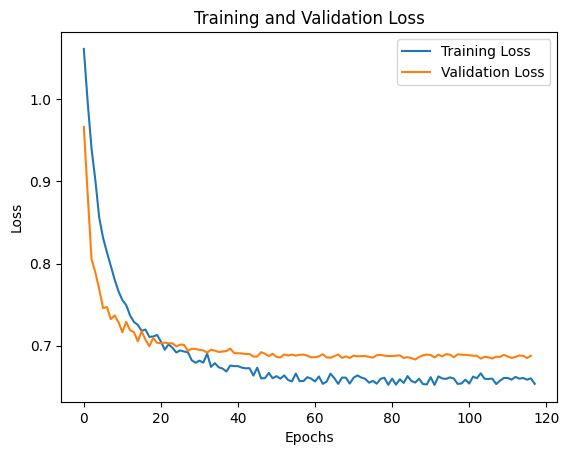

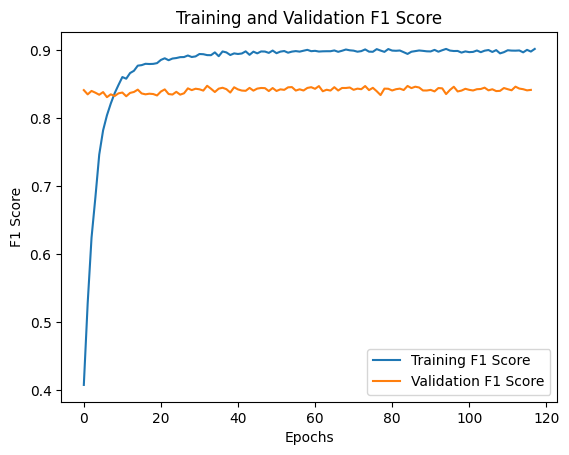

In [ ]:
# Initialize MetaClassifier and move to device
feed_forward_NN = FeedForwardNN().to(device)

# HP definition
num_epochs = 200
batch_size = 128
lr = 1e-5
weight_decay = 1e-2
model_path = "FFNN.pth"

# Training loop
train_metaclassifier(feed_forward_NN, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

In [ ]:
FFNN = FeedForwardNN()
FFNN.load_state_dict(torch.load(model_path))
FFNN = FFNN.to(device)
evaluate_metaclassifier(FFNN, test_dataset)


Test Loss: 0.6612329284350077
Test Macro F1 Score: 0.874318467824069
Test Weighted F1 Score: [0.89003436 0.89779559 0.83512545]
Test Accuracy: 0.8859601936525013


##### <b>Convolutional NN</b>

Here, I would like to try a Convolutional architecture.</br>The reason behind this choice is the hope that the model could be capable of extracting high-order features concerning the reliability of base models.

Let's try and see!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_1d(nn.Module):
    def __init__(self):
        super(CNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, 3)  # Input tensor has shape [batch_size, 1, 6] after the unsqueeze
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(16, 32, 3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32 * 2, 64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)

        # First Convolutional Layer
        x = F.gelu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second Convolutional Layer
        x = F.gelu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FCLayers
        x = F.selu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

Epoch 0: 100%|██████████| 33/33 [00:01<00:00, 31.27it/s, training_loss=0.512]



Training Loss at end of epoch 0: 1.080934358365608
Training F1 Score at end of epoch 0: 0.361464865407873
New best model saved with validation loss: 1.056466355919838

Validation Loss at end of epoch 0: 1.056466355919838
Validation Macro F1 Score at end of epoch 0: 0.24667583677212288
Validation Weighted F1 Score at end of epoch 0: [0.         0.74002751 0.        ]


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 142.26it/s, training_loss=0.618]



Training Loss at end of epoch 1: 1.079144911332564
Training F1 Score at end of epoch 1: 0.37289862994230755
New best model saved with validation loss: 1.0342939496040344

Validation Loss at end of epoch 1: 1.0342939496040344
Validation Macro F1 Score at end of epoch 1: 0.5372438496645272
Validation Weighted F1 Score at end of epoch 1: [0.78139535 0.8303362  0.        ]


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 143.33it/s, training_loss=0.632]



Training Loss at end of epoch 2: 1.0707743709737605
Training F1 Score at end of epoch 2: 0.39151059722205256
New best model saved with validation loss: 1.0221159607172012

Validation Loss at end of epoch 2: 1.0221159607172012
Validation Macro F1 Score at end of epoch 2: 0.5416919641113584
Validation Weighted F1 Score at end of epoch 2: [0.79372197 0.83135392 0.        ]


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 146.39it/s, training_loss=0.631]



Training Loss at end of epoch 3: 1.0613515051928433
Training F1 Score at end of epoch 3: 0.4140863288071231
New best model saved with validation loss: 1.0121423602104187

Validation Loss at end of epoch 3: 1.0121423602104187
Validation Macro F1 Score at end of epoch 3: 0.5622191034722864
Validation Weighted F1 Score at end of epoch 3: [0.79006772 0.83359746 0.06299213]


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 143.22it/s, training_loss=0.536]



Training Loss at end of epoch 4: 1.0437131469899958
Training F1 Score at end of epoch 4: 0.43328017542127073
New best model saved with validation loss: 0.9969820156693459

Validation Loss at end of epoch 4: 0.9969820156693459
Validation Macro F1 Score at end of epoch 4: 0.6594873435436122
Validation Weighted F1 Score at end of epoch 4: [0.80266075 0.84927066 0.32653061]


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 139.99it/s, training_loss=0.555]



Training Loss at end of epoch 5: 1.0340863068898518
Training F1 Score at end of epoch 5: 0.461295801706763
New best model saved with validation loss: 0.9901237189769745

Validation Loss at end of epoch 5: 0.9901237189769745
Validation Macro F1 Score at end of epoch 5: 0.7804827195824394
Validation Weighted F1 Score at end of epoch 5: [0.79550562 0.87572977 0.67021277]


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 141.61it/s, training_loss=0.641]



Training Loss at end of epoch 6: 1.0287461118264631
Training F1 Score at end of epoch 6: 0.49029082177125677
New best model saved with validation loss: 0.9757583364844322

Validation Loss at end of epoch 6: 0.9757583364844322
Validation Macro F1 Score at end of epoch 6: 0.7882270822291154
Validation Weighted F1 Score at end of epoch 6: [0.80176211 0.87573964 0.68717949]


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 135.45it/s, training_loss=0.482]



Training Loss at end of epoch 7: 1.0093594518574802
Training F1 Score at end of epoch 7: 0.5083641081994703
New best model saved with validation loss: 0.9568280950188637

Validation Loss at end of epoch 7: 0.9568280950188637
Validation Macro F1 Score at end of epoch 7: 0.8228130806866387
Validation Weighted F1 Score at end of epoch 7: [0.8043956  0.88679245 0.77725118]


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 142.08it/s, training_loss=0.566]



Training Loss at end of epoch 8: 1.0064569260134841
Training F1 Score at end of epoch 8: 0.5233893919259396
New best model saved with validation loss: 0.9464251175522804

Validation Loss at end of epoch 8: 0.9464251175522804
Validation Macro F1 Score at end of epoch 8: 0.8266066880355075
Validation Weighted F1 Score at end of epoch 8: [0.80176211 0.88736028 0.79069767]


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 148.49it/s, training_loss=0.481]



Training Loss at end of epoch 9: 0.9938877839030642
Training F1 Score at end of epoch 9: 0.5327147976907729
New best model saved with validation loss: 0.9406881332397461

Validation Loss at end of epoch 9: 0.9406881332397461
Validation Macro F1 Score at end of epoch 9: 0.8295944523972162
Validation Weighted F1 Score at end of epoch 9: [0.81465517 0.88908146 0.78504673]


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 149.80it/s, training_loss=0.564]



Training Loss at end of epoch 10: 0.9886535984097105
Training F1 Score at end of epoch 10: 0.5582247090755629
New best model saved with validation loss: 0.9273975268006325

Validation Loss at end of epoch 10: 0.9273975268006325
Validation Macro F1 Score at end of epoch 10: 0.8253057807747428
Validation Weighted F1 Score at end of epoch 10: [0.80942184 0.88715278 0.77934272]


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 147.99it/s, training_loss=0.411]



Training Loss at end of epoch 11: 0.9707497683438387
Training F1 Score at end of epoch 11: 0.5746116660415238
New best model saved with validation loss: 0.9125949740409851

Validation Loss at end of epoch 11: 0.9125949740409851
Validation Macro F1 Score at end of epoch 11: 0.8271629755369592
Validation Weighted F1 Score at end of epoch 11: [0.80769231 0.88675958 0.78703704]


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 147.11it/s, training_loss=0.467]



Training Loss at end of epoch 12: 0.9638226393497351
Training F1 Score at end of epoch 12: 0.589088323809772
New best model saved with validation loss: 0.9091128632426262

Validation Loss at end of epoch 12: 0.9091128632426262
Validation Macro F1 Score at end of epoch 12: 0.8267414325244783
Validation Weighted F1 Score at end of epoch 12: [0.80603448 0.88715278 0.78703704]


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 149.83it/s, training_loss=0.448]



Training Loss at end of epoch 13: 0.9534260883475795
Training F1 Score at end of epoch 13: 0.6161838361423567
New best model saved with validation loss: 0.8989681378006935

Validation Loss at end of epoch 13: 0.8989681378006935
Validation Macro F1 Score at end of epoch 13: 0.8310848766540603
Validation Weighted F1 Score at end of epoch 13: [0.8111588  0.8894691  0.79262673]


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 149.36it/s, training_loss=0.549]



Training Loss at end of epoch 14: 0.9552215121009133
Training F1 Score at end of epoch 14: 0.6170627361788402
New best model saved with validation loss: 0.8828169852495193

Validation Loss at end of epoch 14: 0.8828169852495193
Validation Macro F1 Score at end of epoch 14: 0.8312896377412508
Validation Weighted F1 Score at end of epoch 14: [0.81196581 0.88927637 0.79262673]


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 146.17it/s, training_loss=0.384]



Training Loss at end of epoch 15: 0.9353692947012006
Training F1 Score at end of epoch 15: 0.6351484046202553
New best model saved with validation loss: 0.8775859698653221

Validation Loss at end of epoch 15: 0.8775859698653221
Validation Macro F1 Score at end of epoch 15: 0.8303894750037623
Validation Weighted F1 Score at end of epoch 15: [0.81023454 0.88830716 0.79262673]


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 142.51it/s, training_loss=0.521]



Training Loss at end of epoch 16: 0.9333196896495242
Training F1 Score at end of epoch 16: 0.6552404008078684
New best model saved with validation loss: 0.8670210093259811

Validation Loss at end of epoch 16: 0.8670210093259811
Validation Macro F1 Score at end of epoch 16: 0.8366547069449878
Validation Weighted F1 Score at end of epoch 16: [0.81023454 0.89063867 0.80909091]


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 147.23it/s, training_loss=0.414]



Training Loss at end of epoch 17: 0.9230885957226609
Training F1 Score at end of epoch 17: 0.6545733967671856
New best model saved with validation loss: 0.8638631105422974

Validation Loss at end of epoch 17: 0.8638631105422974
Validation Macro F1 Score at end of epoch 17: 0.8309741544741854
Validation Weighted F1 Score at end of epoch 17: [0.81545064 0.89043478 0.78703704]


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 143.74it/s, training_loss=0.631]



Training Loss at end of epoch 18: 0.9300607912468187
Training F1 Score at end of epoch 18: 0.6774197116679298
New best model saved with validation loss: 0.8565037474036217

Validation Loss at end of epoch 18: 0.8565037474036217
Validation Macro F1 Score at end of epoch 18: 0.8346804811530456
Validation Weighted F1 Score at end of epoch 18: [0.81276596 0.88947368 0.8018018 ]


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 148.84it/s, training_loss=0.397]



Training Loss at end of epoch 19: 0.9072038820295623
Training F1 Score at end of epoch 19: 0.680941796423162
New best model saved with validation loss: 0.8465948179364204

Validation Loss at end of epoch 19: 0.8465948179364204
Validation Macro F1 Score at end of epoch 19: 0.8346804811530456
Validation Weighted F1 Score at end of epoch 19: [0.81276596 0.88947368 0.8018018 ]


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 142.72it/s, training_loss=0.457]



Training Loss at end of epoch 20: 0.902568033247283
Training F1 Score at end of epoch 20: 0.6944065774746039
New best model saved with validation loss: 0.8371414989233017

Validation Loss at end of epoch 20: 0.8371414989233017
Validation Macro F1 Score at end of epoch 20: 0.8390640819104004
Validation Weighted F1 Score at end of epoch 20: [0.82278481 0.89260563 0.8018018 ]


Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 142.07it/s, training_loss=0.362]



Training Loss at end of epoch 21: 0.8933689395586649
Training F1 Score at end of epoch 21: 0.708471225074728
New best model saved with validation loss: 0.8306863382458687

Validation Loss at end of epoch 21: 0.8306863382458687
Validation Macro F1 Score at end of epoch 21: 0.8346804811530456
Validation Weighted F1 Score at end of epoch 21: [0.81276596 0.88947368 0.8018018 ]


Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 140.14it/s, training_loss=0.538]



Training Loss at end of epoch 22: 0.8959796446742434
Training F1 Score at end of epoch 22: 0.7167365225768507
New best model saved with validation loss: 0.8247253522276878

Validation Loss at end of epoch 22: 0.8247253522276878
Validation Macro F1 Score at end of epoch 22: 0.8379727884544722
Validation Weighted F1 Score at end of epoch 22: [0.82029598 0.89182058 0.8018018 ]


Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 144.59it/s, training_loss=0.417]



Training Loss at end of epoch 23: 0.8791475783694874
Training F1 Score at end of epoch 23: 0.7272525820251471
New best model saved with validation loss: 0.8153682202100754

Validation Loss at end of epoch 23: 0.8153682202100754
Validation Macro F1 Score at end of epoch 23: 0.8379727884544722
Validation Weighted F1 Score at end of epoch 23: [0.82029598 0.89182058 0.8018018 ]


Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 141.71it/s, training_loss=0.419]



Training Loss at end of epoch 24: 0.8715256904110764
Training F1 Score at end of epoch 24: 0.73747030412075
New best model saved with validation loss: 0.814920462667942

Validation Loss at end of epoch 24: 0.814920462667942
Validation Macro F1 Score at end of epoch 24: 0.8357810117706777
Validation Weighted F1 Score at end of epoch 24: [0.81528662 0.89025461 0.8018018 ]


Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 135.81it/s, training_loss=0.393]



Training Loss at end of epoch 25: 0.8668234041242888
Training F1 Score at end of epoch 25: 0.7436402875143552
New best model saved with validation loss: 0.8042246922850609

Validation Loss at end of epoch 25: 0.8042246922850609
Validation Macro F1 Score at end of epoch 25: 0.8390640819104004
Validation Weighted F1 Score at end of epoch 25: [0.82278481 0.89260563 0.8018018 ]


Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 142.17it/s, training_loss=0.503]



Training Loss at end of epoch 26: 0.8655009197466301
Training F1 Score at end of epoch 26: 0.754687793541614
New best model saved with validation loss: 0.8035140633583069

Validation Loss at end of epoch 26: 0.8035140633583069
Validation Macro F1 Score at end of epoch 26: 0.8357810117706777
Validation Weighted F1 Score at end of epoch 26: [0.81528662 0.89025461 0.8018018 ]


Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 141.76it/s, training_loss=0.415]



Training Loss at end of epoch 27: 0.8586944757085858
Training F1 Score at end of epoch 27: 0.7523955094243323
New best model saved with validation loss: 0.7949501201510429

Validation Loss at end of epoch 27: 0.7949501201510429
Validation Macro F1 Score at end of epoch 27: 0.8357810117706777
Validation Weighted F1 Score at end of epoch 27: [0.81528662 0.89025461 0.8018018 ]


Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 144.43it/s, training_loss=0.349]



Training Loss at end of epoch 28: 0.8475048831014922
Training F1 Score at end of epoch 28: 0.7617919567882027
New best model saved with validation loss: 0.7910851612687111

Validation Loss at end of epoch 28: 0.7910851612687111
Validation Macro F1 Score at end of epoch 28: 0.8327440106394529
Validation Weighted F1 Score at end of epoch 28: [0.81528662 0.88830255 0.79464286]


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 140.67it/s, training_loss=0.362]



Training Loss at end of epoch 29: 0.8413851911371405
Training F1 Score at end of epoch 29: 0.7655625343155278
New best model saved with validation loss: 0.7839872762560844

Validation Loss at end of epoch 29: 0.7839872762560844
Validation Macro F1 Score at end of epoch 29: 0.8364491105120407
Validation Weighted F1 Score at end of epoch 29: [0.82029598 0.89084507 0.79820628]


Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 143.30it/s, training_loss=0.442]



Training Loss at end of epoch 30: 0.8414928985364509
Training F1 Score at end of epoch 30: 0.7696916390961964
New best model saved with validation loss: 0.779790535569191

Validation Loss at end of epoch 30: 0.779790535569191
Validation Macro F1 Score at end of epoch 30: 0.8364491105120407
Validation Weighted F1 Score at end of epoch 30: [0.82029598 0.89084507 0.79820628]


Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 141.23it/s, training_loss=0.483]



Training Loss at end of epoch 31: 0.8377423575430205
Training F1 Score at end of epoch 31: 0.7891189398188598
New best model saved with validation loss: 0.7748190984129906

Validation Loss at end of epoch 31: 0.7748190984129906
Validation Macro F1 Score at end of epoch 31: 0.8382461219439842
Validation Weighted F1 Score at end of epoch 31: [0.82526316 0.89301503 0.79646018]


Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 146.10it/s, training_loss=0.563]



Training Loss at end of epoch 32: 0.8393803329178782
Training F1 Score at end of epoch 32: 0.7881348535298983
New best model saved with validation loss: 0.7733144983649254

Validation Loss at end of epoch 32: 0.7733144983649254
Validation Macro F1 Score at end of epoch 32: 0.8368784396084745
Validation Weighted F1 Score at end of epoch 32: [0.81779661 0.89103691 0.8018018 ]


Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 141.35it/s, training_loss=0.387]



Training Loss at end of epoch 33: 0.8213100361101555
Training F1 Score at end of epoch 33: 0.796545542542575
New best model saved with validation loss: 0.7680143117904663

Validation Loss at end of epoch 33: 0.7680143117904663
Validation Macro F1 Score at end of epoch 33: 0.8362001391385805
Validation Weighted F1 Score at end of epoch 33: [0.82526316 0.89222615 0.79111111]


Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 144.77it/s, training_loss=0.319]



Training Loss at end of epoch 34: 0.8144219156467554
Training F1 Score at end of epoch 34: 0.796531488408628
New best model saved with validation loss: 0.7635113745927811

Validation Loss at end of epoch 34: 0.7635113745927811
Validation Macro F1 Score at end of epoch 34: 0.8382461219439842
Validation Weighted F1 Score at end of epoch 34: [0.82526316 0.89301503 0.79646018]


Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 144.62it/s, training_loss=0.324]



Training Loss at end of epoch 35: 0.8121567820057725
Training F1 Score at end of epoch 35: 0.7989818278650219
New best model saved with validation loss: 0.7606579810380936

Validation Loss at end of epoch 35: 0.7606579810380936
Validation Macro F1 Score at end of epoch 35: 0.8360649395022604
Validation Weighted F1 Score at end of epoch 35: [0.82029598 0.89143866 0.79646018]


Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 143.85it/s, training_loss=0.346]



Training Loss at end of epoch 36: 0.8103530551448013
Training F1 Score at end of epoch 36: 0.7989014575060752
New best model saved with validation loss: 0.7578730285167694

Validation Loss at end of epoch 36: 0.7578730285167694
Validation Macro F1 Score at end of epoch 36: 0.8401523433937067
Validation Weighted F1 Score at end of epoch 36: [0.82526316 0.89339207 0.8018018 ]


Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 144.03it/s, training_loss=0.316]



Training Loss at end of epoch 37: 0.8043038628318093
Training F1 Score at end of epoch 37: 0.8076295445558016
New best model saved with validation loss: 0.756349965929985

Validation Loss at end of epoch 37: 0.756349965929985
Validation Macro F1 Score at end of epoch 37: 0.8329251875634315
Validation Weighted F1 Score at end of epoch 37: [0.81779661 0.88986784 0.79111111]


Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 143.02it/s, training_loss=0.440]



Training Loss at end of epoch 38: 0.8059351660988547
Training F1 Score at end of epoch 38: 0.8088207903195931
New best model saved with validation loss: 0.7505188584327698

Validation Loss at end of epoch 38: 0.7505188584327698
Validation Macro F1 Score at end of epoch 38: 0.8384271644730997
Validation Weighted F1 Score at end of epoch 38: [0.82599581 0.89282551 0.79646018]


Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 146.63it/s, training_loss=0.492]



Training Loss at end of epoch 39: 0.8032481218829299
Training F1 Score at end of epoch 39: 0.8120330169295643
New best model saved with validation loss: 0.7457994297146797

Validation Loss at end of epoch 39: 0.7457994297146797
Validation Macro F1 Score at end of epoch 39: 0.8371570451758755
Validation Weighted F1 Score at end of epoch 39: [0.82278481 0.89222615 0.79646018]


Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 142.59it/s, training_loss=0.472]



Training Loss at end of epoch 40: 0.8001318808757898
Training F1 Score at end of epoch 40: 0.8184623856672607
New best model saved with validation loss: 0.7441876381635666

Validation Loss at end of epoch 40: 0.7441876381635666
Validation Macro F1 Score at end of epoch 40: 0.8338715475348879
Validation Weighted F1 Score at end of epoch 40: [0.81528662 0.88986784 0.79646018]


Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 149.02it/s, training_loss=0.399]



Training Loss at end of epoch 41: 0.7908257047335306
Training F1 Score at end of epoch 41: 0.8218515045168492
New best model saved with validation loss: 0.7404746934771538

Validation Loss at end of epoch 41: 0.7404746934771538
Validation Macro F1 Score at end of epoch 41: 0.8393723452008056
Validation Weighted F1 Score at end of epoch 41: [0.82352941 0.89282551 0.80176211]


Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 144.96it/s, training_loss=0.424]



Training Loss at end of epoch 42: 0.7906691630681356
Training F1 Score at end of epoch 42: 0.821735750490868

Validation Loss at end of epoch 42: 0.7412944510579109
Validation Macro F1 Score at end of epoch 42: 0.8347755080031435
Validation Weighted F1 Score at end of epoch 42: [0.81702128 0.89084507 0.79646018]


Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 144.98it/s, training_loss=0.441]



Training Loss at end of epoch 43: 0.7860844207532478
Training F1 Score at end of epoch 43: 0.8275976509376548
New best model saved with validation loss: 0.7328997403383255

Validation Loss at end of epoch 43: 0.7328997403383255
Validation Macro F1 Score at end of epoch 43: 0.841541311756944
Validation Weighted F1 Score at end of epoch 43: [0.82845188 0.89440994 0.80176211]


Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 146.07it/s, training_loss=0.468]



Training Loss at end of epoch 44: 0.7858596678936121
Training F1 Score at end of epoch 44: 0.8321406987488756

Validation Loss at end of epoch 44: 0.73561891913414
Validation Macro F1 Score at end of epoch 44: 0.8344281792449614
Validation Weighted F1 Score at end of epoch 44: [0.81779661 0.89084507 0.79464286]


Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 147.57it/s, training_loss=0.417]



Training Loss at end of epoch 45: 0.7779406598120024
Training F1 Score at end of epoch 45: 0.8359244324270058

Validation Loss at end of epoch 45: 0.7343219742178917
Validation Macro F1 Score at end of epoch 45: 0.8359004320201634
Validation Weighted F1 Score at end of epoch 45: [0.81528662 0.89065256 0.80176211]


Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 147.37it/s, training_loss=0.330]



Training Loss at end of epoch 46: 0.7690288099375638
Training F1 Score at end of epoch 46: 0.8351775004999532
New best model saved with validation loss: 0.7325562164187431

Validation Loss at end of epoch 46: 0.7325562164187431
Validation Macro F1 Score at end of epoch 46: 0.8371570451758755
Validation Weighted F1 Score at end of epoch 46: [0.82278481 0.89222615 0.79646018]


Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 148.08it/s, training_loss=0.394]



Training Loss at end of epoch 47: 0.7700834256229978
Training F1 Score at end of epoch 47: 0.84385897612562
New best model saved with validation loss: 0.7274595573544502

Validation Loss at end of epoch 47: 0.7274595573544502
Validation Macro F1 Score at end of epoch 47: 0.836999127711962
Validation Weighted F1 Score at end of epoch 47: [0.81779661 0.89143866 0.80176211]


Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 145.53it/s, training_loss=0.329]



Training Loss at end of epoch 48: 0.7642965226462393
Training F1 Score at end of epoch 48: 0.8450975877734321
New best model saved with validation loss: 0.7250586748123169

Validation Loss at end of epoch 48: 0.7250586748123169
Validation Macro F1 Score at end of epoch 48: 0.8362001391385805
Validation Weighted F1 Score at end of epoch 48: [0.82526316 0.89222615 0.79111111]


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 142.36it/s, training_loss=0.433]



Training Loss at end of epoch 49: 0.7652746727972319
Training F1 Score at end of epoch 49: 0.8464926424983655

Validation Loss at end of epoch 49: 0.7253565713763237
Validation Macro F1 Score at end of epoch 49: 0.8380947486780066
Validation Weighted F1 Score at end of epoch 49: [0.82029598 0.89222615 0.80176211]


Epoch 50: 100%|██████████| 33/33 [00:00<00:00, 146.05it/s, training_loss=0.473]



Training Loss at end of epoch 50: 0.7646477096008532
Training F1 Score at end of epoch 50: 0.8435706345626462

Validation Loss at end of epoch 50: 0.7254026979207993
Validation Macro F1 Score at end of epoch 50: 0.8333303489566619
Validation Weighted F1 Score at end of epoch 50: [0.81528662 0.89006157 0.79464286]


Epoch 51: 100%|██████████| 33/33 [00:00<00:00, 145.85it/s, training_loss=0.360]



Training Loss at end of epoch 51: 0.756551616119616
Training F1 Score at end of epoch 51: 0.8462436286669587
New best model saved with validation loss: 0.7208510041236877

Validation Loss at end of epoch 51: 0.7208510041236877
Validation Macro F1 Score at end of epoch 51: 0.8344281792449614
Validation Weighted F1 Score at end of epoch 51: [0.81779661 0.89084507 0.79464286]


Epoch 52: 100%|██████████| 33/33 [00:00<00:00, 144.98it/s, training_loss=0.490]



Training Loss at end of epoch 52: 0.7620790420156537
Training F1 Score at end of epoch 52: 0.8506200218770065
New best model saved with validation loss: 0.7191527336835861

Validation Loss at end of epoch 52: 0.7191527336835861
Validation Macro F1 Score at end of epoch 52: 0.8435578965274265
Validation Weighted F1 Score at end of epoch 52: [0.82845188 0.89520426 0.80701754]


Epoch 53: 100%|██████████| 33/33 [00:00<00:00, 148.69it/s, training_loss=0.326]



Training Loss at end of epoch 53: 0.750416838761532
Training F1 Score at end of epoch 53: 0.8522926615672183

Validation Loss at end of epoch 53: 0.7196609526872635
Validation Macro F1 Score at end of epoch 53: 0.8409724402842346
Validation Weighted F1 Score at end of epoch 53: [0.82599581 0.89342806 0.80349345]


Epoch 54: 100%|██████████| 33/33 [00:00<00:00, 143.57it/s, training_loss=0.302]



Training Loss at end of epoch 54: 0.7474422707702174
Training F1 Score at end of epoch 54: 0.8523818135233036
New best model saved with validation loss: 0.7190592959523201

Validation Loss at end of epoch 54: 0.7190592959523201
Validation Macro F1 Score at end of epoch 54: 0.8412025545735814
Validation Weighted F1 Score at end of epoch 54: [0.82278481 0.89380531 0.80701754]


Epoch 55: 100%|██████████| 33/33 [00:00<00:00, 140.82it/s, training_loss=0.365]



Training Loss at end of epoch 55: 0.7469560594269724
Training F1 Score at end of epoch 55: 0.8572736072728094
New best model saved with validation loss: 0.7162864431738853

Validation Loss at end of epoch 55: 0.7162864431738853
Validation Macro F1 Score at end of epoch 55: 0.8399909463642518
Validation Weighted F1 Score at end of epoch 55: [0.82599581 0.89225289 0.80172414]


Epoch 56: 100%|██████████| 33/33 [00:00<00:00, 142.22it/s, training_loss=0.312]



Training Loss at end of epoch 56: 0.7414925224853285
Training F1 Score at end of epoch 56: 0.8586863570900557
New best model saved with validation loss: 0.7153741270303726

Validation Loss at end of epoch 56: 0.7153741270303726
Validation Macro F1 Score at end of epoch 56: 0.8412025545735814
Validation Weighted F1 Score at end of epoch 56: [0.82278481 0.89380531 0.80701754]


Epoch 57: 100%|██████████| 33/33 [00:00<00:00, 147.10it/s, training_loss=0.329]



Training Loss at end of epoch 57: 0.7426897287368774
Training F1 Score at end of epoch 57: 0.8521298437192749
New best model saved with validation loss: 0.714713953435421

Validation Loss at end of epoch 57: 0.714713953435421
Validation Macro F1 Score at end of epoch 57: 0.8382095939192626
Validation Weighted F1 Score at end of epoch 57: [0.82278481 0.89184397 0.8       ]


Epoch 58: 100%|██████████| 33/33 [00:00<00:00, 147.63it/s, training_loss=0.320]



Training Loss at end of epoch 58: 0.7394654100591486
Training F1 Score at end of epoch 58: 0.8493233038985917
New best model saved with validation loss: 0.7120309919118881

Validation Loss at end of epoch 58: 0.7120309919118881
Validation Macro F1 Score at end of epoch 58: 0.8379972261325918
Validation Weighted F1 Score at end of epoch 58: [0.82599581 0.89145907 0.7965368 ]


Epoch 59: 100%|██████████| 33/33 [00:00<00:00, 141.37it/s, training_loss=0.358]



Training Loss at end of epoch 59: 0.7384671063134165
Training F1 Score at end of epoch 59: 0.8590937632750085
New best model saved with validation loss: 0.7113980278372765

Validation Loss at end of epoch 59: 0.7113980278372765
Validation Macro F1 Score at end of epoch 59: 0.8379461110801903
Validation Weighted F1 Score at end of epoch 59: [0.82180294 0.8920354  0.8       ]


Epoch 60: 100%|██████████| 33/33 [00:00<00:00, 142.06it/s, training_loss=0.311]



Training Loss at end of epoch 60: 0.7332420764547406
Training F1 Score at end of epoch 60: 0.8588057280367988

Validation Loss at end of epoch 60: 0.7115340754389763
Validation Macro F1 Score at end of epoch 60: 0.8377595933296137
Validation Weighted F1 Score at end of epoch 60: [0.82105263 0.89222615 0.8       ]


Epoch 61: 100%|██████████| 33/33 [00:00<00:00, 142.44it/s, training_loss=0.576]



Training Loss at end of epoch 61: 0.7484215335412459
Training F1 Score at end of epoch 61: 0.8617650135792242
New best model saved with validation loss: 0.7083601653575897

Validation Loss at end of epoch 61: 0.7083601653575897
Validation Macro F1 Score at end of epoch 61: 0.8390805244719409
Validation Weighted F1 Score at end of epoch 61: [0.82845188 0.89225289 0.7965368 ]


Epoch 62: 100%|██████████| 33/33 [00:00<00:00, 141.66it/s, training_loss=0.290]



Training Loss at end of epoch 62: 0.7281628919370247
Training F1 Score at end of epoch 62: 0.8629140797010763

Validation Loss at end of epoch 62: 0.7100201547145844
Validation Macro F1 Score at end of epoch 62: 0.8375122481004279
Validation Weighted F1 Score at end of epoch 62: [0.81779661 0.89124668 0.80349345]


Epoch 63: 100%|██████████| 33/33 [00:00<00:00, 140.82it/s, training_loss=0.374]



Training Loss at end of epoch 63: 0.7315842057719375
Training F1 Score at end of epoch 63: 0.8648028329345304
New best model saved with validation loss: 0.7071214243769646

Validation Loss at end of epoch 63: 0.7071214243769646
Validation Macro F1 Score at end of epoch 63: 0.8349697814932887
Validation Weighted F1 Score at end of epoch 63: [0.81779661 0.89065256 0.79646018]


Epoch 64: 100%|██████████| 33/33 [00:00<00:00, 146.45it/s, training_loss=0.451]



Training Loss at end of epoch 64: 0.7348205158204744
Training F1 Score at end of epoch 64: 0.8618260761594604
New best model saved with validation loss: 0.7068774551153183

Validation Loss at end of epoch 64: 0.7068774551153183
Validation Macro F1 Score at end of epoch 64: 0.8399909463642518
Validation Weighted F1 Score at end of epoch 64: [0.82599581 0.89225289 0.80172414]


Epoch 65: 100%|██████████| 33/33 [00:00<00:00, 62.36it/s, training_loss=0.424]



Training Loss at end of epoch 65: 0.7310760508884083
Training F1 Score at end of epoch 65: 0.8634503917568456
New best model saved with validation loss: 0.7055593729019165

Validation Loss at end of epoch 65: 0.7055593729019165
Validation Macro F1 Score at end of epoch 65: 0.8398105800900719
Validation Weighted F1 Score at end of epoch 65: [0.82526316 0.89244444 0.80172414]


Epoch 66: 100%|██████████| 33/33 [00:00<00:00, 134.46it/s, training_loss=0.316]



Training Loss at end of epoch 66: 0.7213664759289135
Training F1 Score at end of epoch 66: 0.8671492657289855

Validation Loss at end of epoch 66: 0.7064528614282608
Validation Macro F1 Score at end of epoch 66: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 66: [0.81779661 0.89007092 0.80172414]


Epoch 67: 100%|██████████| 33/33 [00:00<00:00, 137.53it/s, training_loss=0.371]



Training Loss at end of epoch 67: 0.7264658917080272
Training F1 Score at end of epoch 67: 0.8611770501172461
New best model saved with validation loss: 0.7018866464495659

Validation Loss at end of epoch 67: 0.7018866464495659
Validation Macro F1 Score at end of epoch 67: 0.8410747163728228
Validation Weighted F1 Score at end of epoch 67: [0.82845188 0.89304813 0.80172414]


Epoch 68: 100%|██████████| 33/33 [00:00<00:00, 139.54it/s, training_loss=0.338]



Training Loss at end of epoch 68: 0.7209847768147787
Training F1 Score at end of epoch 68: 0.8678144020888289

Validation Loss at end of epoch 68: 0.7021020576357841
Validation Macro F1 Score at end of epoch 68: 0.8410747163728228
Validation Weighted F1 Score at end of epoch 68: [0.82845188 0.89304813 0.80172414]


Epoch 69: 100%|██████████| 33/33 [00:00<00:00, 145.05it/s, training_loss=0.303]



Training Loss at end of epoch 69: 0.7152487491116379
Training F1 Score at end of epoch 69: 0.870236739868823

Validation Loss at end of epoch 69: 0.7044291496276855
Validation Macro F1 Score at end of epoch 69: 0.8408814853374978
Validation Weighted F1 Score at end of epoch 69: [0.82352941 0.89380531 0.80530973]


Epoch 70: 100%|██████████| 33/33 [00:00<00:00, 141.85it/s, training_loss=0.314]



Training Loss at end of epoch 70: 0.7167841159936154
Training F1 Score at end of epoch 70: 0.8670566635780538
New best model saved with validation loss: 0.7006916701793671

Validation Loss at end of epoch 70: 0.7006916701793671
Validation Macro F1 Score at end of epoch 70: 0.8399909463642518
Validation Weighted F1 Score at end of epoch 70: [0.82599581 0.89225289 0.80172414]


Epoch 71: 100%|██████████| 33/33 [00:00<00:00, 138.06it/s, training_loss=0.296]



Training Loss at end of epoch 71: 0.713862783981092
Training F1 Score at end of epoch 71: 0.871813946188151

Validation Loss at end of epoch 71: 0.7008117958903313
Validation Macro F1 Score at end of epoch 71: 0.840169045420172
Validation Weighted F1 Score at end of epoch 71: [0.82672234 0.89206066 0.80172414]


Epoch 72: 100%|██████████| 33/33 [00:00<00:00, 141.47it/s, training_loss=0.505]



Training Loss at end of epoch 72: 0.7231324242823052
Training F1 Score at end of epoch 72: 0.8743197833743656

Validation Loss at end of epoch 72: 0.7017515674233437
Validation Macro F1 Score at end of epoch 72: 0.8369156387080968
Validation Weighted F1 Score at end of epoch 72: [0.81528662 0.89026549 0.80519481]


Epoch 73: 100%|██████████| 33/33 [00:00<00:00, 141.75it/s, training_loss=0.516]



Training Loss at end of epoch 73: 0.7248592069654753
Training F1 Score at end of epoch 73: 0.8748381194173825
New best model saved with validation loss: 0.699456088244915

Validation Loss at end of epoch 73: 0.699456088244915
Validation Macro F1 Score at end of epoch 73: 0.8410747163728228
Validation Weighted F1 Score at end of epoch 73: [0.82845188 0.89304813 0.80172414]


Epoch 74: 100%|██████████| 33/33 [00:00<00:00, 137.56it/s, training_loss=0.418]



Training Loss at end of epoch 74: 0.7164821697003914
Training F1 Score at end of epoch 74: 0.8742015373921909

Validation Loss at end of epoch 74: 0.7009720727801323
Validation Macro F1 Score at end of epoch 74: 0.836999127711962
Validation Weighted F1 Score at end of epoch 74: [0.81779661 0.89143866 0.80176211]


Epoch 75: 100%|██████████| 33/33 [00:00<00:00, 135.64it/s, training_loss=0.315]



Training Loss at end of epoch 75: 0.7088308731714884
Training F1 Score at end of epoch 75: 0.8708239354002943
New best model saved with validation loss: 0.6980655118823051

Validation Loss at end of epoch 75: 0.6980655118823051
Validation Macro F1 Score at end of epoch 75: 0.8382095939192626
Validation Weighted F1 Score at end of epoch 75: [0.82278481 0.89184397 0.8       ]


Epoch 76: 100%|██████████| 33/33 [00:00<00:00, 135.22it/s, training_loss=0.374]



Training Loss at end of epoch 76: 0.7122337601401589
Training F1 Score at end of epoch 76: 0.8718862863991655

Validation Loss at end of epoch 76: 0.6992625594139099
Validation Macro F1 Score at end of epoch 76: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 76: [0.81779661 0.89007092 0.80172414]


Epoch 77: 100%|██████████| 33/33 [00:00<00:00, 138.32it/s, training_loss=0.552]



Training Loss at end of epoch 77: 0.7203339356364626
Training F1 Score at end of epoch 77: 0.8748633669216295
New best model saved with validation loss: 0.6973754391074181

Validation Loss at end of epoch 77: 0.6973754391074181
Validation Macro F1 Score at end of epoch 77: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 77: [0.81779661 0.89007092 0.80172414]


Epoch 78: 100%|██████████| 33/33 [00:00<00:00, 134.99it/s, training_loss=0.300]



Training Loss at end of epoch 78: 0.704212385596651
Training F1 Score at end of epoch 78: 0.8763989909859514
New best model saved with validation loss: 0.6973044127225876

Validation Loss at end of epoch 78: 0.6973044127225876
Validation Macro F1 Score at end of epoch 78: 0.8406696268920406
Validation Weighted F1 Score at end of epoch 78: [0.82672234 0.89186774 0.8034188 ]


Epoch 79: 100%|██████████| 33/33 [00:00<00:00, 134.63it/s, training_loss=0.303]



Training Loss at end of epoch 79: 0.7043508977601023
Training F1 Score at end of epoch 79: 0.8725284666550812
New best model saved with validation loss: 0.6959926635026932

Validation Loss at end of epoch 79: 0.6959926635026932
Validation Macro F1 Score at end of epoch 79: 0.839598601590884
Validation Weighted F1 Score at end of epoch 79: [0.82845188 0.89206066 0.79828326]


Epoch 80: 100%|██████████| 33/33 [00:00<00:00, 134.55it/s, training_loss=0.532]



Training Loss at end of epoch 80: 0.7163652344183489
Training F1 Score at end of epoch 80: 0.8701173832461034

Validation Loss at end of epoch 80: 0.6978976130485535
Validation Macro F1 Score at end of epoch 80: 0.8380151484931476
Validation Weighted F1 Score at end of epoch 80: [0.81779661 0.89105403 0.80519481]


Epoch 81: 100%|██████████| 33/33 [00:00<00:00, 143.34it/s, training_loss=0.298]



Training Loss at end of epoch 81: 0.7003904815876123
Training F1 Score at end of epoch 81: 0.8754503829477264
New best model saved with validation loss: 0.6954884305596352

Validation Loss at end of epoch 81: 0.6954884305596352
Validation Macro F1 Score at end of epoch 81: 0.838720271022166
Validation Weighted F1 Score at end of epoch 81: [0.82278481 0.89165187 0.80172414]


Epoch 82: 100%|██████████| 33/33 [00:00<00:00, 145.88it/s, training_loss=0.285]



Training Loss at end of epoch 82: 0.6994741811896815
Training F1 Score at end of epoch 82: 0.873160987331464
New best model saved with validation loss: 0.69539375603199

Validation Loss at end of epoch 82: 0.69539375603199
Validation Macro F1 Score at end of epoch 82: 0.8410747163728228
Validation Weighted F1 Score at end of epoch 82: [0.82845188 0.89304813 0.80172414]


Epoch 83: 100%|██████████| 33/33 [00:00<00:00, 143.74it/s, training_loss=0.297]



Training Loss at end of epoch 83: 0.6981391256505792
Training F1 Score at end of epoch 83: 0.8786847377725122
New best model saved with validation loss: 0.6947927847504616

Validation Loss at end of epoch 83: 0.6947927847504616
Validation Macro F1 Score at end of epoch 83: 0.8415711300765296
Validation Weighted F1 Score at end of epoch 83: [0.82426778 0.89342806 0.80701754]


Epoch 84: 100%|██████████| 33/33 [00:00<00:00, 139.35it/s, training_loss=0.287]



Training Loss at end of epoch 84: 0.6972451173897946
Training F1 Score at end of epoch 84: 0.8770415606100564
New best model saved with validation loss: 0.694172091782093

Validation Loss at end of epoch 84: 0.694172091782093
Validation Macro F1 Score at end of epoch 84: 0.8410747163728228
Validation Weighted F1 Score at end of epoch 84: [0.82845188 0.89304813 0.80172414]


Epoch 85: 100%|██████████| 33/33 [00:00<00:00, 140.87it/s, training_loss=0.349]



Training Loss at end of epoch 85: 0.7000584168867632
Training F1 Score at end of epoch 85: 0.8758158023773052
New best model saved with validation loss: 0.6933718025684357

Validation Loss at end of epoch 85: 0.6933718025684357
Validation Macro F1 Score at end of epoch 85: 0.8431506094375371
Validation Weighted F1 Score at end of epoch 85: [0.82672234 0.89403384 0.80869565]


Epoch 86: 100%|██████████| 33/33 [00:00<00:00, 145.94it/s, training_loss=0.453]



Training Loss at end of epoch 86: 0.7037269382765798
Training F1 Score at end of epoch 86: 0.8806670691881003

Validation Loss at end of epoch 86: 0.6934869810938835
Validation Macro F1 Score at end of epoch 86: 0.8408814853374978
Validation Weighted F1 Score at end of epoch 86: [0.82352941 0.89380531 0.80530973]


Epoch 87: 100%|██████████| 33/33 [00:00<00:00, 145.39it/s, training_loss=0.527]



Training Loss at end of epoch 87: 0.7074558463963595
Training F1 Score at end of epoch 87: 0.8793434471943559

Validation Loss at end of epoch 87: 0.6936430856585503
Validation Macro F1 Score at end of epoch 87: 0.8385148886928026
Validation Weighted F1 Score at end of epoch 87: [0.82599581 0.8912656  0.79828326]


Epoch 88: 100%|██████████| 33/33 [00:00<00:00, 144.02it/s, training_loss=0.346]



Training Loss at end of epoch 88: 0.6961028304967013
Training F1 Score at end of epoch 88: 0.8805753165134006

Validation Loss at end of epoch 88: 0.694533072412014
Validation Macro F1 Score at end of epoch 88: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 88: [0.81779661 0.89007092 0.80172414]


Epoch 89: 100%|██████████| 33/33 [00:00<00:00, 144.40it/s, training_loss=0.279]



Training Loss at end of epoch 89: 0.6937125180706833
Training F1 Score at end of epoch 89: 0.8756403405919476
New best model saved with validation loss: 0.6931892111897469

Validation Loss at end of epoch 89: 0.6931892111897469
Validation Macro F1 Score at end of epoch 89: 0.838720271022166
Validation Weighted F1 Score at end of epoch 89: [0.82278481 0.89165187 0.80172414]


Epoch 90: 100%|██████████| 33/33 [00:00<00:00, 144.19it/s, training_loss=0.295]



Training Loss at end of epoch 90: 0.6919955972469214
Training F1 Score at end of epoch 90: 0.8791690599099145
New best model saved with validation loss: 0.6920141130685806

Validation Loss at end of epoch 90: 0.6920141130685806
Validation Macro F1 Score at end of epoch 90: 0.839598601590884
Validation Weighted F1 Score at end of epoch 90: [0.82845188 0.89206066 0.79828326]


Epoch 91: 100%|██████████| 33/33 [00:00<00:00, 141.27it/s, training_loss=0.338]



Training Loss at end of epoch 91: 0.6926076845689253
Training F1 Score at end of epoch 91: 0.8788272198752477

Validation Loss at end of epoch 91: 0.692274808883667
Validation Macro F1 Score at end of epoch 91: 0.838720271022166
Validation Weighted F1 Score at end of epoch 91: [0.82278481 0.89165187 0.80172414]


Epoch 92: 100%|██████████| 33/33 [00:00<00:00, 146.52it/s, training_loss=0.551]



Training Loss at end of epoch 92: 0.7045104955181931
Training F1 Score at end of epoch 92: 0.8788941583376175

Validation Loss at end of epoch 92: 0.692885622382164
Validation Macro F1 Score at end of epoch 92: 0.838720271022166
Validation Weighted F1 Score at end of epoch 92: [0.82278481 0.89165187 0.80172414]


Epoch 93: 100%|██████████| 33/33 [00:00<00:00, 147.70it/s, training_loss=0.404]



Training Loss at end of epoch 93: 0.6962532708139131
Training F1 Score at end of epoch 93: 0.8794301542216293
New best model saved with validation loss: 0.691712312400341

Validation Loss at end of epoch 93: 0.691712312400341
Validation Macro F1 Score at end of epoch 93: 0.8385148886928026
Validation Weighted F1 Score at end of epoch 93: [0.82599581 0.8912656  0.79828326]


Epoch 94: 100%|██████████| 33/33 [00:00<00:00, 147.16it/s, training_loss=0.355]



Training Loss at end of epoch 94: 0.6910282843040697
Training F1 Score at end of epoch 94: 0.8790473964573846

Validation Loss at end of epoch 94: 0.6929989606142044
Validation Macro F1 Score at end of epoch 94: 0.8354311043549609
Validation Weighted F1 Score at end of epoch 94: [0.81528662 0.88928255 0.80172414]


Epoch 95: 100%|██████████| 33/33 [00:00<00:00, 149.81it/s, training_loss=0.437]



Training Loss at end of epoch 95: 0.6961004354737022
Training F1 Score at end of epoch 95: 0.8856034919133515

Validation Loss at end of epoch 95: 0.6921131610870361
Validation Macro F1 Score at end of epoch 95: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 95: [0.81779661 0.89007092 0.80172414]


Epoch 96: 100%|██████████| 33/33 [00:00<00:00, 146.97it/s, training_loss=0.300]



Training Loss at end of epoch 96: 0.6860547083796877
Training F1 Score at end of epoch 96: 0.8813507992967913
New best model saved with validation loss: 0.6911915317177773

Validation Loss at end of epoch 96: 0.6911915317177773
Validation Macro F1 Score at end of epoch 96: 0.839598601590884
Validation Weighted F1 Score at end of epoch 96: [0.82845188 0.89206066 0.79828326]


Epoch 97: 100%|██████████| 33/33 [00:00<00:00, 147.28it/s, training_loss=0.293]



Training Loss at end of epoch 97: 0.685512875065659
Training F1 Score at end of epoch 97: 0.8808508661847786

Validation Loss at end of epoch 97: 0.691269226372242
Validation Macro F1 Score at end of epoch 97: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 97: [0.82278481 0.89066667 0.79828326]


Epoch 98: 100%|██████████| 33/33 [00:00<00:00, 143.52it/s, training_loss=0.392]



Training Loss at end of epoch 98: 0.6907408219395261
Training F1 Score at end of epoch 98: 0.8805777951379672

Validation Loss at end of epoch 98: 0.691229984164238
Validation Macro F1 Score at end of epoch 98: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 98: [0.82278481 0.89066667 0.79828326]


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 140.29it/s, training_loss=0.520]



Training Loss at end of epoch 99: 0.6969894532001379
Training F1 Score at end of epoch 99: 0.8811719700200403
New best model saved with validation loss: 0.690351590514183

Validation Loss at end of epoch 99: 0.690351590514183
Validation Macro F1 Score at end of epoch 99: 0.838720271022166
Validation Weighted F1 Score at end of epoch 99: [0.82278481 0.89165187 0.80172414]


Epoch 100: 100%|██████████| 33/33 [00:00<00:00, 143.56it/s, training_loss=0.310]



Training Loss at end of epoch 100: 0.6838841944029836
Training F1 Score at end of epoch 100: 0.8810484691231725

Validation Loss at end of epoch 100: 0.6906542181968689
Validation Macro F1 Score at end of epoch 100: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 100: [0.82278481 0.89066667 0.79828326]


Epoch 101: 100%|██████████| 33/33 [00:00<00:00, 137.17it/s, training_loss=0.416]



Training Loss at end of epoch 101: 0.6913784579797224
Training F1 Score at end of epoch 101: 0.880719130528408

Validation Loss at end of epoch 101: 0.6904364302754402
Validation Macro F1 Score at end of epoch 101: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 101: [0.81779661 0.89007092 0.80172414]


Epoch 102: 100%|██████████| 33/33 [00:00<00:00, 136.96it/s, training_loss=0.283]



Training Loss at end of epoch 102: 0.6798741275613959
Training F1 Score at end of epoch 102: 0.8839426370257906
New best model saved with validation loss: 0.6891868188977242

Validation Loss at end of epoch 102: 0.6891868188977242
Validation Macro F1 Score at end of epoch 102: 0.8406696268920406
Validation Weighted F1 Score at end of epoch 102: [0.82672234 0.89186774 0.8034188 ]


Epoch 103: 100%|██████████| 33/33 [00:00<00:00, 139.37it/s, training_loss=0.385]



Training Loss at end of epoch 103: 0.687194925366026
Training F1 Score at end of epoch 103: 0.8842400617914397
New best model saved with validation loss: 0.6889287605881691

Validation Loss at end of epoch 103: 0.6889287605881691
Validation Macro F1 Score at end of epoch 103: 0.837428207900284
Validation Weighted F1 Score at end of epoch 103: [0.82352941 0.89047195 0.79828326]


Epoch 104: 100%|██████████| 33/33 [00:00<00:00, 142.24it/s, training_loss=0.298]



Training Loss at end of epoch 104: 0.6797458637844432
Training F1 Score at end of epoch 104: 0.8809895678317704
New best model saved with validation loss: 0.6888450086116791

Validation Loss at end of epoch 104: 0.6888450086116791
Validation Macro F1 Score at end of epoch 104: 0.839598601590884
Validation Weighted F1 Score at end of epoch 104: [0.82845188 0.89206066 0.79828326]


Epoch 105: 100%|██████████| 33/33 [00:00<00:00, 146.79it/s, training_loss=0.503]



Training Loss at end of epoch 105: 0.692124195171125
Training F1 Score at end of epoch 105: 0.8842985819941295

Validation Loss at end of epoch 105: 0.6890578418970108
Validation Macro F1 Score at end of epoch 105: 0.838720271022166
Validation Weighted F1 Score at end of epoch 105: [0.82278481 0.89165187 0.80172414]


Epoch 106: 100%|██████████| 33/33 [00:00<00:00, 147.64it/s, training_loss=0.501]



Training Loss at end of epoch 106: 0.6893127723173662
Training F1 Score at end of epoch 106: 0.887357556264897

Validation Loss at end of epoch 106: 0.6890742480754852
Validation Macro F1 Score at end of epoch 106: 0.838720271022166
Validation Weighted F1 Score at end of epoch 106: [0.82278481 0.89165187 0.80172414]


Epoch 107: 100%|██████████| 33/33 [00:00<00:00, 145.23it/s, training_loss=0.405]



Training Loss at end of epoch 107: 0.6836457378936537
Training F1 Score at end of epoch 107: 0.8868815974535874
New best model saved with validation loss: 0.6879947036504745

Validation Loss at end of epoch 107: 0.6879947036504745
Validation Macro F1 Score at end of epoch 107: 0.839598601590884
Validation Weighted F1 Score at end of epoch 107: [0.82845188 0.89206066 0.79828326]


Epoch 108: 100%|██████████| 33/33 [00:00<00:00, 143.70it/s, training_loss=0.280]



Training Loss at end of epoch 108: 0.6768357302203323
Training F1 Score at end of epoch 108: 0.8868559928159838

Validation Loss at end of epoch 108: 0.6895061507821083
Validation Macro F1 Score at end of epoch 108: 0.8395092201911645
Validation Weighted F1 Score at end of epoch 108: [0.81779661 0.8920354  0.80869565]


Epoch 109: 100%|██████████| 33/33 [00:00<00:00, 144.84it/s, training_loss=0.295]



Training Loss at end of epoch 109: 0.6775076425436771
Training F1 Score at end of epoch 109: 0.8865661769241234
New best model saved with validation loss: 0.6877938583493233

Validation Loss at end of epoch 109: 0.6877938583493233
Validation Macro F1 Score at end of epoch 109: 0.8437139807954014
Validation Weighted F1 Score at end of epoch 109: [0.82916667 0.89346464 0.80851064]


Epoch 110: 100%|██████████| 33/33 [00:00<00:00, 142.64it/s, training_loss=0.284]



Training Loss at end of epoch 110: 0.6771711291688861
Training F1 Score at end of epoch 110: 0.8841830714225759

Validation Loss at end of epoch 110: 0.6884125918149948
Validation Macro F1 Score at end of epoch 110: 0.8415759430403781
Validation Weighted F1 Score at end of epoch 110: [0.82845188 0.89285714 0.8034188 ]


Epoch 111: 100%|██████████| 33/33 [00:00<00:00, 144.88it/s, training_loss=0.329]



Training Loss at end of epoch 111: 0.677140039024931
Training F1 Score at end of epoch 111: 0.88670477821027
New best model saved with validation loss: 0.6875364780426025

Validation Loss at end of epoch 111: 0.6875364780426025
Validation Macro F1 Score at end of epoch 111: 0.8416550905805481
Validation Weighted F1 Score at end of epoch 111: [0.82672234 0.89304813 0.80519481]


Epoch 112: 100%|██████████| 33/33 [00:00<00:00, 142.84it/s, training_loss=0.296]



Training Loss at end of epoch 112: 0.6757421999266653
Training F1 Score at end of epoch 112: 0.884852948597667

Validation Loss at end of epoch 112: 0.6877090036869049
Validation Macro F1 Score at end of epoch 112: 0.839598601590884
Validation Weighted F1 Score at end of epoch 112: [0.82845188 0.89206066 0.79828326]


Epoch 113: 100%|██████████| 33/33 [00:00<00:00, 142.00it/s, training_loss=0.517]



Training Loss at end of epoch 113: 0.6869638200962183
Training F1 Score at end of epoch 113: 0.8866271835346469

Validation Loss at end of epoch 113: 0.6880890354514122
Validation Macro F1 Score at end of epoch 113: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 113: [0.82278481 0.89066667 0.79828326]


Epoch 114: 100%|██████████| 33/33 [00:00<00:00, 143.93it/s, training_loss=0.438]



Training Loss at end of epoch 114: 0.683965144735394
Training F1 Score at end of epoch 114: 0.8849391000190886

Validation Loss at end of epoch 114: 0.6891743838787079
Validation Macro F1 Score at end of epoch 114: 0.8354311043549609
Validation Weighted F1 Score at end of epoch 114: [0.81528662 0.88928255 0.80172414]


Epoch 115: 100%|██████████| 33/33 [00:00<00:00, 140.40it/s, training_loss=0.365]



Training Loss at end of epoch 115: 0.6783657471338908
Training F1 Score at end of epoch 115: 0.8849734098460976
New best model saved with validation loss: 0.6874012500047684

Validation Loss at end of epoch 115: 0.6874012500047684
Validation Macro F1 Score at end of epoch 115: 0.8422989090304503
Validation Weighted F1 Score at end of epoch 115: [0.82105263 0.89361702 0.81222707]


Epoch 116: 100%|██████████| 33/33 [00:00<00:00, 146.75it/s, training_loss=0.286]



Training Loss at end of epoch 116: 0.6744130976272352
Training F1 Score at end of epoch 116: 0.8850880425655854
New best model saved with validation loss: 0.6871823444962502

Validation Loss at end of epoch 116: 0.6871823444962502
Validation Macro F1 Score at end of epoch 116: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 116: [0.82845188 0.89365505 0.80851064]


Epoch 117: 100%|██████████| 33/33 [00:00<00:00, 139.40it/s, training_loss=0.394]



Training Loss at end of epoch 117: 0.6791423216010585
Training F1 Score at end of epoch 117: 0.8844570279695905
New best model saved with validation loss: 0.6864089816808701

Validation Loss at end of epoch 117: 0.6864089816808701
Validation Macro F1 Score at end of epoch 117: 0.8415759430403781
Validation Weighted F1 Score at end of epoch 117: [0.82845188 0.89285714 0.8034188 ]


Epoch 118: 100%|██████████| 33/33 [00:00<00:00, 142.53it/s, training_loss=0.336]



Training Loss at end of epoch 118: 0.6741192376974857
Training F1 Score at end of epoch 118: 0.8852122834622597
New best model saved with validation loss: 0.6859399601817131

Validation Loss at end of epoch 118: 0.6859399601817131
Validation Macro F1 Score at end of epoch 118: 0.8394856049794611
Validation Weighted F1 Score at end of epoch 118: [0.82180294 0.89145907 0.80519481]


Epoch 119: 100%|██████████| 33/33 [00:00<00:00, 142.62it/s, training_loss=0.351]



Training Loss at end of epoch 119: 0.676304204897447
Training F1 Score at end of epoch 119: 0.886234338309682

Validation Loss at end of epoch 119: 0.6865833103656769
Validation Macro F1 Score at end of epoch 119: 0.8405718272184738
Validation Weighted F1 Score at end of epoch 119: [0.82426778 0.89225289 0.80519481]


Epoch 120: 100%|██████████| 33/33 [00:00<00:00, 141.09it/s, training_loss=0.311]



Training Loss at end of epoch 120: 0.6719354264663927
Training F1 Score at end of epoch 120: 0.8866544722864128

Validation Loss at end of epoch 120: 0.6869622766971588
Validation Macro F1 Score at end of epoch 120: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 120: [0.82278481 0.89066667 0.79828326]


Epoch 121: 100%|██████████| 33/33 [00:00<00:00, 141.33it/s, training_loss=0.281]



Training Loss at end of epoch 121: 0.6705231431758765
Training F1 Score at end of epoch 121: 0.8859480249350181

Validation Loss at end of epoch 121: 0.686402253806591
Validation Macro F1 Score at end of epoch 121: 0.8415759430403781
Validation Weighted F1 Score at end of epoch 121: [0.82845188 0.89285714 0.8034188 ]


Epoch 122: 100%|██████████| 33/33 [00:00<00:00, 136.14it/s, training_loss=0.295]



Training Loss at end of epoch 122: 0.6715189344955214
Training F1 Score at end of epoch 122: 0.8854077814152657

Validation Loss at end of epoch 122: 0.6862358972430229
Validation Macro F1 Score at end of epoch 122: 0.840169045420172
Validation Weighted F1 Score at end of epoch 122: [0.82672234 0.89206066 0.80172414]


Epoch 123: 100%|██████████| 33/33 [00:00<00:00, 139.77it/s, training_loss=0.315]



Training Loss at end of epoch 123: 0.6717685045617999
Training F1 Score at end of epoch 123: 0.886509662449841

Validation Loss at end of epoch 123: 0.6861036345362663
Validation Macro F1 Score at end of epoch 123: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 123: [0.82845188 0.89365505 0.80851064]


Epoch 124: 100%|██████████| 33/33 [00:00<00:00, 143.56it/s, training_loss=0.341]



Training Loss at end of epoch 124: 0.6738421320915222
Training F1 Score at end of epoch 124: 0.8865775538036158

Validation Loss at end of epoch 124: 0.68689826130867
Validation Macro F1 Score at end of epoch 124: 0.8350553137274531
Validation Weighted F1 Score at end of epoch 124: [0.81779661 0.88908607 0.79828326]


Epoch 125: 100%|██████████| 33/33 [00:00<00:00, 138.27it/s, training_loss=0.309]



Training Loss at end of epoch 125: 0.6703476490396442
Training F1 Score at end of epoch 125: 0.888134080236417

Validation Loss at end of epoch 125: 0.6868999600410461
Validation Macro F1 Score at end of epoch 125: 0.838605778522005
Validation Weighted F1 Score at end of epoch 125: [0.81606765 0.89105403 0.80869565]


Epoch 126: 100%|██████████| 33/33 [00:00<00:00, 137.97it/s, training_loss=0.497]



Training Loss at end of epoch 126: 0.6819502747420109
Training F1 Score at end of epoch 126: 0.8857639895448255

Validation Loss at end of epoch 126: 0.6862115189433098
Validation Macro F1 Score at end of epoch 126: 0.838335164810136
Validation Weighted F1 Score at end of epoch 126: [0.82526316 0.89145907 0.79828326]


Epoch 127: 100%|██████████| 33/33 [00:00<00:00, 141.88it/s, training_loss=0.276]



Training Loss at end of epoch 127: 0.6662465026884368
Training F1 Score at end of epoch 127: 0.8897945823729193

Validation Loss at end of epoch 127: 0.6871394738554955
Validation Macro F1 Score at end of epoch 127: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 127: [0.82278481 0.89066667 0.79828326]


Epoch 128: 100%|██████████| 33/33 [00:00<00:00, 141.52it/s, training_loss=0.455]



Training Loss at end of epoch 128: 0.6771088946949352
Training F1 Score at end of epoch 128: 0.8867519063633488
New best model saved with validation loss: 0.6852043718099594

Validation Loss at end of epoch 128: 0.6852043718099594
Validation Macro F1 Score at end of epoch 128: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 128: [0.82845188 0.89365505 0.80851064]


Epoch 129: 100%|██████████| 33/33 [00:00<00:00, 137.02it/s, training_loss=0.331]



Training Loss at end of epoch 129: 0.6691940499074531
Training F1 Score at end of epoch 129: 0.8875993787426223

Validation Loss at end of epoch 129: 0.685265488922596
Validation Macro F1 Score at end of epoch 129: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 129: [0.82845188 0.89445438 0.80508475]


Epoch 130: 100%|██████████| 33/33 [00:00<00:00, 132.39it/s, training_loss=0.299]



Training Loss at end of epoch 130: 0.6670592336943655
Training F1 Score at end of epoch 130: 0.8928295818089299

Validation Loss at end of epoch 130: 0.6853128969669342
Validation Macro F1 Score at end of epoch 130: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 130: [0.82845188 0.89365505 0.80851064]


Epoch 131: 100%|██████████| 33/33 [00:00<00:00, 145.98it/s, training_loss=0.507]



Training Loss at end of epoch 131: 0.6792011152614247
Training F1 Score at end of epoch 131: 0.8894345495813477

Validation Loss at end of epoch 131: 0.6859840154647827
Validation Macro F1 Score at end of epoch 131: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 131: [0.82278481 0.89066667 0.79828326]


Epoch 132: 100%|██████████| 33/33 [00:00<00:00, 144.06it/s, training_loss=0.353]



Training Loss at end of epoch 132: 0.6698351123116233
Training F1 Score at end of epoch 132: 0.8905700349726081

Validation Loss at end of epoch 132: 0.6855756118893623
Validation Macro F1 Score at end of epoch 132: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 132: [0.82845188 0.89365505 0.80851064]


Epoch 133: 100%|██████████| 33/33 [00:00<00:00, 62.76it/s, training_loss=0.286]



Training Loss at end of epoch 133: 0.6648380575758038
Training F1 Score at end of epoch 133: 0.8892316875956009

Validation Loss at end of epoch 133: 0.6853287220001221
Validation Macro F1 Score at end of epoch 133: 0.8415759430403781
Validation Weighted F1 Score at end of epoch 133: [0.82845188 0.89285714 0.8034188 ]


Epoch 134: 100%|██████████| 33/33 [00:00<00:00, 141.29it/s, training_loss=0.289]



Training Loss at end of epoch 134: 0.6638415148763945
Training F1 Score at end of epoch 134: 0.8900794732461891

Validation Loss at end of epoch 134: 0.6855982318520546
Validation Macro F1 Score at end of epoch 134: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 134: [0.82845188 0.89445438 0.80508475]


Epoch 135: 100%|██████████| 33/33 [00:00<00:00, 144.63it/s, training_loss=0.393]



Training Loss at end of epoch 135: 0.6725243763490156
Training F1 Score at end of epoch 135: 0.8868388821304073
New best model saved with validation loss: 0.6848862990736961

Validation Loss at end of epoch 135: 0.6848862990736961
Validation Macro F1 Score at end of epoch 135: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 135: [0.82845188 0.89365505 0.80851064]


Epoch 136: 100%|██████████| 33/33 [00:00<00:00, 144.02it/s, training_loss=0.315]



Training Loss at end of epoch 136: 0.664960088151874
Training F1 Score at end of epoch 136: 0.888640915647657
New best model saved with validation loss: 0.6844107285141945

Validation Loss at end of epoch 136: 0.6844107285141945
Validation Macro F1 Score at end of epoch 136: 0.8442910922767682
Validation Weighted F1 Score at end of epoch 136: [0.82744283 0.89346464 0.81196581]


Epoch 137: 100%|██████████| 33/33 [00:00<00:00, 142.31it/s, training_loss=0.288]



Training Loss at end of epoch 137: 0.6655339833461877
Training F1 Score at end of epoch 137: 0.8865473938449503

Validation Loss at end of epoch 137: 0.6851744502782822
Validation Macro F1 Score at end of epoch 137: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 137: [0.82845188 0.89365505 0.80851064]


Epoch 138: 100%|██████████| 33/33 [00:00<00:00, 143.83it/s, training_loss=0.364]



Training Loss at end of epoch 138: 0.6684482115687747
Training F1 Score at end of epoch 138: 0.8900556556600548

Validation Loss at end of epoch 138: 0.6861644089221954
Validation Macro F1 Score at end of epoch 138: 0.8350553137274531
Validation Weighted F1 Score at end of epoch 138: [0.81779661 0.88908607 0.79828326]


Epoch 139: 100%|██████████| 33/33 [00:00<00:00, 143.71it/s, training_loss=0.290]



Training Loss at end of epoch 139: 0.6615094777309534
Training F1 Score at end of epoch 139: 0.8920787794506072

Validation Loss at end of epoch 139: 0.6855649948120117
Validation Macro F1 Score at end of epoch 139: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 139: [0.82278481 0.89145907 0.8034188 ]


Epoch 140: 100%|██████████| 33/33 [00:00<00:00, 145.32it/s, training_loss=0.506]



Training Loss at end of epoch 140: 0.6753210858865217
Training F1 Score at end of epoch 140: 0.8880489598526786

Validation Loss at end of epoch 140: 0.6846482083201408
Validation Macro F1 Score at end of epoch 140: 0.8385148886928026
Validation Weighted F1 Score at end of epoch 140: [0.82599581 0.8912656  0.79828326]


Epoch 141: 100%|██████████| 33/33 [00:00<00:00, 144.78it/s, training_loss=0.282]



Training Loss at end of epoch 141: 0.6612897208242705
Training F1 Score at end of epoch 141: 0.8910774587557712

Validation Loss at end of epoch 141: 0.6852820068597794
Validation Macro F1 Score at end of epoch 141: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 141: [0.82278481 0.89145907 0.8034188 ]


Epoch 142: 100%|██████████| 33/33 [00:00<00:00, 147.42it/s, training_loss=0.288]



Training Loss at end of epoch 142: 0.662545402844747
Training F1 Score at end of epoch 142: 0.8870634181408169
New best model saved with validation loss: 0.6843483299016953

Validation Loss at end of epoch 142: 0.6843483299016953
Validation Macro F1 Score at end of epoch 142: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 142: [0.82845188 0.89365505 0.80851064]


Epoch 143: 100%|██████████| 33/33 [00:00<00:00, 139.95it/s, training_loss=0.280]



Training Loss at end of epoch 143: 0.6628306851242528
Training F1 Score at end of epoch 143: 0.8874051278062209

Validation Loss at end of epoch 143: 0.684354156255722
Validation Macro F1 Score at end of epoch 143: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 143: [0.82845188 0.89365505 0.80851064]


Epoch 144: 100%|██████████| 33/33 [00:00<00:00, 140.68it/s, training_loss=0.297]



Training Loss at end of epoch 144: 0.6610941868839841
Training F1 Score at end of epoch 144: 0.8931923002040715

Validation Loss at end of epoch 144: 0.6851055026054382
Validation Macro F1 Score at end of epoch 144: 0.8403116184491259
Validation Weighted F1 Score at end of epoch 144: [0.82526316 0.89225289 0.8034188 ]


Epoch 145: 100%|██████████| 33/33 [00:00<00:00, 143.50it/s, training_loss=0.339]



Training Loss at end of epoch 145: 0.664449413617452
Training F1 Score at end of epoch 145: 0.8915690758825229
New best model saved with validation loss: 0.684325098991394

Validation Loss at end of epoch 145: 0.684325098991394
Validation Macro F1 Score at end of epoch 145: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 145: [0.82845188 0.89445438 0.80508475]


Epoch 146: 100%|██████████| 33/33 [00:00<00:00, 146.88it/s, training_loss=0.278]



Training Loss at end of epoch 146: 0.6603675936207627
Training F1 Score at end of epoch 146: 0.8915264281514087

Validation Loss at end of epoch 146: 0.6851224675774574
Validation Macro F1 Score at end of epoch 146: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 146: [0.82278481 0.89145907 0.8034188 ]


Epoch 147: 100%|██████████| 33/33 [00:00<00:00, 141.52it/s, training_loss=0.311]



Training Loss at end of epoch 147: 0.6630135160503965
Training F1 Score at end of epoch 147: 0.8908948236717175
New best model saved with validation loss: 0.6841745674610138

Validation Loss at end of epoch 147: 0.6841745674610138
Validation Macro F1 Score at end of epoch 147: 0.8405718272184738
Validation Weighted F1 Score at end of epoch 147: [0.82426778 0.89225289 0.80519481]


Epoch 148: 100%|██████████| 33/33 [00:00<00:00, 145.14it/s, training_loss=0.291]



Training Loss at end of epoch 148: 0.6590196508349795
Training F1 Score at end of epoch 148: 0.8940654702954524

Validation Loss at end of epoch 148: 0.6860030293464661
Validation Macro F1 Score at end of epoch 148: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 148: [0.81779661 0.89007092 0.80172414]


Epoch 149: 100%|██████████| 33/33 [00:00<00:00, 141.40it/s, training_loss=0.284]



Training Loss at end of epoch 149: 0.6602940884503451
Training F1 Score at end of epoch 149: 0.8900928235210825

Validation Loss at end of epoch 149: 0.6843879818916321
Validation Macro F1 Score at end of epoch 149: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 149: [0.82845188 0.89445438 0.80508475]


Epoch 150: 100%|██████████| 33/33 [00:00<00:00, 140.57it/s, training_loss=0.281]



Training Loss at end of epoch 150: 0.6584046916528181
Training F1 Score at end of epoch 150: 0.8909516807062182
New best model saved with validation loss: 0.6840534433722496

Validation Loss at end of epoch 150: 0.6840534433722496
Validation Macro F1 Score at end of epoch 150: 0.8435391900980295
Validation Weighted F1 Score at end of epoch 150: [0.82845188 0.89365505 0.80851064]


Epoch 151: 100%|██████████| 33/33 [00:00<00:00, 144.68it/s, training_loss=0.276]



Training Loss at end of epoch 151: 0.6595079826586174
Training F1 Score at end of epoch 151: 0.8895781027140724

Validation Loss at end of epoch 151: 0.6851801350712776
Validation Macro F1 Score at end of epoch 151: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 151: [0.82278481 0.89145907 0.8034188 ]


Epoch 152: 100%|██████████| 33/33 [00:00<00:00, 142.58it/s, training_loss=0.281]



Training Loss at end of epoch 152: 0.6605839584812974
Training F1 Score at end of epoch 152: 0.8891398367125153

Validation Loss at end of epoch 152: 0.6843992099165916
Validation Macro F1 Score at end of epoch 152: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 152: [0.82278481 0.89066667 0.79828326]


Epoch 153: 100%|██████████| 33/33 [00:00<00:00, 141.41it/s, training_loss=0.557]



Training Loss at end of epoch 153: 0.6753480145425508
Training F1 Score at end of epoch 153: 0.8910425209407009

Validation Loss at end of epoch 153: 0.6850986331701279
Validation Macro F1 Score at end of epoch 153: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 153: [0.82278481 0.89145907 0.8034188 ]


Epoch 154: 100%|██████████| 33/33 [00:00<00:00, 143.88it/s, training_loss=0.318]



Training Loss at end of epoch 154: 0.6613332304087552
Training F1 Score at end of epoch 154: 0.8870042860054076

Validation Loss at end of epoch 154: 0.6848457306623459
Validation Macro F1 Score at end of epoch 154: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 154: [0.82278481 0.89145907 0.8034188 ]


Epoch 155: 100%|██████████| 33/33 [00:00<00:00, 142.55it/s, training_loss=0.284]



Training Loss at end of epoch 155: 0.6583969340179906
Training F1 Score at end of epoch 155: 0.8916468266698199

Validation Loss at end of epoch 155: 0.6848562657833099
Validation Macro F1 Score at end of epoch 155: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 155: [0.82278481 0.89145907 0.8034188 ]


Epoch 156: 100%|██████████| 33/33 [00:00<00:00, 143.65it/s, training_loss=0.285]



Training Loss at end of epoch 156: 0.6587554794369321
Training F1 Score at end of epoch 156: 0.8914410191086466
New best model saved with validation loss: 0.6836590319871902

Validation Loss at end of epoch 156: 0.6836590319871902
Validation Macro F1 Score at end of epoch 156: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 156: [0.82845188 0.89445438 0.80508475]


Epoch 157: 100%|██████████| 33/33 [00:00<00:00, 143.96it/s, training_loss=0.280]



Training Loss at end of epoch 157: 0.6584709304751772
Training F1 Score at end of epoch 157: 0.8892386619062576
New best model saved with validation loss: 0.6834606379270554

Validation Loss at end of epoch 157: 0.6834606379270554
Validation Macro F1 Score at end of epoch 157: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 157: [0.82845188 0.89445438 0.80508475]


Epoch 158: 100%|██████████| 33/33 [00:00<00:00, 147.45it/s, training_loss=0.302]



Training Loss at end of epoch 158: 0.6583944197857019
Training F1 Score at end of epoch 158: 0.8933952937753311

Validation Loss at end of epoch 158: 0.6838447824120522
Validation Macro F1 Score at end of epoch 158: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 158: [0.82845188 0.89445438 0.80508475]


Epoch 159: 100%|██████████| 33/33 [00:00<00:00, 145.20it/s, training_loss=0.333]



Training Loss at end of epoch 159: 0.6598499904979359
Training F1 Score at end of epoch 159: 0.8896917136485256

Validation Loss at end of epoch 159: 0.6835867837071419
Validation Macro F1 Score at end of epoch 159: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 159: [0.82845188 0.89445438 0.80508475]


Epoch 160: 100%|██████████| 33/33 [00:00<00:00, 143.24it/s, training_loss=0.301]



Training Loss at end of epoch 160: 0.6563999634800535
Training F1 Score at end of epoch 160: 0.8942890052085078

Validation Loss at end of epoch 160: 0.6836454197764397
Validation Macro F1 Score at end of epoch 160: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 160: [0.82845188 0.89445438 0.80508475]


Epoch 161: 100%|██████████| 33/33 [00:00<00:00, 147.38it/s, training_loss=0.350]



Training Loss at end of epoch 161: 0.660267295259418
Training F1 Score at end of epoch 161: 0.8920583718391155

Validation Loss at end of epoch 161: 0.6841711327433586
Validation Macro F1 Score at end of epoch 161: 0.838605778522005
Validation Weighted F1 Score at end of epoch 161: [0.81606765 0.89105403 0.80869565]


Epoch 162: 100%|██████████| 33/33 [00:00<00:00, 138.22it/s, training_loss=0.446]



Training Loss at end of epoch 162: 0.666832629478339
Training F1 Score at end of epoch 162: 0.8896542277161562
New best model saved with validation loss: 0.6829837262630463

Validation Loss at end of epoch 162: 0.6829837262630463
Validation Macro F1 Score at end of epoch 162: 0.84232508476445
Validation Weighted F1 Score at end of epoch 162: [0.82744283 0.89266547 0.80686695]


Epoch 163: 100%|██████████| 33/33 [00:00<00:00, 140.25it/s, training_loss=0.404]



Training Loss at end of epoch 163: 0.6641144192580021
Training F1 Score at end of epoch 163: 0.8889346923941641
New best model saved with validation loss: 0.6828463599085808

Validation Loss at end of epoch 163: 0.6828463599085808
Validation Macro F1 Score at end of epoch 163: 0.8428388818014296
Validation Weighted F1 Score at end of epoch 163: [0.82916667 0.89426523 0.80508475]


Epoch 164: 100%|██████████| 33/33 [00:00<00:00, 142.27it/s, training_loss=0.306]



Training Loss at end of epoch 164: 0.6552136937777201
Training F1 Score at end of epoch 164: 0.8952908283972526

Validation Loss at end of epoch 164: 0.6833594515919685
Validation Macro F1 Score at end of epoch 164: 0.8390858391685875
Validation Weighted F1 Score at end of epoch 164: [0.82426778 0.8912656  0.80172414]


Epoch 165: 100%|██████████| 33/33 [00:00<00:00, 144.84it/s, training_loss=0.521]



Training Loss at end of epoch 165: 0.6708753921768882
Training F1 Score at end of epoch 165: 0.8929757164584592

Validation Loss at end of epoch 165: 0.6846967861056328
Validation Macro F1 Score at end of epoch 165: 0.8350553137274531
Validation Weighted F1 Score at end of epoch 165: [0.81779661 0.88908607 0.79828326]


Epoch 166: 100%|██████████| 33/33 [00:00<00:00, 142.11it/s, training_loss=0.279]



Training Loss at end of epoch 166: 0.6559208432833353
Training F1 Score at end of epoch 166: 0.8908156286652411

Validation Loss at end of epoch 166: 0.683132991194725
Validation Macro F1 Score at end of epoch 166: 0.8437458656762905
Validation Weighted F1 Score at end of epoch 166: [0.8308977  0.89525515 0.80508475]


Epoch 167: 100%|██████████| 33/33 [00:00<00:00, 138.61it/s, training_loss=0.294]



Training Loss at end of epoch 167: 0.6570839177478444
Training F1 Score at end of epoch 167: 0.8886998332113009

Validation Loss at end of epoch 167: 0.6845053061842918
Validation Macro F1 Score at end of epoch 167: 0.8365305566954472
Validation Weighted F1 Score at end of epoch 167: [0.81779661 0.89007092 0.80172414]


Epoch 168: 100%|██████████| 33/33 [00:00<00:00, 134.95it/s, training_loss=0.277]



Training Loss at end of epoch 168: 0.6558315284324415
Training F1 Score at end of epoch 168: 0.8909361305562586

Validation Loss at end of epoch 168: 0.6845522969961166
Validation Macro F1 Score at end of epoch 168: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 168: [0.82278481 0.89145907 0.8034188 ]


Epoch 169: 100%|██████████| 33/33 [00:00<00:00, 137.25it/s, training_loss=0.285]



Training Loss at end of epoch 169: 0.6536301139629248
Training F1 Score at end of epoch 169: 0.895898058429237

Validation Loss at end of epoch 169: 0.6832803785800934
Validation Macro F1 Score at end of epoch 169: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 169: [0.82845188 0.89445438 0.80508475]


Epoch 170: 100%|██████████| 33/33 [00:00<00:00, 133.28it/s, training_loss=0.290]



Training Loss at end of epoch 170: 0.6566000707221754
Training F1 Score at end of epoch 170: 0.8852281200957804

Validation Loss at end of epoch 170: 0.6842553615570068
Validation Macro F1 Score at end of epoch 170: 0.8411827808194308
Validation Weighted F1 Score at end of epoch 170: [0.82278481 0.89225289 0.80851064]


Epoch 171: 100%|██████████| 33/33 [00:00<00:00, 132.96it/s, training_loss=0.280]



Training Loss at end of epoch 171: 0.6535398761431376
Training F1 Score at end of epoch 171: 0.891112687761928

Validation Loss at end of epoch 171: 0.6841408833861351
Validation Macro F1 Score at end of epoch 171: 0.8411827808194308
Validation Weighted F1 Score at end of epoch 171: [0.82278481 0.89225289 0.80851064]


Epoch 172: 100%|██████████| 33/33 [00:00<00:00, 137.95it/s, training_loss=0.277]



Training Loss at end of epoch 172: 0.6545541214220452
Training F1 Score at end of epoch 172: 0.8936691525511389

Validation Loss at end of epoch 172: 0.6841056793928146
Validation Macro F1 Score at end of epoch 172: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 172: [0.82278481 0.89145907 0.8034188 ]


Epoch 173: 100%|██████████| 33/33 [00:00<00:00, 135.87it/s, training_loss=0.278]



Training Loss at end of epoch 173: 0.6533128384387854
Training F1 Score at end of epoch 173: 0.8924672283849525

Validation Loss at end of epoch 173: 0.6839266866445541
Validation Macro F1 Score at end of epoch 173: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 173: [0.82278481 0.89145907 0.8034188 ]


Epoch 174: 100%|██████████| 33/33 [00:00<00:00, 140.27it/s, training_loss=0.411]



Training Loss at end of epoch 174: 0.6625616369825421
Training F1 Score at end of epoch 174: 0.8936814401412218
New best model saved with validation loss: 0.6825703531503677

Validation Loss at end of epoch 174: 0.6825703531503677
Validation Macro F1 Score at end of epoch 174: 0.840169045420172
Validation Weighted F1 Score at end of epoch 174: [0.82672234 0.89206066 0.80172414]


Epoch 175: 100%|██████████| 33/33 [00:00<00:00, 133.07it/s, training_loss=0.282]



Training Loss at end of epoch 175: 0.6534401521538243
Training F1 Score at end of epoch 175: 0.8912118856836942

Validation Loss at end of epoch 175: 0.6833209544420242
Validation Macro F1 Score at end of epoch 175: 0.8379996743583625
Validation Weighted F1 Score at end of epoch 175: [0.82180294 0.89047195 0.80172414]


Epoch 176: 100%|██████████| 33/33 [00:00<00:00, 139.49it/s, training_loss=0.278]



Training Loss at end of epoch 176: 0.6525453419396372
Training F1 Score at end of epoch 176: 0.8948039727118271

Validation Loss at end of epoch 176: 0.6839856803417206
Validation Macro F1 Score at end of epoch 176: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 176: [0.82278481 0.89145907 0.8034188 ]


Epoch 177: 100%|██████████| 33/33 [00:00<00:00, 140.23it/s, training_loss=0.525]



Training Loss at end of epoch 177: 0.6690680348511898
Training F1 Score at end of epoch 177: 0.8919474451480632

Validation Loss at end of epoch 177: 0.6833524852991104
Validation Macro F1 Score at end of epoch 177: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 177: [0.82845188 0.89445438 0.80508475]


Epoch 178: 100%|██████████| 33/33 [00:00<00:00, 136.97it/s, training_loss=0.276]



Training Loss at end of epoch 178: 0.6553487886082042
Training F1 Score at end of epoch 178: 0.8870165248619303

Validation Loss at end of epoch 178: 0.6829004436731339
Validation Macro F1 Score at end of epoch 178: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 178: [0.82845188 0.89445438 0.80508475]


Epoch 179: 100%|██████████| 33/33 [00:00<00:00, 138.17it/s, training_loss=0.302]



Training Loss at end of epoch 179: 0.6543308081048907
Training F1 Score at end of epoch 179: 0.892511062190747

Validation Loss at end of epoch 179: 0.6829161867499352
Validation Macro F1 Score at end of epoch 179: 0.8426636704781254
Validation Weighted F1 Score at end of epoch 179: [0.82845188 0.89445438 0.80508475]


Epoch 180: 100%|██████████| 33/33 [00:00<00:00, 137.24it/s, training_loss=0.282]



Training Loss at end of epoch 180: 0.6551224643533881
Training F1 Score at end of epoch 180: 0.8883454764386562

Validation Loss at end of epoch 180: 0.6827022880315781
Validation Macro F1 Score at end of epoch 180: 0.8428388818014296
Validation Weighted F1 Score at end of epoch 180: [0.82916667 0.89426523 0.80508475]


Epoch 181: 100%|██████████| 33/33 [00:00<00:00, 146.15it/s, training_loss=0.414]



Training Loss at end of epoch 181: 0.6610549218726881
Training F1 Score at end of epoch 181: 0.8918988896691588

Validation Loss at end of epoch 181: 0.6837394535541534
Validation Macro F1 Score at end of epoch 181: 0.8422739748449518
Validation Weighted F1 Score at end of epoch 181: [0.82526316 0.89304813 0.80851064]


Epoch 182: 100%|██████████| 33/33 [00:00<00:00, 141.05it/s, training_loss=0.288]



Training Loss at end of epoch 182: 0.6523535251617432
Training F1 Score at end of epoch 182: 0.892940374862941

Validation Loss at end of epoch 182: 0.6837196946144104
Validation Macro F1 Score at end of epoch 182: 0.8403116184491259
Validation Weighted F1 Score at end of epoch 182: [0.82526316 0.89225289 0.8034188 ]


Epoch 183: 100%|██████████| 33/33 [00:00<00:00, 142.62it/s, training_loss=0.408]



Training Loss at end of epoch 183: 0.6597630002281882
Training F1 Score at end of epoch 183: 0.894475612998635

Validation Loss at end of epoch 183: 0.6826579570770264
Validation Macro F1 Score at end of epoch 183: 0.8413759909935479
Validation Weighted F1 Score at end of epoch 183: [0.82916667 0.89327354 0.80168776]


Epoch 184: 100%|██████████| 33/33 [00:00<00:00, 138.64it/s, training_loss=0.290]



Training Loss at end of epoch 184: 0.6528878320347179
Training F1 Score at end of epoch 184: 0.8913846761820157
New best model saved with validation loss: 0.6824186816811562

Validation Loss at end of epoch 184: 0.6824186816811562
Validation Macro F1 Score at end of epoch 184: 0.8428388818014296
Validation Weighted F1 Score at end of epoch 184: [0.82916667 0.89426523 0.80508475]


Epoch 185: 100%|██████████| 33/33 [00:00<00:00, 142.54it/s, training_loss=0.520]



Training Loss at end of epoch 185: 0.6655473691044431
Training F1 Score at end of epoch 185: 0.8950975145784721

Validation Loss at end of epoch 185: 0.6827798634767532
Validation Macro F1 Score at end of epoch 185: 0.8413759909935479
Validation Weighted F1 Score at end of epoch 185: [0.82916667 0.89327354 0.80168776]


Epoch 186: 100%|██████████| 33/33 [00:00<00:00, 142.44it/s, training_loss=0.276]



Training Loss at end of epoch 186: 0.6504479357690522
Training F1 Score at end of epoch 186: 0.8940256151664666

Validation Loss at end of epoch 186: 0.682436041533947
Validation Macro F1 Score at end of epoch 186: 0.840169045420172
Validation Weighted F1 Score at end of epoch 186: [0.82672234 0.89206066 0.80172414]


Epoch 187: 100%|██████████| 33/33 [00:00<00:00, 141.91it/s, training_loss=0.512]



Training Loss at end of epoch 187: 0.6653566848147999
Training F1 Score at end of epoch 187: 0.8912846006073479

Validation Loss at end of epoch 187: 0.6831221878528595
Validation Macro F1 Score at end of epoch 187: 0.8415759430403781
Validation Weighted F1 Score at end of epoch 187: [0.82845188 0.89285714 0.8034188 ]


Epoch 188: 100%|██████████| 33/33 [00:00<00:00, 139.54it/s, training_loss=0.312]



Training Loss at end of epoch 188: 0.6519035733107365
Training F1 Score at end of epoch 188: 0.8948682930659683

Validation Loss at end of epoch 188: 0.684871144592762
Validation Macro F1 Score at end of epoch 188: 0.8350553137274531
Validation Weighted F1 Score at end of epoch 188: [0.81779661 0.88908607 0.79828326]


Epoch 189: 100%|██████████| 33/33 [00:00<00:00, 144.61it/s, training_loss=0.312]



Training Loss at end of epoch 189: 0.6528481136668812
Training F1 Score at end of epoch 189: 0.8948935382868853

Validation Loss at end of epoch 189: 0.68256726115942
Validation Macro F1 Score at end of epoch 189: 0.8421488112838119
Validation Weighted F1 Score at end of epoch 189: [0.82672234 0.89285714 0.80686695]


Epoch 190: 100%|██████████| 33/33 [00:00<00:00, 142.48it/s, training_loss=0.295]



Training Loss at end of epoch 190: 0.6531264601331769
Training F1 Score at end of epoch 190: 0.8908318811790429

Validation Loss at end of epoch 190: 0.6825974062085152
Validation Macro F1 Score at end of epoch 190: 0.8413759909935479
Validation Weighted F1 Score at end of epoch 190: [0.82916667 0.89327354 0.80168776]


Epoch 191: 100%|██████████| 33/33 [00:00<00:00, 144.39it/s, training_loss=0.540]



Training Loss at end of epoch 191: 0.6670173298228871
Training F1 Score at end of epoch 191: 0.8937715475726454
New best model saved with validation loss: 0.6822034865617752

Validation Loss at end of epoch 191: 0.6822034865617752
Validation Macro F1 Score at end of epoch 191: 0.8428388818014296
Validation Weighted F1 Score at end of epoch 191: [0.82916667 0.89426523 0.80508475]


Epoch 192: 100%|██████████| 33/33 [00:00<00:00, 140.96it/s, training_loss=0.387]



Training Loss at end of epoch 192: 0.6572551835667003
Training F1 Score at end of epoch 192: 0.8928158583933509

Validation Loss at end of epoch 192: 0.6823516190052032
Validation Macro F1 Score at end of epoch 192: 0.8421488112838119
Validation Weighted F1 Score at end of epoch 192: [0.82672234 0.89285714 0.80686695]


Epoch 193: 100%|██████████| 33/33 [00:00<00:00, 142.33it/s, training_loss=0.295]



Training Loss at end of epoch 193: 0.6511806159308462
Training F1 Score at end of epoch 193: 0.8927773627283244

Validation Loss at end of epoch 193: 0.6824779659509659
Validation Macro F1 Score at end of epoch 193: 0.8413759909935479
Validation Weighted F1 Score at end of epoch 193: [0.82916667 0.89327354 0.80168776]


Epoch 194: 100%|██████████| 33/33 [00:00<00:00, 137.89it/s, training_loss=0.280]



Training Loss at end of epoch 194: 0.6501697536670801
Training F1 Score at end of epoch 194: 0.8933855854120969

Validation Loss at end of epoch 194: 0.68232561647892
Validation Macro F1 Score at end of epoch 194: 0.840169045420172
Validation Weighted F1 Score at end of epoch 194: [0.82672234 0.89206066 0.80172414]


Epoch 195: 100%|██████████| 33/33 [00:00<00:00, 142.18it/s, training_loss=0.526]



Training Loss at end of epoch 195: 0.6665278275807699
Training F1 Score at end of epoch 195: 0.8924532488970814

Validation Loss at end of epoch 195: 0.6823702827095985
Validation Macro F1 Score at end of epoch 195: 0.840169045420172
Validation Weighted F1 Score at end of epoch 195: [0.82672234 0.89206066 0.80172414]


Epoch 196: 100%|██████████| 33/33 [00:00<00:00, 142.58it/s, training_loss=0.362]



Training Loss at end of epoch 196: 0.6545248916654876
Training F1 Score at end of epoch 196: 0.8951348305356239

Validation Loss at end of epoch 196: 0.68350949883461
Validation Macro F1 Score at end of epoch 196: 0.8411827808194308
Validation Weighted F1 Score at end of epoch 196: [0.82278481 0.89225289 0.80851064]


Epoch 197: 100%|██████████| 33/33 [00:00<00:00, 140.08it/s, training_loss=0.279]



Training Loss at end of epoch 197: 0.6506128509839376
Training F1 Score at end of epoch 197: 0.8921549012813478

Validation Loss at end of epoch 197: 0.6837333962321281
Validation Macro F1 Score at end of epoch 197: 0.8392208960928271
Validation Weighted F1 Score at end of epoch 197: [0.82278481 0.89145907 0.8034188 ]


Epoch 198: 100%|██████████| 33/33 [00:00<00:00, 144.76it/s, training_loss=0.293]



Training Loss at end of epoch 198: 0.6512969985152736
Training F1 Score at end of epoch 198: 0.8942989872042807

Validation Loss at end of epoch 198: 0.6835487559437752
Validation Macro F1 Score at end of epoch 198: 0.8372449128652747
Validation Weighted F1 Score at end of epoch 198: [0.82278481 0.89066667 0.79828326]


Epoch 199: 100%|██████████| 33/33 [00:00<00:00, 138.24it/s, training_loss=0.296]



Training Loss at end of epoch 199: 0.6513171087611805
Training F1 Score at end of epoch 199: 0.8930515345453757

Validation Loss at end of epoch 199: 0.6828452721238136
Validation Macro F1 Score at end of epoch 199: 0.8379996743583625
Validation Weighted F1 Score at end of epoch 199: [0.82180294 0.89047195 0.80172414]


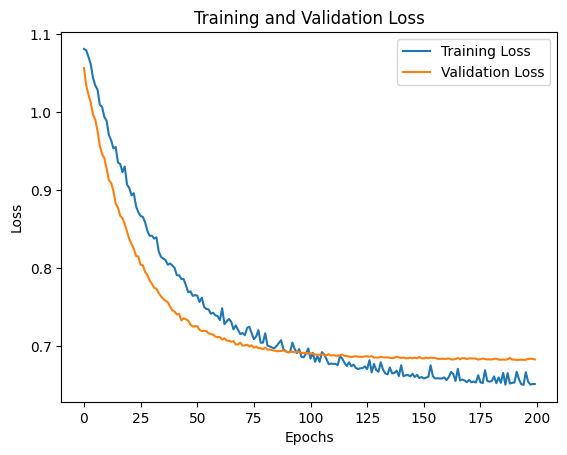

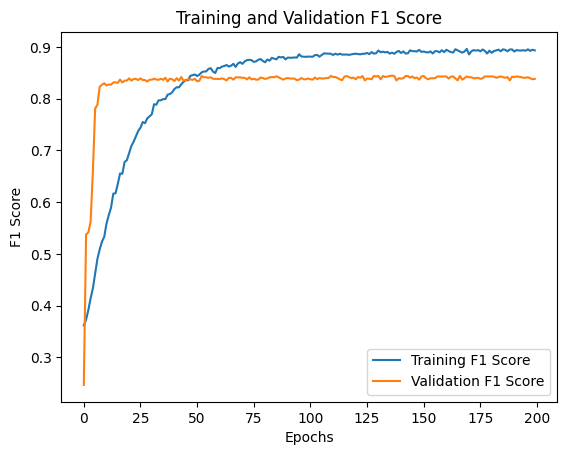

In [ ]:
# Initialize MetaClassifier and move to device
CNN_1D = CNN_1d().to(device)

# HP definition
num_epochs = 200
batch_size = 256
lr = 1e-5
weight_decay = 1e-3
model_path = "CNN.pth"

# Training loop
train_metaclassifier(CNN_1D, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

A bit of overfitting can be seen by means of the two plots above. The model's generalization capabilities seems to find a plateau pretty early in the training loop, but this is probably due to the simplicity of the input tensor.

In [ ]:
CNN_model = CNN_1d()
CNN_model.load_state_dict(torch.load(model_path))
CNN_model = CNN_model.to(device)

evaluate_metaclassifier(CNN_model, test_dataset)


Test Loss: 0.6578607420126598
Test Macro F1 Score: 0.8748051816150536
Test Weighted F1 Score: [0.88831169 0.89880952 0.83729433]
Test Accuracy: 0.8864981172673481
